# Programming Exercise 6:
# Support Vector Machines

## Introduction

In this exercise, you will be using support vector machines (SVMs) to build a spam classifier. Before starting on the programming exercise, we strongly recommend watching the video lectures and completing the review questions for the associated topics.

All the information you need for solving this assignment is in this notebook, and all the code you will be implementing will take place within this notebook. The assignment can be promptly submitted to the coursera grader directly from this notebook (code and instructions are included below).

Before we begin with the exercises, we need to import all libraries required for this programming exercise. Throughout the course, we will be using [`numpy`](http://www.numpy.org/) for all arrays and matrix operations, [`matplotlib`](https://matplotlib.org/) for plotting, and [`scipy`](https://docs.scipy.org/doc/scipy/reference/) for scientific and numerical computation functions and tools. You can find instructions on how to install required libraries in the README file in the [github repository](https://github.com/dibgerge/ml-coursera-python-assignments).

In [1]:
# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# Import regular expressions to process emails
import re

# Plotting library
from matplotlib import pyplot

# Optimization module in scipy
from scipy import optimize

# will be used to load MATLAB mat datafile format
from scipy.io import loadmat

# library written for this exercise providing additional functions for assignment submission, and others
import utils

# tells matplotlib to embed plots within the notebook
%matplotlib inline

import seaborn as sns
from sklearn import svm
import matplotlib.pyplot as plt
import time

## 1 Support Vector Machines

In the first half of this exercise, you will be using support vector machines (SVMs) with various example 2D datasets. Experimenting with these datasets will help you gain an intuition of how SVMs work and how to use a Gaussian kernel with SVMs. In the next half of the exercise, you will be using support
vector machines to build a spam classifier.

### 1.1 Example Dataset 1

We will begin by with a 2D example dataset which can be separated by a linear boundary. The following cell plots the training data, which should look like this:

![Dataset 1 training data](Figures/dataset1.png)

In this dataset, the positions of the positive examples (indicated with `x`) and the negative examples (indicated with `o`) suggest a natural separation indicated by the gap. However, notice that there is an outlier positive example `x` on the far left at about (0.1, 4.1). As part of this exercise, you will also see how this outlier affects the SVM decision boundary.

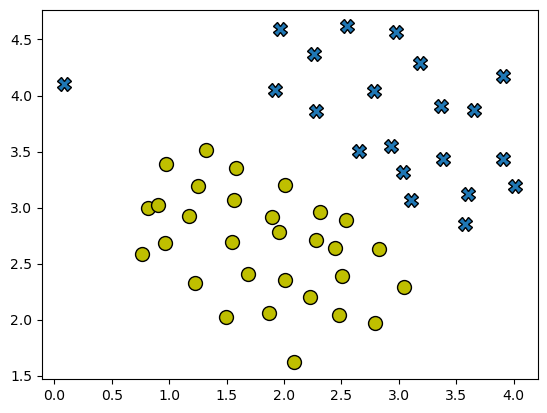

In [2]:
# Load from ex6data1
# You will have X, y as keys in the dict data
data = loadmat(os.path.join('Data', 'ex6data1.mat'))
X, y = data['X'], data['y'][:, 0]

# Plot training data
utils.plotData(X, y)

In this part of the exercise, you will try using different values of the $C$ parameter with SVMs. Informally, the $C$ parameter is a positive value that controls the penalty for misclassified training examples. A large $C$ parameter tells the SVM to try to classify all the examples correctly. $C$ plays a role similar to $1/\lambda$, where $\lambda$ is the regularization parameter that we were using previously for logistic regression.


The following cell will run the SVM training (with $C=1$) using SVM software that we have included with the starter code (function `svmTrain` within the `utils` module of this exercise). When $C=1$, you should find that the SVM puts the decision boundary in the gap between the two datasets and *misclassifies* the data point on the far left, as shown in the figure (left) below.

<table style="text-align:center">
    <tr>
        <th colspan="2" style="text-align:center">SVM Decision boundary for example dataset 1 </th>
    </tr>
    <tr>
        <td style="text-align:center">C=1<img src="Figures/svm_c1.png"/></td>
        <td style="text-align:center">C=100<img src="Figures/svm_c100.png"/></td>
    </tr>
</table>

<div class="alert alert-block alert-warning">
In order to minimize the dependency of this assignment on external libraries, we have included this implementation of an SVM learning algorithm in utils.svmTrain. However, this particular implementation is not very efficient (it was originally chosen to maximize compatibility between Octave/MATLAB for the first version of this assignment set). If you are training an SVM on a real problem, especially if you need to scale to a larger dataset, we strongly recommend instead using a highly optimized SVM toolbox such as [LIBSVM](https://www.csie.ntu.edu.tw/~cjlin/libsvm/). The python machine learning library [scikit-learn](http://scikit-learn.org/stable/index.html) provides wrappers for the LIBSVM library.
</div>
<br/>
<div class="alert alert-block alert-warning">
**Implementation Note:** Most SVM software packages (including the function `utils.svmTrain`) automatically add the extra feature $x_0$ = 1 for you and automatically take care of learning the intercept term $\theta_0$. So when passing your training data to the SVM software, there is no need to add this extra feature $x_0 = 1$ yourself. In particular, in python your code should be working with training examples $x \in \mathcal{R}^n$ (rather than $x \in \mathcal{R}^{n+1}$); for example, in the first example dataset $x \in \mathcal{R}^2$.
</div>

Your task is to try different values of $C$ on this dataset. Specifically, you should change the value of $C$ in the next cell to $C = 100$ and run the SVM training again. When $C = 100$, you should find that the SVM now classifies every single example correctly, but has a decision boundary that does not
appear to be a natural fit for the data.

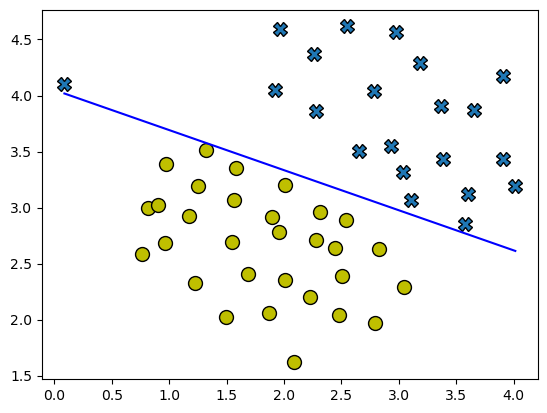

In [3]:
# You should try to change the C value below and see how the decision
# boundary varies (e.g., try C = 1000)
C = 1000

model = utils.svmTrain(X, y, C, utils.linearKernel, 1e-3, 20)
utils.visualizeBoundaryLinear(X, y, model)

<a id="section1"></a>
### 1.2 SVM with Gaussian Kernels

In this part of the exercise, you will be using SVMs to do non-linear classification. In particular, you will be using SVMs with Gaussian kernels on datasets that are not linearly separable.

#### 1.2.1 Gaussian Kernel

To find non-linear decision boundaries with the SVM, we need to first implement a Gaussian kernel. You can think of the Gaussian kernel as a similarity function that measures the “distance” between a pair of examples,
($x^{(i)}$, $x^{(j)}$). The Gaussian kernel is also parameterized by a bandwidth parameter, $\sigma$, which determines how fast the similarity metric decreases (to 0) as the examples are further apart.
You should now complete the code in `gaussianKernel` to compute the Gaussian kernel between two examples, ($x^{(i)}$, $x^{(j)}$). The Gaussian kernel function is defined as:

$$ K_{\text{gaussian}} \left( x^{(i)}, x^{(j)} \right) = \exp \left( - \frac{\left\lvert\left\lvert x^{(i)} - x^{(j)}\right\lvert\right\lvert^2}{2\sigma^2} \right) = \exp \left( -\frac{\sum_{k=1}^n \left( x_k^{(i)} - x_k^{(j)}\right)^2}{2\sigma^2} \right)$$
<a id="gaussianKernel"></a>

In [4]:
def gaussianKernel(x1, x2, sigma):
    """
    Computes the radial basis function
    Returns a radial basis function kernel between x1 and x2.
    
    Parameters
    ----------
    x1 :  numpy ndarray
        A vector of size (n, ), representing the first datapoint.
    
    x2 : numpy ndarray
        A vector of size (n, ), representing the second datapoint.
    
    sigma : float
        The bandwidth parameter for the Gaussian kernel.

    Returns
    -------
    sim : float
        The computed RBF between the two provided data points.
    
    Instructions
    ------------
    Fill in this function to return the similarity between `x1` and `x2`
    computed using a Gaussian kernel with bandwidth `sigma`.
    """
    sim = 0
    # ====================== YOUR CODE HERE ======================
    sim = np.exp(- np.sum((x1-x2)**2) / (2*sigma**2))


    # =============================================================
    return sim

Once you have completed the function `gaussianKernel` the following cell will test your kernel function on two provided examples and you should expect to see a value of 0.324652.

In [5]:
x1 = np.array([1, 2, 1])
x2 = np.array([0, 4, -1])
sigma = 2

sim = gaussianKernel(x1, x2, sigma)

print('Gaussian Kernel between x1 = [1, 2, 1], x2 = [0, 4, -1], sigma = %0.2f:'
      '\n\t%f\n(for sigma = 2, this value should be about 0.324652)\n' % (sigma, sim))

Gaussian Kernel between x1 = [1, 2, 1], x2 = [0, 4, -1], sigma = 2.00:
	0.324652
(for sigma = 2, this value should be about 0.324652)



### 1.2.2 Example Dataset 2

The next part in this notebook will load and plot dataset 2, as shown in the figure below. 

![Dataset 2](Figures/dataset2.png)

<Axes: >

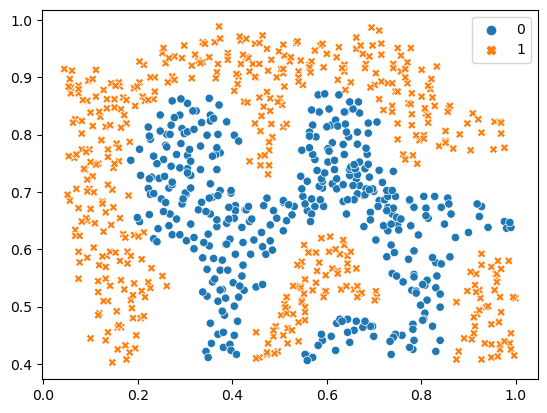

In [6]:
# Load from ex6data2
# You will have X, y as keys in the dict data
data = loadmat(os.path.join('Data', 'ex6data2.mat'))
X, y = data['X'], data['y'][:, 0]

# Plot training data
#utils.plotData(X, y)
sns.scatterplot(x=data['X'][:,0],y=data['X'][:,1],hue =data['y'].ravel(),style=data['y'].ravel())

From the figure, you can obserse that there is no linear decision boundary that separates the positive and negative examples for this dataset. However, by using the Gaussian kernel with the SVM, you will be able to learn a non-linear decision boundary that can perform reasonably well for the dataset. If you have correctly implemented the Gaussian kernel function, the following cell will proceed to train the SVM with the Gaussian kernel on this dataset.

You should get a decision boundary as shown in the figure below, as computed by the SVM with a Gaussian kernel. The decision boundary is able to separate most of the positive and negative examples correctly and follows the contours of the dataset well.

![Dataset 2 decision boundary](Figures/svm_dataset2.png)

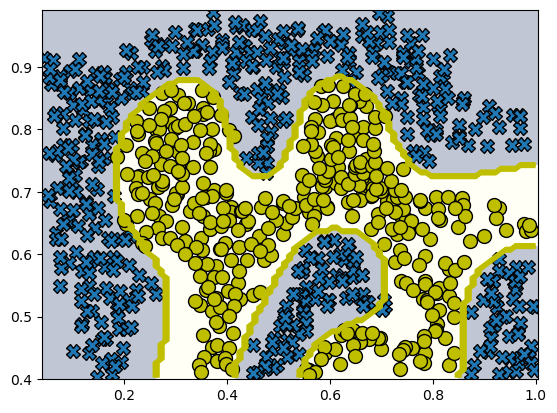

In [7]:
# SVM Parameters
C = 1
sigma = 0.1

model= utils.svmTrain(X, y, C, gaussianKernel, args=(sigma,))
utils.visualizeBoundary(X, y, model)

<a id="section2"></a>
#### 1.2.3 Example Dataset 3

In this part of the exercise, you will gain more practical skills on how to use a SVM with a Gaussian kernel. The next cell will load and display a third dataset, which should look like the figure below.

![Dataset 3](Figures/dataset3.png)

You will be using the SVM with the Gaussian kernel with this dataset. In the provided dataset, `ex6data3.mat`, you are given the variables `X`, `y`, `Xval`, `yval`. 

<Axes: >

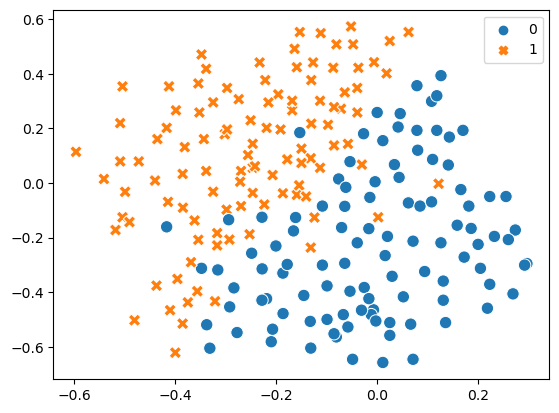

In [8]:
# Load from ex6data3
# You will have X, y, Xval, yval as keys in the dict data
data = loadmat(os.path.join('Data', 'ex6data3.mat'))
X, y, Xval, yval = data['X'], data['y'][:, 0], data['Xval'], data['yval'][:, 0]

# Plot training data
#utils.plotData(X, y)
sns.scatterplot(x=data['X'][:,0],y=data['X'][:,1],hue =data['y'].ravel(),style=data['y'].ravel(),s=80)

Your task is to use the cross validation set `Xval`, `yval` to determine the best $C$ and $\sigma$ parameter to use. You should write any additional code necessary to help you search over the parameters $C$ and $\sigma$. For both $C$ and $\sigma$, we suggest trying values in multiplicative steps (e.g., 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30).
Note that you should try all possible pairs of values for $C$ and $\sigma$ (e.g., $C = 0.3$ and $\sigma = 0.1$). For example, if you try each of the 8 values listed above for $C$ and for $\sigma^2$, you would end up training and evaluating (on the cross validation set) a total of $8^2 = 64$ different models. After you have determined the best $C$ and $\sigma$ parameters to use, you should modify the code in `dataset3Params`, filling in the best parameters you found. For our best parameters, the SVM returned a decision boundary shown in the figure below. 

![](Figures/svm_dataset3_best.png)

<div class="alert alert-block alert-warning">
**Implementation Tip:** When implementing cross validation to select the best $C$ and $\sigma$ parameter to use, you need to evaluate the error on the cross validation set. Recall that for classification, the error is defined as the fraction of the cross validation examples that were classified incorrectly. In `numpy`, you can compute this error using `np.mean(predictions != yval)`, where `predictions` is a vector containing all the predictions from the SVM, and `yval` are the true labels from the cross validation set. You can use the `utils.svmPredict` function to generate the predictions for the cross validation set.
</div>
<a id="dataset3Params"></a>

In [9]:
'''
def gaussian_kernel(x1, x2, sigma=0.1):
    x1 = x1.ravel()
    x2 = x2.ravel()
    sumx1x2 = np.sum((x1-x2)**2)
    return np.exp(-sumx1x2/(2*sigma**2))
'''
def gaussian_kernel_matrix(X1, X2, sigma=0.1):
    gram_matrix = np.zeros((X1.shape[0], X2.shape[0]))
    for i, x1 in enumerate(X1):
        for j, x2 in enumerate(X2):
            gram_matrix[i, j] = gaussianKernel(x1, x2, sigma)
    return gram_matrix

In [10]:
def dataset3Params(X, y, Xval, yval):
    """
    Returns your choice of C and sigma for Part 3 of the exercise 
    where you select the optimal (C, sigma) learning parameters to use for SVM
    with RBF kernel.
    
    Parameters
    ----------
    X : array_like
        (m x n) matrix of training data where m is number of training examples, and 
        n is the number of features.
    
    y : array_like
        (m, ) vector of labels for ther training data.
    
    Xval : array_like
        (mv x n) matrix of validation data where mv is the number of validation examples
        and n is the number of features
    
    yval : array_like
        (mv, ) vector of labels for the validation data.
    
    Returns
    -------
    C, sigma : float, float
        The best performing values for the regularization parameter C and 
        RBF parameter sigma.
    
    Instructions
    ------------
    Fill in this function to return the optimal C and sigma learning 
    parameters found using the cross validation set.
    You can use `svmPredict` to predict the labels on the cross
    validation set. For example, 
    
        predictions = utils.svmPredict(model, Xval)

    will return the predictions on the cross validation set.
    
    Note
    ----
    You can compute the prediction error using 
    
        np.mean(predictions != yval)
    """
    # You need to return the following variables correctly.
    #C = 1
    #sigma = 0.3

    # ====================== YOUR CODE HERE ======================
    C_vals = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
    sigma_vals = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
    error = 9999

    C = 0.01
    sigma = 0.01
    for c in C_vals:
        for s in sigma_vals:
            clf = svm.SVC(kernel="precomputed", C=c)
            gram = gaussian_kernel_matrix(X, X, sigma=s)
            clf.fit(gram, y)

            gram_pred = gaussian_kernel_matrix(Xval, X) #add sigma=s? default is sigma=0.1
            y_pred = clf.predict(gram_pred)
            
            error_mean = np.mean(y_pred != yval)
            if error_mean < error:
                C = c
                sigma = s
                error = error_mean
    # ============================================================
    return C, sigma

The provided code in the next cell trains the SVM classifier using the training set $(X, y)$ using parameters loaded from `dataset3Params`. Note that this might take a few minutes to execute.

In [11]:
# Try different SVM Parameters here
c_sigma_start = time.time()
C, sigma = dataset3Params(X, y, Xval, yval)
c_sigma_end = time.time()
print(f'The time for finding C and sigma %.2f' % (c_sigma_end - c_sigma_start))
print('C:',C)
print('sigma:',sigma)

The time for finding C and sigma 52.63
C: 1
sigma: 0.1


In [12]:
# Train the SVM

1 0.1


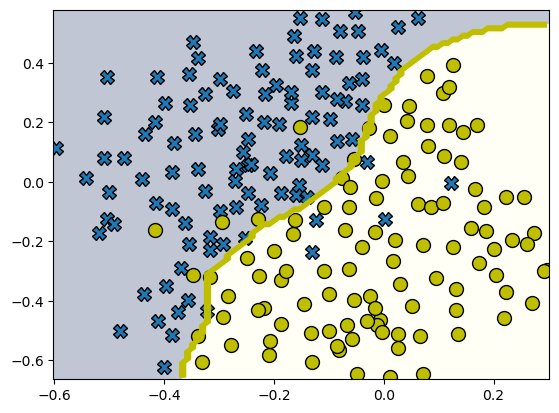

In [13]:
# 1: using the utils file:
# model = utils.svmTrain(X, y, C, lambda x1, x2: gaussianKernel(x1, x2, sigma))
model = utils.svmTrain(X, y, C, gaussianKernel, args=(sigma,))
utils.visualizeBoundary(X, y, model)
print(C, sigma)

In [14]:
#2: using scikit-learn and defining the Gaussian Kernel Matrix (Gram) and using kernel="precomputed". 
clf = svm.SVC(kernel="precomputed", C=C)
gram = gaussian_kernel_matrix(X, X, sigma=sigma)
clf.fit(gram,y)

SVC(C=1, kernel='precomputed')

In [15]:
def plot_gaussian_boundary(X, y, model, title='SVM Decision Boundary for Gaussian Kernel'):
    plt.figure(figsize=(7,5))
    ax = sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, style=y, s=80, legend=False)
    ax.set(title=title)
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    gram = gaussian_kernel_matrix(xy, X)
    Z = model.predict(gram).reshape(XX.shape)

    a = ax.contour(XX, YY, Z, colors='g', levels=[0.5], linestyles=['--'])
    plt.show()

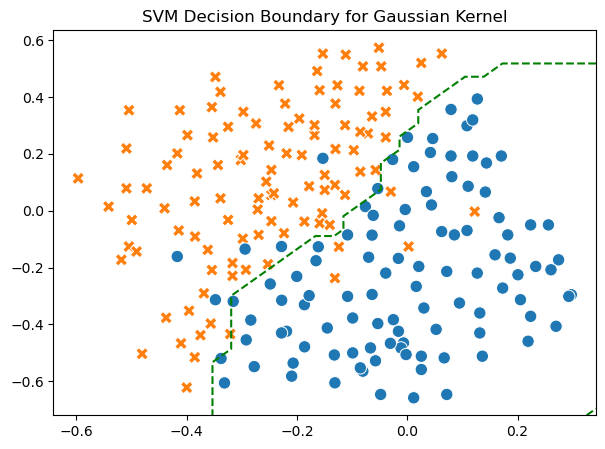

In [16]:
plot_gaussian_boundary(X, y, clf)

<a id="section3"></a>
## 2 Spam Classification

Many email services today provide spam filters that are able to classify emails into spam and non-spam email with high accuracy. In this part of the exercise, you will use SVMs to build your own spam filter.

You will be training a classifier to classify whether a given email, $x$, is spam ($y = 1$) or non-spam ($y = 0$). In particular, you need to convert each email into a feature vector $x \in \mathbb{R}^n$ . The following parts of the exercise will walk you through how such a feature vector can be constructed from an email.

The dataset included for this exercise is based on a a subset of the [SpamAssassin Public Corpus](http://spamassassin.apache.org/old/publiccorpus/). For the purpose of this exercise, you will only be using the body of the email (excluding the email headers).

### 2.1 Preprocessing Emails

Before starting on a machine learning task, it is usually insightful to take a look at examples from the dataset. The figure below shows a sample email that contains a URL, an email address (at the end), numbers, and dollar
amounts.

<img src="Figures/email.png" width="700px" />

While many emails would contain similar types of entities (e.g., numbers, other URLs, or other email addresses), the specific entities (e.g., the specific URL or specific dollar amount) will be different in almost every
email. Therefore, one method often employed in processing emails is to “normalize” these values, so that all URLs are treated the same, all numbers are treated the same, etc. For example, we could replace each URL in the
email with the unique string “httpaddr” to indicate that a URL was present.

This has the effect of letting the spam classifier make a classification decision based on whether any URL was present, rather than whether a specific URL was present. This typically improves the performance of a spam classifier, since spammers often randomize the URLs, and thus the odds of seeing any particular URL again in a new piece of spam is very small. 

In the function `processEmail` below, we have implemented the following email preprocessing and normalization steps:

- **Lower-casing**: The entire email is converted into lower case, so that captialization is ignored (e.g., IndIcaTE is treated the same as Indicate).

- **Stripping HTML**: All HTML tags are removed from the emails. Many emails often come with HTML formatting; we remove all the HTML tags, so that only the content remains.

- **Normalizing URLs**: All URLs are replaced with the text “httpaddr”.

- **Normalizing Email Addresses**:  All email addresses are replaced with the text “emailaddr”.

- **Normalizing Numbers**: All numbers are replaced with the text “number”.

- **Normalizing Dollars**: All dollar signs ($) are replaced with the text “dollar”.

- **Word Stemming**: Words are reduced to their stemmed form. For example, “discount”, “discounts”, “discounted” and “discounting” are all replaced with “discount”. Sometimes, the Stemmer actually strips off additional characters from the end, so “include”, “includes”, “included”, and “including” are all replaced with “includ”.

- **Removal of non-words**: Non-words and punctuation have been removed. All white spaces (tabs, newlines, spaces) have all been trimmed to a single space character.

The result of these preprocessing steps is shown in the figure below. 

<img src="Figures/email_cleaned.png" alt="email cleaned" style="width: 600px;"/>

While preprocessing has left word fragments and non-words, this form turns out to be much easier to work with for performing feature extraction.

#### 2.1.1 Vocabulary List

After preprocessing the emails, we have a list of words for each email. The next step is to choose which words we would like to use in our classifier and which we would want to leave out.

For this exercise, we have chosen only the most frequently occuring words as our set of words considered (the vocabulary list). Since words that occur rarely in the training set are only in a few emails, they might cause the
model to overfit our training set. The complete vocabulary list is in the file `vocab.txt` (inside the `Data` directory for this exercise) and also shown in the figure below.

<img src="Figures/vocab.png" alt="Vocab" width="150px" />

Our vocabulary list was selected by choosing all words which occur at least a 100 times in the spam corpus,
resulting in a list of 1899 words. In practice, a vocabulary list with about 10,000 to 50,000 words is often used.
Given the vocabulary list, we can now map each word in the preprocessed emails into a list of word indices that contains the index of the word in the vocabulary dictionary. The figure below shows the mapping for the sample email. Specifically, in the sample email, the word “anyone” was first normalized to “anyon” and then mapped onto the index 86 in the vocabulary list.

<img src="Figures/word_indices.png" alt="word indices" width="200px" />

Your task now is to complete the code in the function `processEmail` to perform this mapping. In the code, you are given a string `word` which is a single word from the processed email. You should look up the word in the vocabulary list `vocabList`. If the word exists in the list, you should add the index of the word into the `word_indices` variable. If the word does not exist, and is therefore not in the vocabulary, you can skip the word.

<div class="alert alert-block alert-warning">
**python tip**: In python, you can find the index of the first occurence of an item in `list` using the  `index` attribute. In the provided code for `processEmail`, `vocabList` is a python list containing the words in the vocabulary. To find the index of a word, we can use `vocabList.index(word)` which would return a number indicating the index of the word within the list. If the word does not exist in the list, a `ValueError` exception is raised. In python, we can use the `try/except` statement to catch exceptions which we do not want to stop the program from running. You can think of the `try/except` statement to be the same as an `if/else` statement, but it asks for forgiveness rather than permission.

An example would be:
<br>

```
try:
    do stuff here
except ValueError:
    pass
    # do nothing (forgive me) if a ValueError exception occured within the try statement
```
</div>
<a id="processEmail"></a>

In [17]:
def processEmail(email_contents, verbose=True):
    """
    Preprocesses the body of an email and returns a list of indices 
    of the words contained in the email.    
    
    Parameters
    ----------
    email_contents : str
        A string containing one email. 
    
    verbose : bool
        If True, print the resulting email after processing.
    
    Returns
    -------
    word_indices : list
        A list of integers containing the index of each word in the 
        email which is also present in the vocabulary.
    
    Instructions
    ------------
    Fill in this function to add the index of word to word_indices 
    if it is in the vocabulary. At this point of the code, you have 
    a stemmed word from the email in the variable word.
    You should look up word in the vocabulary list (vocabList). 
    If a match exists, you should add the index of the word to the word_indices
    list. Concretely, if word = 'action', then you should
    look up the vocabulary list to find where in vocabList
    'action' appears. For example, if vocabList[18] =
    'action', then, you should add 18 to the word_indices 
    vector (e.g., word_indices.append(18)).
    
    Notes
    -----
    - vocabList[idx] returns a the word with index idx in the vocabulary list.
    
    - vocabList.index(word) return index of word `word` in the vocabulary list.
      (A ValueError exception is raised if the word does not exist.)
    """
    # Load Vocabulary
    vocabList = utils.getVocabList()

    # Init return value
    word_indices = []

    # ========================== Preprocess Email ===========================
    # Find the Headers ( \n\n and remove )
    # Uncomment the following lines if you are working with raw emails with the
    # full headers
    # hdrstart = email_contents.find(chr(10) + chr(10))
    # email_contents = email_contents[hdrstart:]

    # Lower case
    email_contents = email_contents.lower()
    
    # Strip all HTML
    # Looks for any expression that starts with < and ends with > and replace
    # and does not have any < or > in the tag it with a space
    email_contents =re.compile('<[^<>]+>').sub(' ', email_contents)

    # Handle Numbers
    # Look for one or more characters between 0-9
    email_contents = re.compile('[0-9]+').sub(' number ', email_contents)

    # Handle URLS
    # Look for strings starting with http:// or https://
    email_contents = re.compile('(http|https)://[^\s]*').sub(' httpaddr ', email_contents)

    # Handle Email Addresses
    # Look for strings with @ in the middle
    email_contents = re.compile('[^\s]+@[^\s]+').sub(' emailaddr ', email_contents)
    
    # Handle $ sign
    email_contents = re.compile('[$]+').sub(' dollar ', email_contents)
    
    # get rid of any punctuation
    email_contents = re.split('[ @$/#.-:&*+=\[\]?!(){},''">_<;%\n\r]', email_contents)

    # remove any empty word string
    email_contents = [word for word in email_contents if len(word) > 0]
    
    # Stem the email contents word by word
    stemmer = utils.PorterStemmer()
    processed_email = []
    for word in email_contents:
        # Remove any remaining non alphanumeric characters in word
        word = re.compile('[^a-zA-Z0-9]').sub('', word).strip()
        word = stemmer.stem(word)
        processed_email.append(word)

        if len(word) < 1:
            continue

        # Look up the word in the dictionary and add to word_indices if found
        # ====================== YOUR CODE HERE ======================
        if word in vocabList:
            word_indices.append(vocabList.index(word))
            
        # =============================================================

    if verbose:
        print('----------------')
        print('Processed email:')
        print('----------------')
        print(' '.join(processed_email))
    return word_indices

Once you have implemented `processEmail`, the following cell will run your code on the email sample and you should see an output of the processed email and the indices list mapping.

In [18]:
#  To use an SVM to classify emails into Spam v.s. Non-Spam, you first need
#  to convert each email into a vector of features. In this part, you will
#  implement the preprocessing steps for each email. You should
#  complete the code in processEmail.m to produce a word indices vector
#  for a given email.

# Extract Features
with open(os.path.join('Data', 'emailSample1.txt')) as fid:
    file_contents = fid.read()

word_indices  = processEmail(file_contents)

#Print Stats
print('-------------')
print('Word Indices:')
print('-------------')
print(word_indices)

----------------
Processed email:
----------------
anyon know how much it cost to host a web portal well it depend on how mani visitor your expect thi can be anywher from less than number buck a month to a coupl of dollar number you should checkout httpaddr or perhap amazon ec number if your run someth big to unsubscrib yourself from thi mail list send an email to emailaddr
-------------
Word Indices:
-------------
[85, 915, 793, 1076, 882, 369, 1698, 789, 1821, 1830, 882, 430, 1170, 793, 1001, 1894, 591, 1675, 237, 161, 88, 687, 944, 1662, 1119, 1061, 1698, 374, 1161, 476, 1119, 1892, 1509, 798, 1181, 1236, 511, 1119, 809, 1894, 1439, 1546, 180, 1698, 1757, 1895, 687, 1675, 991, 960, 1476, 70, 529, 1698, 530]


<a id="section4"></a>
### 2.2 Extracting Features from Emails

You will now implement the feature extraction that converts each email into a vector in $\mathbb{R}^n$. For this exercise, you will be using n = # words in vocabulary list. Specifically, the feature $x_i \in \{0, 1\}$ for an email corresponds to whether the $i^{th}$ word in the dictionary occurs in the email. That is, $x_i = 1$ if the $i^{th}$ word is in the email and $x_i = 0$ if the $i^{th}$ word is not present in the email.

Thus, for a typical email, this feature would look like:

$$ x = \begin{bmatrix} 
0 & \dots & 1 & 0 & \dots & 1 & 0 & \dots & 0 
\end{bmatrix}^T \in \mathbb{R}^n
$$

You should now complete the code in the function `emailFeatures` to generate a feature vector for an email, given the `word_indices`.
<a id="emailFeatures"></a>

In [19]:
def emailFeatures(word_indices):
    """
    Takes in a word_indices vector and produces a feature vector from the word indices. 
    
    Parameters
    ----------
    word_indices : list
        A list of word indices from the vocabulary list.
    
    Returns
    -------
    x : list 
        The computed feature vector.
    
    Instructions
    ------------
    Fill in this function to return a feature vector for the
    given email (word_indices). To help make it easier to  process 
    the emails, we have have already pre-processed each email and converted
    each word in the email into an index in a fixed dictionary (of 1899 words).
    The variable `word_indices` contains the list of indices of the words 
    which occur in one email.
    
    Concretely, if an email has the text:

        The quick brown fox jumped over the lazy dog.

    Then, the word_indices vector for this text might look  like:
               
        60  100   33   44   10     53  60  58   5

    where, we have mapped each word onto a number, for example:

        the   -- 60
        quick -- 100
        ...

    Note
    ----
    The above numbers are just an example and are not the actual mappings.

    Your task is take one such `word_indices` vector and construct
    a binary feature vector that indicates whether a particular
    word occurs in the email. That is, x[i] = 1 when word i
    is present in the email. Concretely, if the word 'the' (say,
    index 60) appears in the email, then x[60] = 1. The feature
    vector should look like:
        x = [ 0 0 0 0 1 0 0 0 ... 0 0 0 0 1 ... 0 0 0 1 0 ..]
    """
    # Total number of words in the dictionary
    n = 1899

    # You need to return the following variables correctly.
    x = np.zeros(n) #or np.zeros((n,1))

    # ===================== YOUR CODE HERE ======================
    x[word_indices]=1
    
    # ===========================================================
    
    return x

Once you have implemented `emailFeatures`, the next cell will run your code on the email sample. You should see that the feature vector had length 1899 and 45 non-zero entries.

In [20]:
# Extract Features
with open(os.path.join('Data', 'emailSample1.txt')) as fid:
    file_contents = fid.read()

word_indices  = processEmail(file_contents)
features      = emailFeatures(word_indices)

# Print Stats
print('\nLength of feature vector: %d' % len(features))
print('Number of non-zero entries: %d' % sum(features > 0)) #or sum(features==1)[0]

----------------
Processed email:
----------------
anyon know how much it cost to host a web portal well it depend on how mani visitor your expect thi can be anywher from less than number buck a month to a coupl of dollar number you should checkout httpaddr or perhap amazon ec number if your run someth big to unsubscrib yourself from thi mail list send an email to emailaddr

Length of feature vector: 1899
Number of non-zero entries: 45


### 2.3 Training SVM for Spam Classification

In the following section we will load a preprocessed training dataset that will be used to train a SVM classifier. The file `spamTrain.mat` (within the `Data` folder for this exercise) contains 4000 training examples of spam and non-spam email, while `spamTest.mat` contains 1000 test examples. Each
original email was processed using the `processEmail` and `emailFeatures` functions and converted into a vector $x^{(i)} \in \mathbb{R}^{1899}$.

After loading the dataset, the next cell proceed to train a linear SVM to classify between spam ($y = 1$) and non-spam ($y = 0$) emails. Once the training completes, you should see that the classifier gets a training accuracy of about 99.8% and a test accuracy of about 98.5%.

In [21]:
# 1: using the utils.py
# Load the Spam Email dataset
# You will have X, y in your environment
data = loadmat(os.path.join('Data', 'spamTrain.mat'))
X, y= data['X'].astype(float), data['y'][:, 0]

print('Training Linear SVM (Spam Classification)')
print('This may take 1 to 2 minutes ...')

#choose C:
C = 0.1
model = utils.svmTrain(X, y, C, utils.linearKernel)

Training Linear SVM (Spam Classification)
This may take 1 to 2 minutes ...


In [22]:
# Compute the training accuracy
p = utils.svmPredict(model, X)
print('Training Accuracy: %.2f' % (np.mean(p == y) * 100))

Training Accuracy: 99.83


Execute the following cell to load the test set and compute the test accuracy.

In [23]:
# Load the test dataset
# You will have Xtest, ytest in your environment
data = loadmat(os.path.join('Data', 'spamTest.mat'))
Xtest, ytest = data['Xtest'].astype(float), data['ytest'][:, 0]

print('Evaluating the trained Linear SVM on a test set ...')
p = utils.svmPredict(model, Xtest)

print('Test Accuracy: %.2f' % (np.mean(p == ytest) * 100))

Evaluating the trained Linear SVM on a test set ...
Test Accuracy: 98.80


In [24]:
# 2: Training with scikit-learn: Using a linear kernel

In [25]:
#using the same C

In [26]:
import time
Training_linear_start = time.time()
clf = svm.SVC(kernel="linear", C=C)
clf.fit(X,y)
y_pred = clf.predict(X)
print('Training Accuracy: %.2f' % (np.mean(y_pred == y) * 100))
ytest_pred = clf.predict(Xtest)
print('Test Accuracy: %.2f' % (np.mean(ytest_pred == ytest) * 100))
Training_linear_end = time.time()
print(f'Training and testing with Linear kernel took %.2f' % (Training_linear_end - Training_linear_start))

Training Accuracy: 99.83
Test Accuracy: 98.90
Training and testing with Linear kernel took 4.88


In [27]:
# 2: Training with scikit-learn: Using a Gaussian Kernel (takes longer to run)
# precomputed kernel with the precomputed Gram matrix.

In [28]:
#choose C:
# C = 1

In [29]:
Training_gaussian_start = time.time()
clf = svm.SVC(kernel="precomputed", C = C)
gram = gaussian_kernel_matrix(X, X)
clf.fit(gram,y)
y_pred = clf.predict(gram)
print('Training Accuracy: %.2f' % (np.mean(y_pred == y) * 100))
Training_gaussian_end = time.time()
print(f'Training with Gaussian kernel took %.2f' % (Training_gaussian_end - Training_gaussian_start))

Training Accuracy: 68.42
Training with Gaussian kernel took 563.05


In [30]:
Testing_gaussian_start = time.time()
gram = gaussian_kernel_matrix(Xtest, X)
y_pred = clf.predict(gram)
print('Test Accuracy: %.2f' % (np.mean(y_pred == ytest) * 100))
Testing_gaussian_end = time.time()
print(f'Testing with Gaussian kernel took  %.2f' % (Testing_gaussian_end - Testing_gaussian_start))

Test Accuracy: 69.30
Testing with Gaussian kernel took  160.90


### 2.4 Top Predictors for Spam

To better understand how the spam classifier works, we can inspect the parameters to see which words the classifier thinks are the most predictive of spam. The next cell finds the parameters with the largest positive values in the classifier and displays the corresponding words similar to the ones shown in the figure below.

<div style="border-style: solid; border-width: 1px; margin: 10px 10px 10px 10px; padding: 10px 10px 10px 10px">
our  click  remov guarante visit basenumb dollar pleas price will nbsp most lo ga hour
</div>

Thus, if an email contains words such as “guarantee”, “remove”, “dollar”, and “price” (the top predictors shown in the figure), it is likely to be classified as spam.

Since the model we are training is a linear SVM, we can inspect the weights learned by the model to understand better how it is determining whether an email is spam or not. The following code finds the words with the highest weights in the classifier. Informally, the classifier 'thinks' that these words are the most likely indicators of spam.

In [31]:
# Sort the weights and obtin the vocabulary list
# NOTE some words have the same weights, 
# so their order might be different than in the text above
idx = np.argsort(model['w'])
top_idx = idx[-15:][::-1]
vocabList = utils.getVocabList()

print('Top predictors of spam:')
print('%-15s %-15s' % ('word', 'weight'))
print('----' + ' '*12 + '------')
for word, w in zip(np.array(vocabList)[top_idx], model['w'][top_idx]):
    print('%-15s %0.2f' % (word, w))

Top predictors of spam:
word            weight         
----            ------
our             0.50
click           0.47
remov           0.43
guarante        0.38
visit           0.37
basenumb        0.35
dollar          0.33
will            0.27
price           0.27
pleas           0.27
most            0.26
nbsp            0.25
lo              0.25
ga              0.24
da              0.24


### 2.5 Optional (ungraded) exercise: Try your own emails

Now that you have trained a spam classifier, you can start trying it out on your own emails. In the starter code, we have included two email examples (`emailSample1.txt` and `emailSample2.txt`) and two spam examples (`spamSample1.txt` and `spamSample2.txt`). The next cell runs the spam classifier over the first spam example and classifies it using the learned SVM. You should now try the other examples we have provided and see if the classifier gets them right. You can also try your own emails by replacing the examples (plain text files) with your own emails.

*You do not need to submit any solutions for this optional (ungraded) exercise.*

In [32]:
filename = os.path.join('Data', 'spamSample2.txt')

with open(filename) as fid:
    file_contents = fid.read()

word_indices = processEmail(file_contents, verbose=False)
x = emailFeatures(word_indices)
p = utils.svmPredict(model, x)

print('\nProcessed %s\nSpam Classification: %s' % (filename, 'spam' if p else 'not spam'))
#unique, counts = np.unique(x, return_counts=True) #for ndarrays.


Processed Data/spamSample2.txt
Spam Classification: not spam


### 2.6 Optional (ungraded) exercise: Build your own dataset

In this exercise, we provided a preprocessed training set and test set. These datasets were created using the same functions (`processEmail` and `emailFeatures`) that you now have completed. For this optional (ungraded) exercise, you will build your own dataset using the original emails from the SpamAssassin Public Corpus.

Your task in this optional (ungraded) exercise is to download the original
files from the public corpus and extract them. After extracting them, you should run the `processEmail` and `emailFeatures` functions on each email to extract a feature vector from each email. This will allow you to build a dataset `X`, `y` of examples. You should then randomly divide up the dataset into a training set, a cross validation set and a test set.

While you are building your own dataset, we also encourage you to try building your own vocabulary list (by selecting the high frequency words that occur in the dataset) and adding any additional features that you think
might be useful. Finally, we also suggest trying to use highly optimized SVM toolboxes such as [`LIBSVM`](https://www.csie.ntu.edu.tw/~cjlin/libsvm/) or [`scikit-learn`](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.svm).

*You do not need to submit any solutions for this optional (ungraded) exercise.*

In [33]:
# Build a model to classify email as spam or ham. 
#First, download examples of spam and ham from Apache SpamAssassin’s public datasets 
#and then train a model to classify email.

#Objective:
# Fetch the data

In [34]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "http://spamassassin.apache.org/old/publiccorpus/"
HAM_URL = DOWNLOAD_ROOT + "20030228_easy_ham.tar.bz2"
SPAM_URL = DOWNLOAD_ROOT + "20030228_spam.tar.bz2"
SPAM_PATH = os.path.join("datasets", "spam")

def fetch_spam_data(spam_url=SPAM_URL, spam_path=SPAM_PATH):
    if not os.path.isdir(spam_path):
        os.makedirs(spam_path)
    for filename, url in (("ham.tar.bz2", HAM_URL), ("spam.tar.bz2", SPAM_URL)):
        path = os.path.join(spam_path, filename)
        if not os.path.isfile(path):
            urllib.request.urlretrieve(url, path)
        tar_bz2_file = tarfile.open(path)
        tar_bz2_file.extractall(path=SPAM_PATH)
        tar_bz2_file.close()

fetch_spam_data()

In [35]:
# Now load a few emails:

In [36]:
HAM_DIR = os.path.join(SPAM_PATH, "easy_ham")
SPAM_DIR = os.path.join(SPAM_PATH, "spam")
ham_filenames = [name for name in sorted(os.listdir(HAM_DIR)) if len(name) > 20]
spam_filenames = [name for name in sorted(os.listdir(SPAM_DIR)) if len(name) > 20]

print(len(ham_filenames))
print(len(spam_filenames))

2500
500


In [37]:
# Use Python's email module to parse these emails (this handles headers, encoding, and so on):

In [38]:
import email
import email.policy

def load_email(is_spam, filename, spam_path=SPAM_PATH):
    directory = "spam" if is_spam else "easy_ham"
    with open(os.path.join(spam_path, directory, filename), "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

ham_emails = [load_email(is_spam=False, filename=name) for name in ham_filenames]
spam_emails = [load_email(is_spam=True, filename=name) for name in spam_filenames]

In [39]:
# Let's look at one example of ham and one example of spam, to get a feel of what the data looks like:

In [40]:
print(ham_emails[1].get_content().strip())
print('\n\n------------next email---------------\n')
print(spam_emails[6].get_content().strip())

Martin A posted:
Tassos Papadopoulos, the Greek sculptor behind the plan, judged that the
 limestone of Mount Kerdylio, 70 miles east of Salonika and not far from the
 Mount Athos monastic community, was ideal for the patriotic sculpture. 
 
 As well as Alexander's granite features, 240 ft high and 170 ft wide, a
 museum, a restored amphitheatre and car park for admiring crowds are
planned
---------------------
So is this mountain limestone or granite?
If it's limestone, it'll weather pretty fast.

------------------------ Yahoo! Groups Sponsor ---------------------~-->
4 DVDs Free +s&p Join Now
http://us.click.yahoo.com/pt6YBB/NXiEAA/mG3HAA/7gSolB/TM
---------------------------------------------------------------------~->

To unsubscribe from this group, send an email to:
forteana-unsubscribe@egroups.com

 

Your use of Yahoo! Groups is subject to http://docs.yahoo.com/info/terms/


------------next email---------------

Help wanted.  We are a 14 year old fortune 500 company, that is


In [41]:
# Some emails are actually multipart, with images and attachments (which can have their own attachments). 
# Let's look at the various types of structures we have:

In [42]:
def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        return "multipart({})".format(", ".join([
            get_email_structure(sub_email)
            for sub_email in payload
        ]))
    else:
        return email.get_content_type()

from collections import Counter

def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures

print('\n\n------------ham emails information---------------\n')
structures_counter(ham_emails).most_common()



------------ham emails information---------------



[('text/plain', 2408),
 ('multipart(text/plain, application/pgp-signature)', 66),
 ('multipart(text/plain, text/html)', 8),
 ('multipart(text/plain, text/plain)', 4),
 ('multipart(text/plain)', 3),
 ('multipart(text/plain, application/octet-stream)', 2),
 ('multipart(text/plain, text/enriched)', 1),
 ('multipart(text/plain, application/ms-tnef, text/plain)', 1),
 ('multipart(multipart(text/plain, text/plain, text/plain), application/pgp-signature)',
  1),
 ('multipart(text/plain, video/mng)', 1),
 ('multipart(text/plain, multipart(text/plain))', 1),
 ('multipart(text/plain, application/x-pkcs7-signature)', 1),
 ('multipart(text/plain, multipart(text/plain, text/plain), text/rfc822-headers)',
  1),
 ('multipart(text/plain, multipart(text/plain, text/plain), multipart(multipart(text/plain, application/x-pkcs7-signature)))',
  1),
 ('multipart(text/plain, application/x-java-applet)', 1)]

In [43]:
print('\n\n------------spam emails information---------------\n')
structures_counter(spam_emails).most_common()



------------spam emails information---------------



[('text/plain', 218),
 ('text/html', 183),
 ('multipart(text/plain, text/html)', 45),
 ('multipart(text/html)', 20),
 ('multipart(text/plain)', 19),
 ('multipart(multipart(text/html))', 5),
 ('multipart(text/plain, image/jpeg)', 3),
 ('multipart(text/html, application/octet-stream)', 2),
 ('multipart(text/plain, application/octet-stream)', 1),
 ('multipart(text/html, text/plain)', 1),
 ('multipart(multipart(text/html), application/octet-stream, image/jpeg)', 1),
 ('multipart(multipart(text/plain, text/html), image/gif)', 1),
 ('multipart/alternative', 1)]

In [44]:
# Now let's take a look at the email headers:

In [45]:
for header, value in spam_emails[0].items():
    print(header,":",value)

Return-Path : <12a1mailbot1@web.de>
Delivered-To : zzzz@localhost.spamassassin.taint.org
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.spamassassin.taint.org (Postfix) with ESMTP id 136B943C32	for <zzzz@localhost>; Thu, 22 Aug 2002 08:17:21 -0400 (EDT)
Received : from mail.webnote.net [193.120.211.219]	by localhost with POP3 (fetchmail-5.9.0)	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 13:17:21 +0100 (IST)
Received : from dd_it7 ([210.97.77.167])	by webnote.net (8.9.3/8.9.3) with ESMTP id NAA04623	for <zzzz@spamassassin.taint.org>; Thu, 22 Aug 2002 13:09:41 +0100
From : 12a1mailbot1@web.de
Received : from r-smtp.korea.com - 203.122.2.197 by dd_it7  with Microsoft SMTPSVC(5.5.1775.675.6);	 Sat, 24 Aug 2002 09:42:10 +0900
To : dcek1a1@netsgo.com
Subject : Life Insurance - Why Pay More?
Date : Wed, 21 Aug 2002 20:31:57 -1600
MIME-Version : 1.0
Message-ID : <0103c1042001882DD_IT7@dd_it7>
Content-Type : text/html; charset="iso-8859-1"
Content-Transfer-Encoding : qu

In [46]:
# You need to focus on the Subject header:

In [47]:
spam_emails[0]["Subject"]

'Life Insurance - Why Pay More?'

In [48]:
import numpy as np
from sklearn.model_selection import train_test_split

X = np.array(ham_emails + spam_emails)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

/var/folders/2h/ty5jxk_d3dv14j953670q6500000gn/T/ipykernel_32566/892693871.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(ham_emails + spam_emails)


In [49]:
# let's start writing the preprocessing functions. 
# First, we will need a function to convert HTML to plain text. 
# The following function first drops the section, then converts all <a> tags to the word HYPERLINK, 
# then it gets rid of all HTML tags, leaving only the plain text. 
# For readability, it also replaces multiple newlines with single newlines, 
# and finally it unescapes html entities (such as > or  ):

In [50]:
import re
from html import unescape

def html_to_plain_text(html):
    text = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I)
    text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)
    text = re.sub('<.*?>', '', text, flags=re.M | re.S)
    text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
    return unescape(text)

html_spam_emails = [email for email in X[y==1]
                    if get_email_structure(email) == "text/html"]
sample_html_spam = html_spam_emails[2]
#print(sample_html_spam.get_content().strip()[:1000], "...")
print(html_to_plain_text(sample_html_spam.get_content())[:1000], "...")

Dear ricardo1 ,
COST EFFECTIVE Direct Email Advertising
Promote Your Business For As Low As
$50 Per
1 Million
 Email Addresses
MAXIMIZE YOUR MARKETING DOLLARS!
Complete and fax this information form to 309-407-7378.
A Consultant will contact you to discuss your marketing needs.
NAME:___________________________________________________________________
COMPANY:_______________________________________________________________
ADDRESS:________________________________________________________________
CITY:_____________________________________________________________________
STATE:___________________________________________________________________
PHONE:___________________________________________________________________
E-MAIL:__________________________________________________________________
WEBSITE: (Not Required)_______________________________________________________
___________________________________________________________________________
___________________________________________________

In [51]:
# Now let's write a function that takes an email as input 
# and returns its content as plain text, whatever its format is:

In [52]:
def email_to_text(email):
    html = None
    for part in email.walk():
        ctype = part.get_content_type()
        if not ctype in ("text/plain", "text/html"):
            continue
        try:
            content = part.get_content()
        except: # in case of encoding issues
            content = str(part.get_payload())
        if ctype == "text/plain":
            return content
        else:
            html = content
    if html:
        return html_to_plain_text(html)

In [53]:
#### Example of one email:

#print(email_to_text(sample_html_spam)[:1000], "...")
file_contents = email_to_text(sample_html_spam)[:1000] 
# Extract Features
word_indices  = processEmail(file_contents)
features      = emailFeatures(word_indices)

# Print Stats
print('\nLength of feature vector: %d' % len(features))
print('Number of non-zero entries: %d' % sum(features > 0)) #or sum(features==1)[0]

----------------
Processed email:
----------------
dear ricardo number cost effect direct email advertis promot your busi for as low as dollar number per number million email address maxim your market dollar complet and fax thi inform form to number  number  number a consult will contact you to discuss your market need name compani address citi state phone email websit not requir

Length of feature vector: 1899
Number of non-zero entries: 39


In [54]:
# FYI: a function to get body of the emails:

In [55]:
def get_body(message: email.message.Message, encoding: str = "utf-8") -> str:
    body_in_bytes = ""
    if message.is_multipart():
        for part in message.walk():
            ctype = part.get_content_type()
            cdispo = str(part.get("Content-Disposition"))

            # skip any text/plain (txt) attachments
            if ctype == "text/plain" and "attachment" not in cdispo:
                body_in_bytes = part.get_payload(decode=True)  # decode
                break
    # not multipart - i.e. plain text, no attachments, keeping fingers crossed
    else:
        body_in_bytes = message.get_payload(decode=True)

    body = body_in_bytes.decode(encoding)

    return body

In [56]:
content = get_body(spam_emails[0])

In [57]:
# Split into train/test and run the SVM classification:
# For the SVM classifier, we need to have a list of features, not emails. So we need to get that list of features.

In [58]:
from sklearn.model_selection import train_test_split

features_list =[]
X_list = X.tolist()
y_list = y.tolist()
for x in X:
    idx = X_list.index(x)
    
    file_contents = email_to_text(x) 
    if file_contents is not None:
        word_indices  = processEmail(file_contents)   
        features = emailFeatures(word_indices)  
        features_list.append(features)        
    else:
        print('One Email has no text.')
        del y_list[idx]
        pass
    
X = np.array(features_list)
y = np.array(y_list)

----------------
Processed email:
----------------
date wed number aug number number number number  number from chri garrigu messageid  i cant reproduc thi error for me it is veri repeat like everi time without fail thi is the debug log of the pick happen number number number pick it exec pick inbox list lbrace lbrace subject ftp rbrace rbrace number  number sequenc mercuri number number number exec pick inbox list lbrace lbrace subject ftp rbrace rbrace number  number sequenc mercuri number number number ftoc pickmsg number hit number number number mark number hit number number number tkerror syntax error in express int note if i run the pick command by hand delta dollar pick inbox list lbrace lbrace subject ftp rbrace rbrace number  number sequenc mercuri number hit that where the number hit come from obvious the version of nmh im us is delta dollar pick version pick  nmh number number number compil on fuchsia cs mu oz au at sun mar number number number number ict number and the rele

----------------
Processed email:
----------------
from chri garrigu date wed number aug number number number number  number from chri garrigu date wed number aug number number number number  number ouch ill get right on it from robert elz date wed number aug number number number number number ani chanc of have that lengthen instead i like all my exmh stuff in nice column fit the displai better that is i us the detach d folder list on column the main exmh window take up full screen top to bottom but less than half the width etc i thought about that the first order approxim would be to just add us pack side top instead of pack side left howev sinc their each a differ width it would look funni iv done thi it not as pretti as i think it should be but it work im go to leav the cosmet issu to other when i updat the document ill add thi to the exmh todo file im leav for a number number number week vacat in a week so thi is the last new function im go to add for a while also i now have pretti

----------------
Processed email:
----------------
on thu aug number number at number number number pm number fergal moran mention in a nutshel  solari is sun own flavour of unix though im sure that thi nice person would like a bit more detail solari is quit differ to linux though these dai you can make solari act a lot like linux with an extra cd of gnu tool sun ship with solari it is base on the sysv unix famili so it quit similar to other unixen like hpux and sco sun hardwar in gener is more reliabl and a lot more expens on of the main bonus you get by bui sun is that you ar get your hardwar and softwar from on compani so if you have a support contract thei have to fix it thei cant fob you off with that a softwar problem talk to the softwar vendor  etc if you ar set on linux you most like can do your own support there is then a world of differ hardwar option you can run linux on sparc though some compani like redhat dont maintain a sparc port anymor you can also bui your machin from

----------------
Processed email:
----------------
updat on thi for anyon that interest and becaus i like close thread noth wors than an infinit while loop is there i end up format a floppi on my flatmat unnetwork p number run fat number win number and mcopi the content of the bootdisk across now i have a fat number win number instal run alongsid slackwar and can plai metal gear solid when the mood take me ciaran on wednesdai number august number number number ciaran johnston wrote dublin said if you copi the file from your disk to the c partit and mark it as activ it should work yeah i figur that but it doesnt seem to well if that the case ill give it anoth go tonight mayb come back with some error messag just to clarifi for those who didnt understand me initi  i have a floppi drive instal but it doesnt physic work there nowher handi to pick on up where i am and i dont fanci wait a few dai for on to arriv from peat thank for the answer ciaran you especi need io sy command com and msdo

----------------
Processed email:
----------------
at number number number number number number nick hilliard wrote apolog for the possibl silli question i dont think it is but but is eircom adsl servic nate no  you get unfilt access with a real but dynam ip address and what implic would that have for voip i know there ar difficulti with voip or connect to client connect to a nate network from the internet wild i e machin with static real ip you will probabl suffer from the high latenc of dl line typic your talk about number ms rtt to the local ba which is pretti high if your voip applic can handl thi then your ok nick what the deal with all thi latenc it not like that in other place where iv us dsl i read some stori about it be done that wai to allow greater distanc to be cover or someth like that howev my knowledg of physic is realli onli newtonian and i dont understand how worsen latenc could possibl improv the reliabl of a number foot long piec of copper perhap it ha someth to do w

----------------
Processed email:
----------------
john p loonei state the follow on thu aug number number at number number number pm number im not sure what exactli is wrong with thi but i cant get a redhat number number box to us tty number as a consol the relev bit of boot grub grub conf ar serial unit number speed number termin timeout number consol serial titl linux root hd number number kernel boot bzimag ro root dev md number consol tty number number n number   that number is unneed and is probabl what upset your kernel we us consol tty number number n number but the number is mainli co we ar a cisco shop and it to keepo everyht the same colin  design is like a religion  too much of it make you inflex and unpopular linu torvald  irish linux user group emailaddr httpaddr for un subscript inform list maintain emailaddr
----------------
Processed email:
----------------
not true on the choic part after three week of me tell eircom that i did not in fact need nor want their number w

----------------
Processed email:
----------------
thi list is sponsor by ironclad network httpaddr hello fridai august number number number number number pm bob musser wrote lost bm id like to swap with someon also us simpl dn to take bm advantag of the trust zone file transfer option  ar you speak about limit axfr request on ip address basi if ye then virtual everi bindequip dn server in the world will be suitabl for your need  your sincer andrei g sergeev aka andri httpaddr  to unsubscrib sponsor host ironclad network
----------------
Processed email:
----------------
with our telecom partner bumblebe dont get rip off by expens hotel payphon and mobil charg save save save on intern call with ryanair phone partner youll save up to number on intern phone call when you us our onlin phone card you can us the card from ani phone in ani countri you visit and you wont have to worri about high phone charg when you call home or the offic bui a card couldnt be easier and it total secur simpli

----------------
Processed email:
----------------
on fri number aug number robert harlei wrote  next time i hear a joke i promis not to laugh until i have check  out primari sourc for confirm in triplic ok oh pleas walk sidewai like that is bad for your shoe though it is kinda cute when you get all reasonomat bang bang have a nice dai httpaddr
----------------
Processed email:
----------------
dan bricklei wrote except that thank to the magic of spam it usual some els local yeah physic mail make more sens for physic local there ar better technic solut to privaci protect than send a copi of the same messag to everyon on the internet so the recipi cant be blame for read it such as anyth equival will be spam just not email spam dump entri ip for an anonym network onto a public bulletin board that us for other purpos  still spam etc etc im not argu against other solut im argu that spam is speech if you let govern ban it your give them the power to choos who get to speak  luca httpaddr
---

----------------
Processed email:
----------------
if i have ani rpm in httpaddr that could be us to some on with a real apt repositori or someon who want to maintain a packag be it known i am not selfish i found stuff i thought would later get popular so i would not have to maintain the rpm for them after thei hit the big time gnump number d is an exapmpl of thi so if anyon is psych go for it if so let me know so i can get the rpm from you in the futur  that angl as in geometri rpmlist mail list httpaddr
----------------
Processed email:
----------------
on sun number sep number reza bfar ebuilt wrote number c and c forc the develop to solv problem such as memori manag over and over again imho java is superior becaus the problem of program in the futur is not about number s and number s make the compil number faster or make your code take number less memori it about design pattern architectur high level stuff consid number of the fake job post i see ar for embed system or devic driver

----------------
Processed email:
----------------
i need to setup a vpn between a few site from what iv read the the choic come down on the linux side to ipsec us freeswan or cipe it seem that freeswan is better be an implement of ipsec which is a standard howev cipe doe the job as well for linux client and is somewhat simpler to setup the problem is that it not a pure linux situat  a coupl of the site run osx im pretti sure that ill be abl to find an implement of ipsec for osx but i think cipe is linux onli so the question is for those of you have have implement both  is there a signific differ in setup time and hassl between cipe and freeswan if cipe is go to be much easier than deal with freeswan and whatev on the osx site then ill simpli get a linux box for each of the remot site  with the low price of hardwar it doesnt take much more complex in softwar to make bui hardwar to us simpler softwar econom niall  irish linux user group emailaddr httpaddr for un subscript inform list ma

----------------
Processed email:
----------------
ok so if i wa in the uk for a wekk how might i configur my laptop to dial in to a freebi isp redhat internet connect wizard actual ha set for uk isp but freeserv is the onli on i recogn and it doent seem to work ha anyon here done thi kevin  emailaddr that a believ is happier than a skeptic is no more to fork ed on number the point than the fact that a drunken man is happier meatspac place home than a sober on the happi of credul is a httpaddr cheap danger qualiti  g b shaw  irish linux user group emailaddr httpaddr for un subscript inform list maintain emailaddr
----------------
Processed email:
----------------
vernon im chang the instruct in the spamassassin instal file right now to tar xfvz dccdccproc tar z cd dccdccprocx x x configur make make instal cdcc info let me know asap if that innapropri sinc were ship number number todai c on mondai septemb number number at number number am vernon schryver wrote here ar the instruct in th

----------------
Processed email:
----------------
have great fun try to find a dumb adsl modem with ethernet present everybodi want to sell router but i intend on do pppoe from anoth devic someth with more than on ethernet port would be nice anybodi got ani recommend uli  origin messag  from to cc sent mondai octob number number number number am subject re ilug adsl router modem combo it seem to onli support pppoa and not pppoe you need on that support pppoe if you want torun it in rout ip mode if you ar us it as a bridg itll probabl work but youd be left leav the comput on which would defeat the purpos of get a router the best router iv come accross is the zyxel number eircom suppli thi but if you have alook onlin you can probabl find it cheaper to bui onlin from america or the uk hope thi is us joe  irish linux user group emailaddr httpaddr for un subscript inform list maintain emailaddr  irish linux user group emailaddr httpaddr for un subscript inform list maintain emailaddr
-----

----------------
Processed email:
----------------
ok but youll still let me leav that black and white on there too right i like that on  fel okai i see you like that number s starlet look then i should think about a bio bit but mayb ill just remain enigmat and maintain my mystiqu helen of troi by lenther  or you could let me write on for you mind you i know an aw lot about you  ye i like that starlet look but i think you should come out from behind that bike too and let us see what you ar wear look pretti innerestin  fel new cafe forteana is back httpaddr httpaddr weird page httpaddr nontext portion of thi messag have been remov  yahoo group sponsor  sell a home with eas httpaddr number gsolb tm  to unsubscrib from thi group send an email to emailaddr your us of yahoo group is subject to httpaddr
----------------
Processed email:
----------------
or you could let me write on for you mind you i know an aw lot about you  oh that could be interest ye i like that starlet look but i think 

----------------
Processed email:
----------------
tom r httpaddr number jpg which on you im actual take the photo  both figur ar in fact waxwork thi wa in mme tussaud in of all place sydnei australia t  damn it tom i had my kid believ you knew albert einstein well until the smart on ask just how old you were now  fel new cafe forteana is back httpaddr httpaddr weird page httpaddr nontext portion of thi messag have been remov  yahoo group sponsor  plan to sell a home httpaddr number snna y leaa mvfiaa number gsolb tm  to unsubscrib from thi group send an email to emailaddr your us of yahoo group is subject to httpaddr
----------------
Processed email:
----------------
that goddess chick wrote thank fel got no scanner my photo is in that group of number obsess compuls clipster in ft number or number terri great and right now all my pre  number s ar in washington state in a cardboard box in a shed in the back of sydd garag probabl mice nest by now  put a scanner on your christma list rig

----------------
Processed email:
----------------
thank for the info aj i found weblog at httpaddr which ha some clickpath report it simpl but work report gener take a bit though even with dn resolut turn off donncha on mondai number octob number number number aj mckee wrote donncha iv been us mod usertrack for a good while now i us in by default in everi vhost that i set up i assign a cooki name and set the expiri for about a year i have to sai it look ok a few thing to note though if a webdev mail list emailaddr httpaddr
----------------
Processed email:
----------------
from the bbc websit  www bbc co uk tuesdai number octob number number number gmt number number uk fake bank websit con victim west african crimin have us a fake version of a british bank onlin servic to milk victim of cash sai polic the fake site wa us to squeez more monei out of peopl thei had alreadi hook the site ha been shut down but uk nation crimin intellig servic nci said at least two canadian had lost more t

----------------
Processed email:
----------------
httpaddr number number number number html weevil pest warm to life in southwest london jame meek scienc correspond tuesdai octob number number the guardian theyr chomp in chelsea fulham and pimlico but despit their fanci tast in london address thei ar neither posh nor particularli fussi thei ar vine weevil and thei want to eat your plant two speci of vine weevil previous unabl to surviv britain cold winter have been discov in southwest london and on ha also been detect in surrei cardiff and edinburgh thi is probabl the most seriou new garden pest in recent memori said max barclai the curat of beetl at the natur histori museum in london who discov the creatur in the uk the black vine weevil ha long been nativ to britain caus enorm damag to glossi leav plant such as laurel but the two new speci otiorhynchu armadillo and otiorhynchu salicicola not previous known north of switzerland ar now preval in south london it veri like these weevil 

----------------
Processed email:
----------------
hubbl spot an ici world far beyond pluto  astronom have discov a distant bodi that appear to be the largest object in the kuiper belt a bodi half the size of pluto that rais new question about the definit of a planet the ici world number lm number ha been dub quaoar httpaddr number number quaoar astronom slice and dice galaxi  new view of star birth and the heart of a spiral galaxi have been seen by a stateoftheart astronom instrument on it first night the new spectromet ha a revolutionari abil to slice ani object in the sky into section produc a three dimension view of the condit throughout entir galaxi in a singl observ httpaddr number number galaxi  yahoo group sponsor  sell a home with eas httpaddr number gsolb tm  to unsubscrib from thi group send an email to emailaddr your us of yahoo group is subject to httpaddr
----------------
Processed email:
----------------
actual id be more inclin to look into httpaddr number number html a

----------------
Processed email:
----------------
on tue number aug number emailaddr wrote concern thi mail what is your intent when post to thi list excerpt from book iv just read i usual refrain from ad ani comment let the listmemb interpret them as thei see fit but sinc you ask i chose to post thi text simpli becaus i thought it wa a particularli risibl exampl of doyl invinc faith and hi refus to accept the fuck obviou bc  yahoo group sponsor  number dvd free s p join now httpaddr number ybb nxieaa mvfiaa number gsolb tm  to unsubscrib from thi group send an email to emailaddr your us of yahoo group is subject to httpaddr
----------------
Processed email:
----------------
david ask my wife notic someth odd the nearlyful moon wa about number degre abov the horizon there wa a notabl glow on the horizon except under the moon the moon seem to be in a column of dark that wa about three time the appar width of the moon we could see the column over it entir length as a strip of sky darker

----------------
Processed email:
----------------
httpaddr number hi world asiapacif number stm tuesdai number august number number number gmt number number uk cambodia templ ruin yield treasur worker clear dens jungl near the ruin of an ancient pagoda in northern cambodia have unearth number buddha statu  number of them solid gold the statu  which ar number centimetr number inch tall  ar in good condit and believ to be hundr of year old thei were found on saturdai as worker were rebuild the po pich templ about number km number mile north of the capit phnom penh the pagoda in the batai district of kampong thom provinc wa torn down dure the reign of the khmer roug in the number s and the area becam overgrown commun care deputi polic chief of kampong thom provinc hang sithim said the statu  three of which were silver and on bronz  were buri in about on metr number number ft of earth and each weigh around number gram number lb i think that these buddha statu had been buri hundr of year a

----------------
Processed email:
----------------
the electron telegraph six arrest for attack palio jockei who defect by bruce johnston in rome file number number number polic wade into the intrigu and enmiti surround the palio siena tradit bareback hors race for the first time yesterdai arrest six peopl for beat up a star jockei who defect to a rival team angri spectat attack giusepp pe at the palio hors race in siena giusepp pe a champion jockei of sardinian extract who ha won the palio nine time in number run wa close associ with the istric or porcupin contrada  section of town  until the race earlier thi month istric did not have a hors in the contest  onli number of the number contrada take part in each palio  but despit promis to the contrari moment befor the off mr pe mount the hors of lupa or shewolf lupa ar istric histor rival and the defect wa not taken well lupa did not win victori go instead to tartuca tortois as it support erupt into joyou celebr mr pe wa pull from hi mo

----------------
Processed email:
----------------
httpaddr number prohunt activist target top sight on of yorkshir most famou sight yesterdai becam on of the first target in bizarr attack on white hors landmark link to the hunt debat villag near thirsk could not believ their ey when thei woke yesterdai to find the famou white hors of kilburn had acquir a rider dure the night in anoth incid the uffington white hors in oxfordshir had a huntsman and three hound ad to the ancient figur which is thought to repres a celtic god or tribal symbol prohunt activist in the real countrysid allianc rca  a radic altern to the betterknown countrysid allianc  admit respons last night for target the two imag the number ft by number ft landmark at kilburn ha been lovingli preserv sinc it wa carv in the limeston by schoolmast john hodgson and hi pupil in number but dure mondai night someon nail on a massiv figur of a huntsman with a horn  which had been cut to scale out of a singl piec of white carpet it

----------------
Processed email:
----------------
m mike masnick write m in which world ar we talk about that mai be true for the m first sale but onc someth is out in the world the m creator lose control if i bui a chair you built and then m decid to give it awai to my neighbor by your definit he m just stole from you i dont endors the whole riaa thing but to be accur you would have to duplic the chair so that both you and your neighbour could continu to sit down and ye i suppos that would be more seriou thei can sit on your copi but if you start churn out exact dup of a namebrand artifact peopl with law degre start to smell monei for exampl i could copi a gibson guitar exactli so long as a i dont put orvil name on the headstock and b i licens the patent brace method if i instead try to sell a homebuilt guitar on ebai with gibson written in crayon on the headstock and then claim it is a true le paul limit edit i expect peopl would get upset m why is it that peopl dont understand that

----------------
Processed email:
----------------
on tue number aug number david neari wrote actual the follow would be in some wai sensibl echo e echo dollar enc  sed s  number  number afaf  number number   x number g why number number why not number no idea the abov wa someth along the line i wa attempt onc i realis it wa a straight swap but i couldnt get awk gensub to insert the x for s and s anywai in the end i found someth on the internet and adapt it function decod url str hextab i c c number c number len code hex to dec lookup tabl hextab number number hextab number number hextab number number hextab number number hextab number number hextab a number hextab number number hextab b number hextab number number hextab c number hextab number number hextab d number hextab number number hextab e number hextab number number hextab f number decod i number len length str while i len c substr str i number check for usual start of uri hex encod char if c  c if i number cheer dave ps the la

----------------
Processed email:
----------------
john p loonei wrote iv two directori that onc upon a time contain the same file now thei dont is there a tool to merg the two  creat a new directori where if the file ar the same thei arent chang if thei ar differ the on with the most recent datestamp is us just for the record mc ha a nice directori comparison function thi is realli nice when us the ftp vf for e g of cours if you us someth like ftpf you can us the previous mention tool pdraig  irish linux user group emailaddr httpaddr for un subscript inform list maintain emailaddr
----------------
Processed email:
----------------
hello folk im new to linux so here goe iv been try to get connect to the outsid world through my modem iv got debian with kernel number number number iv got thi winmodem ye i know and manag to locat a proper driver for it minicom is veri much abl to dial out but there seem to be a problem with my pppd instal when i type ppp in the minicom termin all i get af

----------------
Processed email:
----------------
barbara wrote pictish pictogram still undeciph  id be interest in an updat on the latest think on these thing particularli the swim eleph pictogram there a book come out recent on the world undeciph script includ linear a and etruscan ha ani list member read it  yahoo group sponsor  number dvd free s p join now httpaddr number ybb nxieaa mvfiaa number gsolb tm  to unsubscrib from thi group send an email to emailaddr your us of yahoo group is subject to httpaddr
----------------
Processed email:
----------------
 in emailaddr martin adamson wrote for an altern and rather more factual base rundown on hamza career includ hi belief that all non muslim in yemen should be murder outright httpaddr number and we know how unbias memri is dont we httpaddr number number number number html rob  yahoo group sponsor  number dvd free s p join now httpaddr number ybb nxieaa mvfiaa number gsolb tm  to unsubscrib from thi group send an email to emailadd

----------------
Processed email:
----------------
iv just gotton myself a modem no it not a winmodem ye im sure it dial the internet grant us the redhat ppp dialer and i can ping the server i dial into but i cant get ani furthur than that server ani idea  irish linux user group emailaddr httpaddr for un subscript inform list maintain emailaddr
----------------
Processed email:
----------------
martin adamson wrote and we know how unbias memri is dont we oh of cours your right ani inform not come from a sourc that fit your preconceiv world view can simpli be dismiss out of hand martin for goddess sake martin that seem to be exactli what your do you start your repli to tim post of the guardian articl by suggest that it wa factual inaccur did you actual read it or did you just assum that if the grauniad write about a muslim extremist thei must be make him out as an all round nice gui stewart  stewart smith scottish microelectron centr univers of edinburgh httpaddr  yahoo group sponsor  n

----------------
Processed email:
----------------
on number number thu sep number number at number number number pm number darragh wrote the help that i receiv todai then though i tri to build them i start by try the w number program i us the follow line which produc some strang result would ani on be abl to set me straight configur withemac prefix usr local src beta w number execprefix usr local src beta w number withurl url url on thing i think you might be do slightli wrong is your specif of prefix prefix is the directori to be us as root for instal file typic packag us usr local as default so binari might then go in usr local bin document in usr local doc and so forth normal i find it suffici to put prefix usr local and do not further specifi thing like execprefix mayb you have a special reason for us the prefix you chose in which case ignor me that work fine so i move to the next step make at the bottem of the text i got the follow messag cannot open load file url url urlvar el m

----------------
Processed email:
----------------
httpaddr number printer jsp cid number  number b the disappear allianc by dale frank number number number for over two gener the countri of western europ have been our closest alli we stood besid each other through the darkest dai of the cold war as partner in the north atlant treati organ we celebr with them over the fall of the soviet empir and the liber of eastern europ from the yoke of commun tragic a gener from now we mai be bitter adversari europ ha increasingli fallen under the spell of a polit ideolog that hudson institut scholar john font ha term progress transnation the kei doctrin of thi form of postcommunist progressiv contain some fairli pernici idea among these ar the deconstruct of nation the promot of postnationalist idea of citizenship i e a global citizenri a redefinit of democraci and the pool of nation sovereignti into multin group such as the unit nation the european union itself a multin organ built through the po

----------------
Processed email:
----------------
matthia haas wrote the bytecodeinterpret is disabl on rh number defin at line number in the specfil of the srpm right you ar the srpm includ a patch to enabl it but then the specfil default to not appli that patch i saw the former but miss the later egad what a convolut maze sorri for the misinform rpmlist mail list httpaddr
----------------
Processed email:
----------------
ani on out their have ani rpm for the new kvim that wa just releas thatd be suitabl for rh number number the websit httpaddr mention some experiment rpm for suse connectiva slackwar but none for mandrak  m  in number dai  the odyssei begin www symphonyx com emailaddr  icq number jid emailaddr rpmlist mail list httpaddr
----------------
Processed email:
----------------
laurent papier wrote on tue number oct number number number number number matthia saou wrote onc upon a time roi wrote mplayer work with dga if i am root and work with x number and alwai work with sd

----------------
Processed email:
----------------
onc upon a time chri wrote on tue number  number  number at number number matthia saou wrote hi there two new thing todai number iv had to instal a red hat linux number number server becaus of an old proprietari ivr softwar that doesnt work on newer releas  so iv recompil both the latest apt and openssh packag for it and thei ar now avail with a complet os updat freshrpm apt repositori at apt freshrpm net for those who might be interest gack did you try number number with the compatglibc first or doe it requir an antiqu kernel it requir a number number kernel plu antiqu justabouteveryth  real crap matthia  clean custom red hat linux rpm packag httpaddr red hat linux releas number number valhalla run linux kernel number number number  number acpi load number number number number number number rpmlist mail list httpaddr
----------------
Processed email:
----------------
on tue number oct number number number number  number ben liblit wro

----------------
Processed email:
----------------
thi articl from nytim com ha been sent to you by emailaddr texa pacif in addit to it multibillion dollar portfolio detail below actual doe invest in promis new compani not just turnaround it just that knownow is waaai to small of a part of their dollar number number b portfolio so far rohit emailaddr texa pacif goe where other fear to spend august number number by riva d atla and edward wong it wa on of the first call david n siegel place when he becam chief execut of the beleagu us airwai last march seek advic on how to hammer out a leaner and meaner busi plan keep hi plane fly and renegoti costli contract with the union he flip through hi file and found the number for the texa pacif group an invest firm head by david bonderman a former civil right lawyer with a reput for fix problem compani mr siegel onc a top execut at continent airlin had watch texa pacif partner turn an invest of dollar number million in the airlin made three year

----------------
Processed email:
----------------
so last night around number number am im woken up by a loud craaack follow by on of the most dread sound a homeown ever hear vast quantiti of water spill onto the floor the water is come from the bathroom the toilet specif turn out the water cistern on the top of the toilet had crack down the side and wa spill out all the water so after shut off the water and mop up i wa left to ponder what ar the odd of have mechan failur of a larg rectangular porcelain bowl in the absenc of ani visibl stressor like someon strike it with a sledgehamm we hadnt done anyth unusu to the toilet in the recent past  just normal us iv never heard of thi happen to anyon i know the gut yeah thei fail all the time but the storag bowl  never geesh  jim httpaddr
----------------
Processed email:
----------------
on mon number aug number jim whitehead wrote  a sledgehamm we hadnt done anyth unusu to the toilet in the recent  past  just normal us iv never heard of t

----------------
Processed email:
----------------
right mike i will agre to disagre but i take your comment to heart my opinion is onli that thi is on of the last frontier of commun instant show that we cross easili though you ar right as rain on price i am mildli amus at the level of skeptic and innatent it is get my premis is that the world will chang in dramat and unexpect wai onc there ar a billion ey which can instantli share what thei see amongst each other that doesnt mean that peopl will stop talk on their phone or that peopl will spend more time w imag than voic just that it is fundament from new to crime to privaci to date to famili life to blooper and practic joke i believ there will be an explos of imag unleash specif by cell phone integr lens becaus of their utter ubiqu that dwarf all pictur taken in the histori of photographi by order of magnitud and in short order and ye chang thing big time rgd rob origin messag from mike masnick emailaddr sent tuesdai august number nu

----------------
Processed email:
----------------
more articl that support my fantasi that irvin is the center of the univers weve got the corner on electr car fuel cell two type of nobel win physic outsid the box comput scienc and lot of creativ writer uci creativ write depart ha been in the new a lot over the cours of the last decad some quot from the articl number in number newsweek call uci fiction write workshop the hottest write program in the countri  now it exponenti hotter thank onli in part to sebold dare and uncannili time novel the novel thei ar talk about is alic sebold the love bone which is on the wai to the top of the ny time bestsel list my uncl us to teas me about uci be a usc graduat from  number that nobodi knew who uc irvin wa just two state over in fact i us to refer to uci as on of the lesser known uc school and when i went off to colleg in number my rel told everyon i wa off to cal state irvin i took a class as an undergrad by on of the depart faculti call the 

----------------
Processed email:
----------------
justin mason write ha anyon figur out what up with thi doe someon out there think that fork need some mime tutor i wa puzzl at first but i think i understand what happen first i approv the post becaus it didnt appear to be spam even though it wasnt from a member i thought it wa odd that someon want to send the mime blurb to the list but it wa not realli that differ from caus the new york time web site to send a stori to the list except that the bit here ar antediluvian but old bit ar a problem to be solv by social opporobrium not technic constraint but i think what actual happen is that some idiot got infect by klez and had both fork and the pinerobot autorespond address in their mailbox or addressbook so klez forg mail from emailaddr to the autorespond which respond to fork
----------------
Processed email:
----------------
now to do thi we all know thei have to be crack the strong crypto us on all transact in order to process them so

----------------
Processed email:
----------------
r robert harlei write r glm wrote and a java program due to the extens class librari will weigh in at number the number of line of the equival c program qed r there ar massiv amount of librari for c fortran and so r on to pick an obviou exampl if you want to do linear r algebra then java isnt a seriou candid at all if you want to do http c get pretti muddi curl is about the best choic iv found but i grant you that no languag is the beall and endal i envi some of those post to thi list iv been in busi for number year and i havent yet had the luxuri of write everi line of code for ani project we ar alwai coerc by budget and time to maxim the amount of work done elsewher as much as i hate deal with someon els blackbox as much as iv spent sleepless night secondguess extern lib iv never ever had the luxuri to do otherwis it must be wonder to be respons for someth you ar actual respons for and i am so sick of be blame for other peopl design 

----------------
Processed email:
----------------
onc we thought of the internet as thi thing with infinit capabl it wa basic just a fad that came along miss from the articl is the percentag of foreign enrol i would bet the number of student from asia china specificli ha gone up quit a bit and is the onli thing keep the overal number from plummit you cant get the chick with that anymor about time us geek were outcast again i wa get sick of hear about geek breed and end up with autist children  prove that intellig is a genet defect and a do not breed flag  adam l duncan beberg httpaddr emailaddr  tech major declin colleg student turn awai from bit and byte by ellen mccarthi washington post staff writer tuesdai august number number page e number if john yandziak had been enter colleg a few year ago he might have sought a stake in the new economi he might have dream of becom an ac codecrack for the cia or the nation secur agenc or imagin toppl an empir with revolutionari softwar mayb he 

----------------
Processed email:
----------------
sundai i drove from portland down to the woodburn dragstrip to check out the nedra nation the electr car motorcycl and dragster had some great time and i end up with a few pic and a nice deep burn john waylan who wa interview in wire a few year back pull out a number number second run in the quarter mile number mph on a batteri pack that hasnt been broken in yet he expect to break hi record next year top hi number number sec number mph run a coupl of year ago he shoot for a number second run john also took out a replica number oldsmobil for a respect number mph run rememb we start out with electr car near the end of the dai kilacycl took the track with an amaz number mph run talk about a crotch rocket ross on saturdai august number number at number number am adam l beberg wrote person i dont think american will ever go electr there is too much testosteron link to the auto as the male primari form of compes for other thing see now that 

----------------
Processed email:
----------------
thank for thi inform i gave alsa a try couldnt figur out how to enabl digit out although im sure if i put enough time into it could have gotten it work also when plai mp number s in analog mode everi time i switch between mp number s there wa a bit of static notic a new distribut gear toward audio applic agnula httpaddr us alsa as well seem though the latest open sourc emu number k number driver sblive number number work fair enough anyon els experi these problem with alsa ar there alot of peopl on thi list us alsa regard lanc on sat number  number  number at number number angl puglisi wrote fyi thi is how i make my alsa rpm some peopl on the null list did not realiz it wa pretti easi btw i do thi lot sinc iv upgrad from rh number number to limbo number to limbo number to null all in a week probabl forward  origin mail from angl puglisi date number number number  number number number pm subject re when ar we go to get  from angl puglis

----------------
Processed email:
----------------
on tue number  number  number at number number adam l beberg wrote it wa a great mani year befor their were feder tax in the us and dure said period there were more than a few seriou depress amaz what economi tend to do with or without tax lui
----------------
Processed email:
----------------
congrat in the end if thei didnt have max thei might have succumb becaus paypal wa suscept to fraud and monei launder and max tighten them up httpaddr number number number number ctspotlight xml secur and at eas byjack mccarthi august number number number number pm pt max levchin fascin with encrypt start when he wa a teenag in kiev ukrain and continu as he immigr to the unit state where he attend the univers of illinoi at urbanachampaign in late number not two year out of colleg he drew on hi passion to cofound paypal the onlin payment system that ha sinc attract ten of million of user and gain the reput as the premier internet transact processo

----------------
Processed email:
----------------
glad thei final figur thi on out note the veri care word so exhaust mai be benefici to on health as long as you have a glass a dai with some chees interest time sinc number number trucker just lost their job and dont have to worri about death from thi anymor  adam l duncan beberg httpaddr emailaddr  epa diesel exhaust can caus cancer wed sep number number number am et by h josef hebert associ press writer washington ap  inhal diesel exhaust from larg truck and other sourc over time can caus cancer in human an environment protect agenc new  web site report conclud after a decad of studi the epa find releas tuesdai is expect to buttress the govern push to reduc truck tailpip emiss by requir cleanerburn engin and diesel fuel with ultralow sulfur content while acknowledg uncertainti about the longterm health effect of exposur to diesel exhaust the epa report said studi involv both anim test and occup exposur suggest strong evid of a cancer

----------------
Processed email:
----------------
a groi gesheft zol er hobn mit shroyr vu er hot zol men bai im nit fregn un vo men fregt zol er nisht hobn and if that aint the truth nutin is
----------------
Processed email:
----------------
 origin messag  from jim whitehead for toddler press plai must caus the music to start immedi within half a second for the toddler to get the causal and not press the button multipl time or some sound indic that the music will start real soon now as well press the button multipl time shouldnt chang the semant like an elev button no matter how mani time you press the elev still come to that floor the plai button need to be the same idempot everywher you look what would the ideal toddler cd player be like it would immedi start plai a cd after it wa load itd be an mp number player with solid state storag instant on
----------------
Processed email:
----------------
e elia sinderson write e the strength to weight ratio of a spider is so high e that 

----------------
Processed email:
----------------
it a fair trade imo same for some mideast bloke who dy to marri american so he can start hi own busi but bb is right when the thrill is gone she should take hi shit lol cindydrink on thu number sep number adam l beberg wrote on thu number sep number emailaddr wrote again these situat ar great provid everyon is awar that the relationship is a contractu on  he want a maid a dog and a prostitut he doesnt have to pai and she want a countri that isnt impoverish and teem with aid you assum that thei just match peopl up and marri them off and neither is attract to the other which is not the case even thi ha arrang marrag beat by a long wai male get a wife for a while and if thei actual like each other for a long time femal get into britan out of a countri with no real right for women no opportun for her or her children out of the polut aid and an uncount number of scari tropic diseas not to mention in most case live condit that us spoil ameri

----------------
Processed email:
----------------
an altern to the kind of defemin overs selfcent mercenarymind ladi avail on the british singl scene glad to see american cultur is make it wai into the british bar too god bless us uncivil bastard everi on still defin someth not right about the below peopl ar now cheaper then a decent laptop ok so we knew that alreadi  sell wed bliss big busi in thailand thu aug number number number am et by andrew marshal bangkok thailand reuter  english dentist ken moylan came to thailand look for a wife it took two hour to find her the first dai i went out with wan she came back to my hotel and hung all my cloth up and tidi the room i thought it wa marvel he said i knew then there wa someth special moylan number is on of thousand of men who us introduct agenc to meet  and marri  thai women he live in england now with number yearold wan who is expect their first child critic of marriag agenc sai thei exploit the grind poverti of women in develop coun

----------------
Processed email:
----------------
i agre with rob i think if the phone and mm is build traction in europ in handset thi might be interest bottom line is will it a help sell phone and b bill enough time on the wcarrier network anyon rememb the polariod photo sticker fad low qualiti small in size but kid total dug that stuff seem like everi adolesc girl had that stuff at on point and it never replac or aim to replac digit camera or normal photograph i dont think mm photo will be a substitut for other photographi  develop at the local number hour joint or digit photo on your pc i think it expand the market and form a new categori the extent of the categori size is the big question will it be a fad or will it a sustain market that consum behavior and market but i dont think the technolog adopt will follow a substitut of anoth product on the market in thi case digit photo or normal photo europ the on to watch  more teenag have wireless phone and if the price and market is r

----------------
Processed email:
----------------
on fri number sep number jim whitehead wrote  weve got googlewhack googlebomb and now we can add googlecook to  our lexicon my mother type whatev ingredi she ha on hand into  googl and then pick the most appeal recip return in the result  what a good idea dude thi is at least two year old and probabl older of cours we had a more catchi phrase for it we call it iron chef googl when the garden wa in full bloom a few summer back dawn and i would googl the ingredi we just grew to come up with tasti recip or more often idea from recip from which toi make our own fight the hypebuzzword war be an armi of on  tom iron che tempah wsmf
----------------
Processed email:
----------------
wrong vmslike async io make a huge differ in even what i consid small program so it sound as if to your think most us app ar also trivial unless each kei on my keyboard were to the app distinct event sourc i cant think of ani of my usual job mix that would need hu

----------------
Processed email:
----------------
cdale url thusli httpaddr number number number number monogami html the assumpt that femal of all speci tend to be less promiscu than male simpli doe not fit the fact hrdy contend well duh it is perfectli obviou that heterosexu promiscu is exactli precis ident between male and femal of cours the shape of the distribut mai differ r
----------------
Processed email:
----------------
robert harlei it is perfectli obviou that heterosexu promiscu is exactli precis ident between male and femal yeah assum approxim equal popul but that obscur the differ mode of promiscu both the person who give sex for monei or power or companionship and the person who us monei and power and companionship to get sex ar promiscu in the broadest sens of the word but their motiv and behavior ar quit differ langur monkei were the exampl in the cite articl domin male kill babi that ar not their own the domin male monkei seek to defend hi harem of femal but cozi up 

----------------
Processed email:
----------------
on number number number number number am gari lawrenc murphi wrote j if you want a region of the globe map out to a veri j high resolut e g number meter thei can scan the area with j aircraft lidar and add it to the databas therebi make that j region zoomabl to the resolut of the databas for that j area can you give us an exampl of an applic where number m resolut would be worth the consider expens an exampl be abl to model rf propag in three dimens for a metro area when deploi wireless network by have everi singl tree and build detail and similar you can see even tini dead spot due to physic blockag and signal attenu overlai thi with fiber map data for yourself and your competitor when you can glean such data which is also us at thi resolut and you have a veri slick wai of model exist network deploy in excruci detail and optim further deploy to maxim coverag and bandwidth take that and tie it into a slick geophys awar realtim network 

----------------
Processed email:
----------------
j jame roger write j the part that make the app killer is that you can map all j sort of data layer on top of their core topolog data j got it ah ok so some sampl applic come to mind although none of them requir wireless and would do with a dvd but nonetheless  forestri map of the terrain ar essenti in predict the spread of forest fire esp if thi is overlaid with the type of veget recent waterfal c  farm conserv can us the highresolut terrain to overlai water tabl or watersh info  gari lawrenc murphi teledynam commun inc busi advantag through commun softwar httpaddr comput ar useless thei can onli give you answer pablo picasso
----------------
Processed email:
----------------
on number sep number at number number geeg schuman wrote who watch lath of heaven a e number pm edt who ha seen the origin by origin if you ar refer to the old pb version i like that version much better much more thought provok
----------------
Processed email:
-

----------------
Processed email:
----------------
el on mon number sep number emailaddr wrote so eugen how mani of your homo friend have had number k lover el just on not everybodi doe that most of them ar now dead anywai point is your not like to extrapol much i could probabl find on hetero who had just as much sex doe that mean were all rampant ho no eegad if your hypothes number like that eugen you at least ow it to fork to back that shit up el aint done no hypothes anecdot evidenceru couldnt you just el googl or someth listen if you pull number like that without a fact the automag assumpt is ye thei were extract out of your neither orific point wasnt to conclud otherwis unless you had ani relev bit it not my job to do your bit search for you but i figur id humor fork with thi bit of find httpaddr number research notebook html point ot averag of about number for everi number month for gai men which total to about number a year number a year doesnt equal number or even number just a

----------------
Processed email:
----------------
on mon sep number number at number number number am  number john hall wrote why so fast normal termin veloc is much slower termin veloc can be calcul by dollar v t sqrt frac number mg cpa dollar where c is an experiment determin coeffici p is the densiti of the air and a is the area of the object these calcul onli work if the object is blunt and the airflow is turbul blah blah blah termin veloc for a skydiv actual vari with how the diver hold themselv  you go faster if you pull yourself into a cannonbal that is the a for the most part all els be equal the termin veloc is invers proport to the squar root of air densiti air densiti drop off pretti quickli and i realli should be do someth other than dig up the math for that i think it involv calculu to integr the amount of mass as the column of the atmospher trail off i grab the other stuff directli out of a book in  number a gui name gregori robertson notic a fellow parachutist debbi wil

----------------
Processed email:
----------------
im not sure which wai to make the old bit call on thi a wa post well after b wa in the archiv but then again b didnt bother with ani commentari new bit if you two can agre upon who wa at fault penanc will be to explain how feedback phase is affect by time lag and tie that in to the spontan gener of busi cycl in the beer game dave see also explain capac overshoot and price war mispercept of feedback in competit growth market in which the scenario number margin orient tit for tat seem close to the strategi describ in game theoret gandhi more laptop
----------------
Processed email:
----------------
thi articl from nytim com ha been sent to you by emailaddr sure doe explain fork  not yet abandon rohit emailaddr some friend inde do more harm than good septemb number number by mari duenwald friend ar suppos to be good for you in recent year scientif research ha suggest that peopl who have strong friendship experi less stress thei recov more

----------------
Processed email:
----------------
at number number pm number number number  number adam rifkin wrote i repeat ibm number number gb ultra dma number hard drive at fry for dollar number home of fast friendli courteou servic r i kid you not that a half a cent a megabyt for storag not el cheapo storag but top of the line storag less than two year later we have number gb for the same price httpaddr number  number cfm maxtor drive capacitycentr enterpris app with supers ata drive maxtor continu it leadership in the market it pioneer with a new categori of highdens ata drive milpita calif septemb number number  maxtor corpor nyse mxo a worldwid leader in hard disk drive and data storag solut todai announc maxtor maxlinetm it newest gener of ata drive design specif for rapidli emerg enterpris storag applic includ nearlin media storag and network storag the maxlin famili featur two critic differenti huge capac up to number gb for corpor archiv and media record and uniqu manufac

----------------
Processed email:
----------------
is thi old bit it should be i wa brows the local zine store here in portland or and found the second issu of the thresher veri veri sweet poltic socio articl on all manner of thing from name you have come to love despis over the year if you have not alreadi tombobjoewhor sai check it out www thethresh com
----------------
Processed email:
----------------
gai gai sex gai marriag wooohooo it been a mano e mano week and thursadi will be the mass market consum period on it the wwe gai marriag cermemoni is in the can that is it been film last night for thursadi night smackdown did thei do it tastefulli oh come on it the wwe for cripssak of cours thei didnt did thei us it ot promot an stori line despit the wwe throw awai more good stori line in the last number year than a wood chuck who could chuck wood if the enviromentalist did not slap lawsuit on them the sotrywrit seem to have finali hit on a big tie togther event for sever stori line b

----------------
Processed email:
----------------
an old indian friend forward thi to me a while ago httpaddr number wpdyn pagenam articl node contentid a number  number mar number notfound true slaughter in the name of god by salman rushdi fridai march number number page a number washington post the defin imag of the week for me is of a small child burn and blacken arm it tini finger curl into a fist protrud from the remain of a human bonfir in ahmadabad gujarat in india the murder of children is someth of an indian specialti the routin daili kill of unwant girl babi the massacr of innoc in nelli assam in the number s when villag turn against neighbor villag the massacr of sikh children in delhi dure the horrifi repris murder that follow indira gandhi assassin thei bear wit to our particular gift alwai most dazzlingli in evid at time of religi unrest for dous our children in kerosen and set them alight or cut their throat or smother them or just club them to death with a good strong 

----------------
Processed email:
----------------
on mon number sep number stephen d william wrote to make what work i alreadi point out that a singl drive is compar between id scsi ala that wrong both the drive ar faster number number krpm vs  number krpm faster seek and the eid protocol is ridicul dumb que disconnect i think your wrong with recent releas ill check thi week there also jf and xf none of them ar product qualiti right now onli ext number and ext number qualifi it will take a good while a year or two befor we can trust anyth els scsi ha got advantag still particular if it come to offshelf highdens rack check out raidzon com have you look insid a dualcpu number u dell three drive ar easi to get in anyth els would requir a redesign and would in nontrivi thermal engin issu a number of vendor ar put the promis id hardwar on the motherboard all that remain is the proper drive socket i cant think of a singl major vendor who sell number u system with hardwar eid raid addition y

----------------
Processed email:
----------------
probabl becaus we have thi peski number st amend thing here still lot of us in the state have develop a disturb tendenc to shout down or in recent year shackl in legal bs opinion thought and individu behavior we dont agre with you can just ignor it if you wish but i must feel oblig to defend to the death your right to do so chuck on mondai septemb number number at number number am robert harlei wrote the usual crud why do moron rant and beat their chest in the nation review or similar rag merit fork
----------------
Processed email:
----------------
on tue number  number  number at number number gari lawrenc murphi wrote j justin mason write j what about tibetan buddhism btw thei seem like an awfulli j nice bunch of chap and chapess ye them too when wolv attack their sheep thei coral the wolf into a quarri and then throw rock from the surround cliff so that no on will know who kill the wolf in samskar befor the chines arriv there had n

----------------
Processed email:
----------------
on tue sep number number at number number number pm  number paul prescod wrote owen byrn wrote except that parrot the parti line doesnt realli requir much freedom of speech now if you had post someth from a left of center sourc you would have been shout down in flame buri in ad hominem attack and probabl get your name ad to an fbi list do you think it is realli us to combat hyster rightw propoganda with hyster leftw propoganda sure it is  it tend to bring out the peopl who let hyster right wing propaganda spew forth while reach for their gun whenev a liber enter the room my hyster left wing propaganda is gener an emot reaction on a mail list not an organiza attempt at convert peopl think through li and distort as wa the origin articl wherea your constant and predict brand of my post ar to my mind a deliber and reason effort to reduc debat and discourag left of center postng owen
----------------
Processed email:
----------------
well i

----------------
Processed email:
----------------
on wed number sep number r a hettinga wrote  church aa same diff aa is sort of church with ashtrai
----------------
Processed email:
----------------
on wed number sep number r a hettinga wrote  aa meet the hottest place to meet women with big buck and as alwai you can take a page out of fight club and start show up at all sort of support group look what it did for marla and jack jack you cant have both parasit you take blood parasit and  marla i want brain parasit she open anoth dryer and doe the same thing again pg number jack okai ill take blood parasit and ill take organ brain dementia and  marla i want that jack you cant have the whole brain marla so far you have four and i have two jack well then take blood parasit now we each have three marla so we each have three  that six what about the seventh dai i want ascend bowel cancer jack i want ascend bowel cancer marla that your favorit too tri to slip it by me huh jack well split it

----------------
Processed email:
----------------
it seem good ol uncl dave is onc again try to savag anyon that dare to disagre with him it seem ben kevin and bill ar make too strong a case so here we dave attempt to fool you into think theyr some sort of monster violent on no less anyon who work with hemenwai or kearnei should be awar that these peopl ar noth less than monster who will stoop to ani level to get their me cough im part of the monster club thei call me hemenwai  morbu iff i assault your sensibl cultur httpaddr and httpaddr tech httpaddr number  articl and weblog icq number aim akamorbu yahoo morbu iff jabber org morbu
----------------
Processed email:
----------------
heh ten year ago sai the exact same word wa most definit not parrot the parti line it wa even less so thirti year ago my stori remain the same take it or leav it iv said the same word to white supremacist as to suburban leftist punk as to homei as to french irish etc etc i dont have to agre with anyth you

----------------
Processed email:
----------------
chuck murcko wrote heh ten year ago sai the exact same word wa most definit not parrot the parti line it wa even less so thirti year ago my stori remain the same take it or leav it iv said the same word to white supremacist as to suburban leftist punk as to homei as to french irish etc etc i dont have to agre with anyth you sai i am oblig to defend to the death your right to sai it i dont give a rat ass where you sai it even in franc i dont care where the polit pendulum ha swung current chuck i had to laugh at rumsfield yesterdai  when he wa heckl by protestor he said someth like thei couldnt do that in iraq meanwhil from what i could tell the protestor were be arrest owen try to shoutdown a speaker or be loud and rowdi while someon els is try to speak in the vernacular get in their face is rude and disrespect and persist get in someon face is assault a crimin offens if these peopl have someth to sai thei can sai it with sign or get th

----------------
Processed email:
----------------
in a messag date number number number number number number pm emailaddr write i dont mind if peopl advoc nuke gai babi whale for jesu if thei can make a good origin argument for it i cant imagin ani other kind of argument for nuke gai babi whale for jesu but do you mean nuke babi gai whale who ar for jesu or nuke babi gai whale for jesuss sake split hair with a fork tom
----------------
Processed email:
----------------
well it look like sun ar go ahead with their ubiquit comput plan without mithril greg reuter market new sun micro outlin roadmap for manag network fridai septemb number number number am et by peter henderson san francisco reuter  comput maker sun microsystem inc on thursdai said it would creat in a few year a network environ that will be as straightforward to handl as a singl machin a strategi it call n number it laid out a road map for a new layer of intellig softwar and system that will meld unwieldi network into easy

----------------
Processed email:
----------------
free trade and free market have proven their abil to lift whole societi out of poverti im not a sociopolit histori buff  doe anybodi have some clear exampl  origin messag  from rohit khare to sent fridai septemb number number number number pm subject sed s unit state roman empir g a world where some live in comfort and plenti while half of the human race live on less than dollar number a dai is neither just nor stabl absolut correct perhap the most fundament thing to realiz about life on earth todai the follow is a fascin document of offici govern polici that bear close read it is the aspir of a wonder nation in an imperfect world the war on terror is not a clash of civil it doe howev reveal the clash insid a civil a battl for the futur of the muslim world thi is a struggl of idea and thi is an area where america must excel i wa recent at a lectur about the surpris success of radio sawa our new musicandnew channel for number  number ye

----------------
Processed email:
----------------
 origin messag  from john hall take a list of the richest countri take a list of the countri that have the counti where market ar the most free thei ar essenti the same list umm how mani of these countri were in poverti lift themselv up after switch
----------------
Processed email:
----------------
 origin messag  from r a hettinga free trade and free market have proven their abil to lift whole societi out of poverti im not a sociopolit histori buff  doe anybodi have some clear exampl your probabl live in on or you wouldnt be abl to post here when wa the whole us societi in poverti wa that befor free trade free market im look for transit due to free xyz
----------------
Processed email:
----------------
 origin messag  from r a hettinga serious look at he life expect and human carri capac of thi contin befor the european got here look at it now even for descend of the origin inhabit even for the descend of slave who were brought here 

----------------
Processed email:
----------------
oh my janitor boom boom boom the best place for new music is right where it alwai been colleg radio uci ucsd usd claremont s kspc ucla cal fullerton cal la cal pomona greg joseph s barrera iii wrote can anyon stop talk polit long enough to let me know that ye inde thei do rememb the suburban lawn better yet tell me where i should be listen for new music now that p number p is dead and i still cant pick up kfjc veri well  joe
----------------
Processed email:
----------------
remind me of chenei dure the vp debat when he declar hi wealth wa not the product of govern favor httpaddr m number good time to refresh our memori re iraq start a debat on govt contract gg origin messag from emailaddr emailaddr behalf of owen byrn sent sundai septemb number number number number am to owen byrn cc gari lawrenc murphi mr fork emailaddr digit bearer settlement list subject re sed s unit state roman empir g owen byrn wrote r a hettinga wrote begin pgp

----------------
Processed email:
----------------
and sai hello to the cool oooo thi is go to caus some stir httpaddr receiv via httpaddr number front php number articl id number us satellit to monitor global climat chang earth system scienc laboratori the univers of alabama in huntsvil for addit inform dr john christi associ professor of atmospher scienc earth system scienc laboratori the univers of alabama in huntsvil phone number number  number email emailaddr dr roi spencer space scientist global hydrolog climat center nasa marshal space flight center phone number number  number email emailaddr summari as part of an ongo nasa uah joint project dr john christi of uah and dr roi spencer of nasa marshal space flight center us data gather by microwav sound unit msu on nation ocean and atmospher administr tirosn satellit to get accur direct measur of atmospher temperatur for almost all region of the earth includ remot desert rain forest and ocean for which reliabl temperatur data ar no

----------------
Processed email:
----------------
r a hettinga wrote begin pgp sign messag hash sha number at number number am  number on number number number geeg schuman wrote most of them seem to have ivi leagu educ or ar ivi leagu dropout suggest to me that thei werent exactli poor to start with actual if i rememb correctli from discuss of the list composit in forb about five or six year ago the best wai to get on the forb number is to have no colleg at all can you sai bootstrap boi and girl i knew you could sure  discuss in forb  rigor research that especi when the data in their own list contradict them i continu to look at the list and all the inherit grow entri i guess if i read it enough time my vision will clear given that an undergradu liber art degre from a state school like sai mine  is noth but stuff thei should have taught you in a governmentrun high school youll probabl get more of those on the forb number as well as time goe on if we ever get around to have a good old 

----------------
Processed email:
----------------
i did not have sex with that woman origin messag from emailaddr emailaddr on behalf of mr fork sent mondai septemb number number number number pm to fork subject re goodby global warm  origin messag  from john hall a green onc said that if the spot owl hadnt exist thei would have had to invent it a republican onc said i am not a crook
----------------
Processed email:
----------------
iv seen articl on thi type of stuff pass through variou forum for sever year iv alwai found archaeolog interest for no particular reason here is a recent articl from u s new that i actual still have in the dank recess of my virtual repositori jame roger emailaddr  httpaddr number misc number meltdown htm defrost the past ancient human and anim remain ar melt out of glacier a bounti of a warm world by alex markel as he hike near colorado continent divid in the summer of number ed knapp notic a strang shape jut from a melt ic field at number number feet it 

----------------
Processed email:
----------------
i love the absurd sens of humor it take to build up such an elabor even onli to note that even if the date a bust you can alwai have a hundr peopl up for cocktail in your penthous suit at the end of the night  person id put on point in favor of the redwood room over lapi on a weeknight you can still whip out a tibook and write sinc it a hotel bar and it seem to give peopl all sort of licens to interrog you as to why your write with a doubl of scotch  best rohit five best wai to impress your date youv met the bipe of your dream at the corner laundromat and wonder of wonder she agre to go out with you thi saturdai dont blow it follow the instruct below and even if you impress your date so much you never see her again your even will be a memor on all you need ar a chauffeur a chang of cloth and sever hundr thousand dollar luxuri suit at pacif bell park third and king street number  number www sfgiant com kick off your date with an afterno

----------------
Processed email:
----------------
anyon who doesnt appreci both pluck and luck is onli look at part of the equat america ha in fact move hard toward meritocraci but  and thi is a huge on  you dont necessarili find it on the forb list there is an element of luck even if onli be in the right place at the right time to go that high beyond the forb list there ar mani wai in which almost pure luck is involv in signific wealth be a supermodel for exampl though i think most peopl would be surpris by a lot of supermodel cindi crawford wa valedictorian of her high school most peopl of cours arent in those stratifi realm it is the rest of us who tend to sort there is a huge philosoph problem with the concept of merit in the first place rawl claim merit doesnt exist sowel seem to agre at least in part but im sure sowel would also state that the benefit of pretend it exist for societi at larg ar enorm and if merit doe exist then exactli what is it measur iq puriti of heart or the 

----------------
Processed email:
----------------
from slate todai paper the new york time and lo angel time both lead with word that a feder judg rule yesterdai that the nation largest nation ga pipelin compani el paso illeg withheld ga from the market dure california energi squeez in number  number the judg conclud that el paso left number percent of it capac in the state offlin thu drive up the price of ga and help to induc roll blackout and thi is the product of overregul origin messag from emailaddr emailaddr behalf of john hall sent mondai septemb number number number number pm to fork subject liber defnit depend on how much over spend vs how much and what type over regul the biggest problem with over regul is the cost can be invis it also ha the abil to singl out particular peopl while over spend spread the damag more evenli rent control would be an exampl of a regul solut that is in gener wors than spend ton of monei on public hous as for the definit of a liber be someon who s

----------------
Processed email:
----------------
russel turpin wrote invit her for an afternoon cruis under the golden gate bridg in your stonehors dai sailor sound good under wai ask her if shed like to take the stick whoah that a rather direct approach r a hettinga quot from somebodi what i did in number wa to rent a plane from the moffett field fly club and take her on an aerial tour sound great i cant recal whether or not i gave her ani stick time cant rememb if he in the milehigh club even wors r
----------------
Processed email:
----------------
the onli circumst in which a busi will not be readyinde eagerto do an addit volum of busi is if it is physic unabl to do so becaus it lack the necessari physic mean of do so or becaus the cost it incur in do so exce the addit sale revenu it will receiv that is a fulli retard view of econom and pretti much the same kind of clueless oversimpl that led to the blackout there ar a bazillion factor that affect game strategi which is what the 

----------------
Processed email:
----------------
joseph s barrera iii write let sai your behind a firewal and have a nat address is there ani wai to telnet to a linux box out there in the world and set your displai in some wai that you can creat xterm on your own screen assum your local displai is x ssh  karl anderson emailaddr httpaddr
----------------
Processed email:
----------------
wow three repli alreadi all recommend ssh thank  joe back in my dai thei didnt have ssh then again back in my dai thei didnt have firewal and i still miss x number s activ icon
----------------
Processed email:
----------------
subject re digit radio playlist ar prohibit from jame roger to emailaddr date number sep number number number number  number on wed number  number  number at number number rohit khare wrote anyon heard of thi law befor absolut more accur it is part of the riaa regul for broadcast music under their auspic thi is actual part of the default statutori licens the riaa is compel to i

----------------
Processed email:
----------------
ill agre that webform ar a pain in the ass howev it would seem to me that the problem with passport is the same on you note with the autoform function provid more info than you want to that and some entiti would be hold the passport info thu have all that data in the first place person id never trust them not to at least us it intern to market to me if not sell rent out just think of the abil theyd have to build a profil for you sinc everyth you went to wa track to you and that just the market side of it chri on sat number sep number gregori alan bolcer wrote what wrong with do busi over the web web form there promis replac form but thi is the current state of the industri o you find someth that you want to fill out it a partnership form a signup for a web seminar a request for more inform anyth o you start wast time type in all those stupid field and spend about number minut go through all their stupid qualif hoop just to get a small 

----------------
Processed email:
----------------
thi articl from nytim com ha been sent to you by emailaddr anoth remind that the moral writ of intellectu properti is  and ought to be more limit than real properti privat monei paid for these bit but expropri mai be fairer for ip than realp rohit emailaddr vast detail on tower collaps mai be seal septemb number number by jame glanz and eric lipton what is almost certainli the most sophist and complet understand of exactli how and why the twin tower of the world trade center fell ha been compil as part of a larg secret proceed in feder court in lower manhattan amass dure the initi stage of a complic insur lawsuit involv the trade center the confidenti materi contain data and expert analysi develop by some of the nation most respect engin mind it includ comput calcul that have produc a seri of threedimension imag of the crumpl insid of the tower after the plane hit help to identifi the sequenc of failur that led to the collaps an immens

----------------
Processed email:
----------------
on mon number  number  number at number number owen byrn wrote in my experi thi is classic american behaviour and i dont think it on the increas outsid of the us of a in my experi thi protest behavior is realli onli an issu in ultraliber coastal citi which is where i normal live it is part of the cultur and that behavior is view as accept for comparison contrast thi with the charact of the arguabl more seriou protest against feder govern abus in the intermountain west thei have a veri differ idea of what constitut accept protest practic those protest remain larg civil and polit if heat and aggress and those involv a far greater percentag of the local popul and unlik number of the liber coastal citi protest iv seen the peopl protest in the intermountain west ar actual face immedi dire consequ from the activ thei ar protest and ar strongli motiv to protest in a manner that get result some of their tactic such as the practic of mani busi 

----------------
Processed email:
----------------
wow talk about a pheenomeenon httpaddr amithisornot dynam peer rate system what is it it a tool to help you build your own am i x or not site where can i get it basic version dollar number the basic version let you build a specif am i x site exampl the licens cover a singl instal on a singl site advanc version dollar number the advanc version let your user creat their own am i x site exampl the licens cover a singl instal on a singl site instal dollar number either version of the system can be instal on your web server given ftp access and mysql login detail
----------------
Processed email:
----------------
httpaddr number number number bono act dtl open argument ar set to begin earli next month in eldr vs ashcroft a landmark u s suprem court case that will decid the futur of copyright law includ how and when artist and writer can build upon the work of other to heighten public awar of the import of the case an internet bookmobil is s

----------------
Processed email:
----------------
i think what your look at with the dual antenna mount is a divers antenna it wont work too well with on hook up to the pringl can and the other hook up to a regular rubber duck ian on tuesdai octob number number at number number pm eugen leitl wrote number reinforc concret shield like the dicken wood lot less so number line of sight is best oreal number if you want to boost rang us direct aerial not omni direct line of sight no tree no noth can give you  number km with well align direct aerial and sai no sleet no locust nor rain of blood if you want to fan out afterward us a bridg of a direct coupl to an omni number number a should shield within build lot more than number number b ditto line of sight with lot of precipit inbetween on tue number oct number damien morton wrote i just bought a linksi befw number v number access point router for dollar number httpaddr number prid number im do some dev work on a symbol pocketpc devic with b

----------------
Processed email:
----------------
 origin messag  from gari lawrenc murphi and the on thing i think weve learn in all that time is that as a helpdesk it doesnt work im not sure thei ar do strictli helpdesk stuff but the whole who in their right mind would us that it doesnt have all these cool featur  isnt alwai a guarante of failur  mayb there is a strength in thi approach agent and or im as ui than can find a nich applic space in all the prologbas nl databas queri system of the number s and other later chatterbot helpdesk project like shallow red even simpler tri like ask jeev peopl veri quickli know theyr talk to a robot and the queri anneal to short truncat and ters databaselik verbnoun or just nounkeyword request kind of like a web queri  and with googl someon els can turn them into a link so you dont even have to type anyth peopl ar just too quick to adapt and too impati to forgiv a clunki interfac and for now especi when the averag comput user still cant type mor

----------------
Processed email:
----------------
e eirikur hallgrimsson write e if my environ cannot be made beauti in e some sens i cannot live the first question i ask myself when someth doesnt seem to be beauti is why do i think it not beauti and veri shortli you discov that there is no reason  john cage  gari lawrenc murphi  emailaddr  teledynam commun  blog httpaddr  biz httpaddr  comput ar useless thei can onli give you answer picasso
----------------
Processed email:
----------------
well it look pretti much number sure that we will be move in on nov number to the new hous i think the onli thing that stop us now ar act of dieti and total econom collaps so no on mention the dow for the next few week in preper we drove to best bui tonight and pick up the test core for the wifi net i got a linksi befw number s number number for the router hub wireless ap firewal etc and a linksi wifi pcmcia card for the laptop i made on fals move so it took about number min all told to set up the

----------------
Processed email:
----------------
on number number number number number pm mr fork wrote what about a situat where you dont directli ask talk to the bot but thei listen in and advis correct interject etc exampl two peopl discuss trip etc mai trigger a weather bot to mention what the forecast sai  without directli be ask my guess is it more insidi than that it go to be activespam oh your go to seattl i can get you airlin ticket for less yuck  peregrin pehruhgrun or pehruhgreen adject have a tendenc to wander
----------------
Processed email:
----------------
hello fork httpaddr number page number thi kid ha wai wai too much time on hi hand  best regard bitbitch emailaddr
----------------
Processed email:
----------------
not exactli new bit but i enjoi see the economist pick up on the similar between comput and social network httpaddr number chat with friend onlin try msn messeng httpaddr
----------------
Processed email:
----------------
i actual thought of thi kind of

----------------
Processed email:
----------------
gari lawrenc murphi wrote r buckminst fuller it wa onli after id complet the geodes dome that i notic it wa beauti  r buckminst fuller i had cite the inform theoret concept of eleg in my dissert did a googl to find the refer and instead found a realli great tech report for uot knoxvil by bruce maclennan he cite effici economi and eleg but i think he wrong the middl e should be effect otherwis kudo effici is the relat of output to input effect is the total output in inform theori someth is both eleg and effici if no smaller or less costli someth can product the same output in the same amount of time greg number httpaddr who care about eleg  the role of aesthet in program languag design technic report utc number  number bruce j maclennan comput scienc depart univers of tennesse knoxvil emailaddr abstract the crucial role plai by aesthet in program languag design and the import of eleg in program languag ar defend on the basi of analog wi

----------------
Processed email:
----------------
dave long wrote the unit state is the onli countri in the world to tax it citizen on a worldwid basi i am told thi is also true at least for australia i suppos i shouldnt reli upon editori factcheck if thei manag to emul the process that occur in northern ireland then mayb in number year or so theyll be yell at each other across the floor of some legisl assembl instead label me an optimist sinc let you and him fight work so remark poorli in ireland there mustv been plenti of place it work well for the british to have tri it again in israel what were thei dave im not sure what you mean by let you and him fight but it is import to rememb that england wa in control of ireland for number year and that it wa onli thank to the distract of ww i that the south manag to gain it independ if you mean split countri upon arbitrari line and assign differ group to opposit side of the line it also seem to have not work in india pakistan i suppos canad

----------------
Processed email:
----------------
on sun number sep number emailaddr wrote well beberg unless your realli into anim and actual hold true that dead peopl can send email i think geeg subject is just dandi especi sinc she remov herself from the hive that is aol and place herself unto anoth but hei  bandwidth is bandwidth aol is still the onli momfriendli place to get it duck and run what like im not skill with a bow you better run realli fast p bonu fork point if adam know what anim im refer to well let see about number of all anim in anim dead peopl can talk email hang out and gener lead normal live come to think of it thei tend to be the primari charact but i suspect you mean serial experi lain in which the initi im not dead yet is via email  adam l duncan beberg httpaddr emailaddr
----------------
Processed email:
----------------
at number number pm  number number number number ed greenberg wrote at number number pm number number number  number emailaddr wrote the nat

----------------
Processed email:
----------------
no analysi yet dont know what to make of it yet but here the raw bit for all to perus and check out what realli go on best rohit datapow deliv xml acceler devic byscott tyler shafer august number number number number am pt datapow technolog on mondai unveil it network devic design specif to process xml data unlik compet solut that process xml data in softwar datapow devic process the data in hardwar  a technolog achiev that provid greater perform accord to compani offici the new devic dub datapow xa number xml acceler is the first in a famili of product expect from the cambridg mass base startup the datapow famili is base on a proprietari process core technolog call xg number that doe the analysi pars and process of the xml data accord to steve kelli ceo of datapow the xa number acceler wa conceiv to meet the steadi adopt of xml the anticip futur prolifer of web servic and as a mean to share data between two busi our vision is to build

----------------
Processed email:
----------------
hardwar acceler for ssl make sens sinc pki can slow down a transact by as much as number number fold per thi articl xml format onli increas doc size by about number fold im not sure there ar enough power of ten in there to justifi hardwar acceler expect the next major releas from datapow to be the revolutionari new email chip  allow you to offload the send and receiv of email messag onto dedic hardwar while you get on w more import thing like listen to mp number s best paul sholtz origin messag from rohit khare to emailaddr sent number number number number number pm subject datapow announc xmlinsilicon no analysi yet dont know what to make of it yet but here the raw bit for all to perus and check out what realli go on best rohit datapow deliv xml acceler devic byscott tyler shafer august number number number number am pt datapow technolog on mondai unveil it network devic design specif to process xml data unlik compet solut that proces

----------------
Processed email:
----------------
i got to see powel talk in march number at the begin of hi reign at the fcc he said thei were go to take a real hand off approach so it funni that thei would blame the regul for caus the collaps on thing he did get right is that he wasnt worri that the us wa behind europ in the wireless licens spectrum thi is someth veri prescient in that most of those licensor have had to eat their lunch over the huge licens cost thei paid for veri littl benefit hi legaci wa is suppos to be rethink the fcc role to stai out of the wai in thi period of busi innov in the wireless space as he didnt want the govern forc busi model onto the privat sector hi full transcript is here number interestingli enough i got to see hi speech in person as he wa part of the whole ctia number la vega keynot seri of speaker clai and i hope a flight out of ontario to la vega to do demo support for craig barrett number hi messag wa that there no differ between wire and wire

----------------
Processed email:
----------------
emailaddr said i check on a number of small messag in a big folder  number msg the delai of the next button ha increas consider number number releas number  number msec latest cv number  number msec im not see a hit on next a quick just pound on next and watch the wall clock test show me abl to go through number messag in under number second so it well under number ms per switch but im see a realli piggi cpu spike number for a few second in the flist code of cours it seem to be relat to numberoffold  wc mail folder number number number mail folder i have number folder and run with bgproc set to flist number minut i see delai but not that much mayb number  number second which tend to disappear these dai thi is on a pii number br a exmhwork mail list emailaddr httpaddr
----------------
Processed email:
----------------
from ander eriksson date tue number aug number number number number number just on more info i measur the time spent wra

----------------
Processed email:
----------------
date wed number aug number number number number  number from chri garrigu messageid  so ill probabl poke around at the sequenc perform issu well there thi wonder piec of code in mhseqexpand hack to weed out sequenc number for messag that dont exist foreach m dollar rseq if file exist dollar mhprofil path dollar folder dollar m exmh debug dollar mhprofil path dollar folder dollar m not found set ix lsearch dollar seq dollar m set seq lreplac dollar seq dollar ix dollar ix els real hack break which is go to run slow if a sequenc happen to start with a bunch of messag that dont exist im not sure why it is import that the first messag in the sequenc return exist but not necessarili ani of the other but im sure glad it is as mhseqexpand get call lot and i dont know if i could cope if it were check everi file in the sequenc it is look at all the time it mai help to keep a list of the valid messag number for the current folder though that wou

----------------
Processed email:
----------------
number thing  first the switch parser chang in a subtl wai with number number  bytecod compil wa ad and it is slightli more strict in it pars than the origin parser you can onli have a comment where tcl would expect to find a command switch ha a pattern  bodi strucutr so if you goof and put a comment where it is try to find a pattern both of you will be confus with the result the subtlti aris with extra whitespac and newlin i cant give you the exact case but i know exmh had on exampl that stop pars correctli and wa arguabl wrong befor number nd  iv manag to remain fairli ignoranat of the pgp support in exmh so youll have to dig in yourself or see if someon els on exmhus or exmhwork is have similar problem reg clemen said if you havent alreadi you should enabl the debug log under hack support prefer and look for clue there reg clemen said hi on sun number sep number number number number mdt reg clemen wrote in messag with gnupg signatur

----------------
Processed email:
----------------
on mon number sep number number number number  number tom reingold wrote at work i have to us outlook ick i hate it ahh at work we fire peopl who us outlook liter true thei get escort to the door their badg confisc and told to return the next dai to collect their offic content but it doe a few thing right like make indic for each folder and not just by date but also by sender messag size subject so i can sort by ani column instantli have you look into us a custom sequenc file and mime handl is pretti bad compar with modern mailer the onli thing i actual miss in that regard is support for s mime  j c lawrenc  satan oscil my metal sonata emailaddr he live as a devil eh  httpaddr evil is a name of a foeman as i live exmhus mail list emailaddr httpaddr
----------------
Processed email:
----------------
on tue number sep number number number number pdt j c lawrenc wrote on mon number sep number number number number  number tom reingold wrot

----------------
Processed email:
----------------
gotta wonder what the gpg config stuff in  exmh exmhdefault look like also gotta wonder what the messag header in the offend messag ar sai to nmh exmh my setup work perfectli that is i get a popup window to enter my passphras into and when i type it correctli the messag displai chang from a prompt to click to decrypt to the messag content ttfn on number septemb number at number number brent welch wrote hmm  im ccing the exmhwork list becaus i realli dont know much about the variou pgp interfac i think there ha been some talk about issu with the latest version of gpg hacksaw said version number number number number number linux habitrail home foolserr com number number number  number smp number smp thu sep number number number number edt number i number unknown tk number number tcl number number it not clear to me thi is a bug with exmh per se but it someth that manifest through exmh so i figur ask you might help me track it down when i

----------------
Processed email:
----------------
on fri number sep number robert robert elz wrote robert that the wai i have it configur and it sound as if robert the wai toni doe too just doe a move rather than robert select as target without move ah i had forgotten that wa settabl prefer folder displai action when target button click set to select onli will chang it i seem to recal that the button that is us as target button is configur but i havent had enough caffein to recal where that is hal exmhus mail list emailaddr httpaddr
----------------
Processed email:
----------------
on fri number sep number toni toni nugent wrote toni i cant even mark text in an exmh messag window and then toni past it into a termin window the cut buffer seem to toni be complet empti and it previou content ar no toni longer there either brent confess recent that he had tri to subvert the x model s of copi and past not in those word but that wa how i read it i have a lot of troubl copi and past from or

----------------
Processed email:
----------------
is there ani wai to customis the folder tabl of content for specif folder i know it is possibl to do perfold customis with compon and replcomp for messag templat but what about form format file for scan cheer toni exmhus mail list emailaddr httpaddr
----------------
Processed email:
----------------
iv been work on salari relat thing the past few dai but im start to think about exmh again thank to robert for find that s dollar l dollar lineno bug so ha anybodi els been look at the perform issu that we were talk about befor i left or should i dig right in chri  chri garrigu httpaddr vircio httpaddr number congress suit number austin tx number  number number number number world war iii the wrongdoer vs the evildo
----------------
Processed email:
----------------
i just updat to the latest cv  i had been run a build from june hit the flist button give the follow traceback syntax error in express int number number number  number  number  

----------------
Processed email:
----------------
thank for thi im go to give them anoth try on question how do i switch between digit out and analog out with alsa with emu number k number tool it easi enough emuconfig d for digit emuconfig a for analog is there a similar method with alsa lanc on wed number  number  number at number number matthia saou wrote followup to the stori iv now made a subpackag of alsadriv call alsakernel which contain onli the kernel modul and alsadriv contain everyth els from the origin packag devic entri includ file and doc thi should allow instal of a singl alsadriv packag and multipl alsakernel if you have more than on kernel instal right now the depend make it mandatori to have kernel instal through rpm peopl who instal from sourc can still instal the alsa modul from the sourc though  the devic ar there now thank gordon for report the problem and as i said you were the onli on ani further comment ar veri welcom download httpaddr new spec httpaddr if you

----------------
Processed email:
----------------
i wish i could answer your question but my laptop doe not have the digit stuff hook up so i so not know about it i have an excel ess maestro number which oss support pretti lame so i wa forc to learn about alsa i have us these command to explor alsa and my chip arecord l list devic arecord l list pcm decic i get some output like thi arecord l card number maestro number ess allegro pci devic number allegro allegro subdevic number number subdevic number subdevic number arecord l pcm list snip  crapload of output i notic that the output from thi command kind of map to what the alsamix or gamix have for what it is worth here is what i have in modul conf for my sound stuff alsa portion alia charmajor number snd oss free portion alia charmajor number soundcor alsa portion alia sndcard number sndmaestro number oss free portion alia soundslot number sndcard number oss free portion  card number alia soundservic number  number sndmixeross bad al

----------------
Processed email:
----------------
hello i just instal redhat number number and i think i have everyth work properli anywai i want to instal mplayer becaus i heard it can plai quicktim mov i aptget sourc mplayer and dld it to usr src i tri to just rpm rebuild mplayer number fr number src rpm then i get mplayer number fr number src rpm no such file or directori ani help or a link to some document would be appreci thank rob rpmlist mail list httpaddr
----------------
Processed email:
----------------
make sure you rebuild as root and your in the directori that you download the file also it might complain of a few depend but you can get these at freshrpm net except for gcc number which you can find on your red hat cd red hat ftp or rpmfind net after you rebuild the sourc rpm it should instal a binari rpm in usr src redhat rpm i number with all depend met instal mplayer with rpm ivh mplayer number fr number rpm and you should be good to go on last thing you will need the wi

----------------
Processed email:
----------------
hiya i alwai seem to get error when i do an apt updat is thi a problem on the repositori itself or on my end or possibl a timeout in the connect due to my connect be a crappi modem emailaddr root aptget updat hit httpaddr redhat number number i number base pkglist gnomehid hit httpaddr redhat number number i number base pkglist os ign httpaddr redhat number number i number releas os err httpaddr redhat number number i number base pkglist updat bad header line hit httpaddr redhat number number i number releas updat err httpaddr redhat number number i number base pkglist freshrpm number bad request err httpaddr redhat number number i number releas freshrpm bad header line hit httpaddr redhat number number i number base srclist freshrpm ign httpaddr redhat number number i number releas gnomehid ign httpaddr redhat number number i number base mirror hit httpaddr redhat number number i number releas freshrpm ign httpaddr redhat number numbe

----------------
Processed email:
----------------
on mon feb number number at number number number pm number matthia saou wrote it skip it see the etc apt apt conf file for thi in my apt conf read   rpm leav list empti to disabl allowedduppkg kernel dollar kernelsmp kernelenterpris holdpkg kernelsourc kernelhead   if i understand thi correctli then onli kernelsourc and kernelhead ar held from be instal but kernel will be instal right mayb i should test thi on some vanilla system  peter rpmlist mail list httpaddr
----------------
Processed email:
----------------
hiya i just myself an rpm and when i did uvh to upgrad the earlier version i had instal also from my rpm i got emailaddr i number rpm uvh mulberri number number b number i number rpm prepar number number mulberri number error db number error  number from db close db incomplet cach flush wa unabl to complet what the db incomplet mean it all seem to have instal ok thou  m  if i seem super human i have been misunderstood c dream 

----------------
Processed email:
----------------
on wed feb number number at number number number pm number harri haataja wrote i have a few such thing with jdk imlib kernel dri version someth and iv just made dummi packag with verbos warn attach that explicitli provid those capabl or claim to that is hm on could do thi with rpm justdb switch too without have to make a dummi packag right i wa wonder that thi is a bit danger if there is a updat for my softwar as the dummi packag might get updat with it overwrit the instal iv done from sourc not good is there realli no nodep kind of switch in aptget  peter rpmlist mail list httpaddr
----------------
Processed email:
----------------
about apt conf there ar these line   rpm leav list empti to disabl allowedduppkg kernel dollar kernelsmp kernelenterpris holdpkg kernelsourc kernelhead   how do i tell apt hold all kernel packag can i us syntax like kernel and i dont quit understand what the part kernel dollar mean  peter rpmlist mail list 

----------------
Processed email:
----------------
matthia saou emailaddr wrote  iv rebuilt a new alsaplay packag base on angl on cool on less packag to maintain on interest thing about alsaplay is that redhat xmm packag in rh number will probabl not plai mp number file but alsaplay doe plai mp number s out of the box also thei ar develop rapidli in their cv and look like their next version of alsapla will be pretti cool but i have no idea when it will be readi  that angl as in geometri rpmlist mail list httpaddr
----------------
Processed email:
----------------
have you thought of bump up sylpheedclaw i see sylphe got a bump show some claw love  jess keat j number solut net mondo devteam www mondorescu org wa i help let other know httpaddr rpmlist mail list httpaddr
----------------
Processed email:
----------------
angl puglisi emailaddr wrote also thei ar develop rapidli in their cv and look like their next version of alsapla will be pretti cool but i have no idea when it will be r

----------------
Processed email:
----------------
date sun number sep number number number number  number from brent welch messageid  i would encourag folk to plai with those number line of code in  text select and report what work well for them we mai come up  with number line that work for everyon or perhap introduc yet anoth  set that let folk choos between a few us model of cours  that an admiss of polici failur but im will to do that i actual think your look in the wrong place i at least have almost no problem with the choic of what get past or select that stuff for me if perhap not user of some gnome variant which appraent ha been fix anywai all seem to work just fine the problem is that a button number click clear the select primari where it shouldnt  the previou select should onli be clear when there someth els to replac it even if the highlight of what is select is remov try thi in ani other ramdom applic from xterm to netscap and see how it work there normal is no mous base 

----------------
Processed email:
----------------
from ander eriksson date wed number sep number number number number number it seem that someth chang dure the last number  number week number in a folder msg number n is read n current n upward is unread number chang to anoth folder number chang back to the origin folder and youll see msg n number be highlight as current for a split second that it chang back to n current kind of annoi sinc it mark msg n number as read i havent seen what you describ but i just saw someth close to what you describ i think the messag that be incorrectli highlight as current is relat to the current messag in the other folder rather than be n number ill have to investig a bit more to identifi and fix the bug but there is someth go on here chri  chri garrigu httpaddr vircio httpaddr number congress suit number austin tx number  number number number number world war iii the wrongdoer vs the evildo
----------------
Processed email:
----------------
im a veri h

----------------
Processed email:
----------------
i have a coupl of small issu and im not sure if their exmh issu or my setup issu first when i try and run exmh with wish from tk number number number it seem to take forev to start but with wish from tk number a number it start in a snap us the latest cv when i open exmh and the folder im in ha unseen messag and i hit next exmh chang to the next folder with unseen messag rather than to the first unseen in the current folder final when i reach the end of the messag in a folder and go on to the next unseen exmh alwai goe back to inbox which ha no unseen messag rather than the next folder with unseen messag when i goto next from inbox it doe go where i would think it should go just want to let you know what im see and find out if im expect some differ than i should be thank for all the effort jim exmhwork mail list emailaddr httpaddr
----------------
Processed email:
----------------
on wed number oct number chri chri garrigu wrote chri i

----------------
Processed email:
----------------
oooop doesnt work at all got thi on startup and on ani attempt to chang folder which fail ander cant read flist seqcount list exmh unseen no such element in arrai read valu of variabl to increment invok from within incr flist seqcount dollar folder dollar seq dollar delta procedur seq del line number invok from within seq del dollar exmh folder dollar mhprofil unseensequ dollar msgid procedur msgseen line number invok from within msgseen dollar msgid procedur msgshow line number invok from within msgshow dollar msgid procedur msgchang line number invok from within msgchang number show invok from within time list msgchang dollar msgid dollar show procedur msg chang line number invok from within msg chang dollar msg id dollar show procedur msg show line number invok from within msg show cur eval bodi line number invok from within eval dollar msgshowproc procedur folderchang line number invok from within folderchang list exmh msg show cur

----------------
Processed email:
----------------
on wed number oct number jason jason renni wrote jason my sysadmin have told me that the send mail client jason is suppos to escap line begin with from your sysadmin ar wrong whatev program that is us to store the mail into the braindead mailbox file var spool mail whatev is suppos to escap a line that begin with from that program is call the local mail deliveri agent mda it would be better if you never ever store your mail in a mailbox file if your sysadmin ar capabl of it get them to set up the receiv mail transfer agent mta to allow the us of procmail as the local mda then us procmail to invok rcvstore and deliv your mail directli into your mh mail folder most linux system come configur thi wai if a user ha a dollar home procmail file then mail is deliv us procmail hal exmhus mail list emailaddr httpaddr
----------------
Processed email:
----------------
jame thi is not an exmh problem but an interact between sendmail jame solari an

----------------
Processed email:
----------------
hi red hat number number is releas tomorrow mondai i took some time out to make rpm of gstreamer for it all of them core plugin and player have been upload to the apt repositori in a new redhat number i number directori the repositori for depend is again call dep and the on for the gstreamer rpm is redhat becaus thi time around the base distro contain all the necessari packag a screenshot of red hat number number run gstplayer is up at httpaddr number gstplayer png here ar some known issu with the result rpm a gstreamernautilu isnt built the packag got renam and i dont have a devel packag for it yet b the c plugin have problem which i havent been abl to resolv here ar the error info number number gst xml registri rebuild number plugin usr lib gst libgstwincodec so fail to load error load plugin usr lib gst libgstwincodec so reason usr lib libaviplai number number so number undefin symbol ztvn number cxxabiv number si class type info pl

----------------
Processed email:
----------------
onc upon a time ralf wrote matthia saou wrote my main concern is that when rebuild the recent packag iv made for psych on valhalla id need to lower the releas tag to keep an upgrad work and that would f ck up my cv repositori which is on my valhalla box sorri i dont get it what wrong with a releas tag of fr number sai you have instal synapt number number fr number on your valhalla box packag rebuilt for valhalla then you upgrad to psych us the red hat cd hopefulli with the compat librari the packag will still be there although i doubt that sinc c is binari incompat so thi is probabl a bad exampl then you aptget updat with the new psych repositori and there where the problem will be it will sai that there ar two synapt number number fr number packag on instal the other avail with the same version but differ depend  that why i alwai keep packag version lower for older distribut matthia  matthia saou world trade center  edificio nort numb

----------------
Processed email:
----------------
onc upon a time ben wrote i us a mostli red hat number number system but prefer to configur and build my kernel by hand id like to humbl offer a tweak to alsadriv spec that help it build cleanli under such circumst i recogn that freshrpm net packag ar design with standard red hat in mind includ a standard kernel rpm howev i hope that matthia will consid the tweak small enough to justifi it incorpor well i dont realli find it consist at all to us an rpm packag built against someth that wasnt instal through rpm  what id recommend in your case you should keep at least on origin red hat linux kernel you do just in case right  and instal the match alsakernel packag as youll need at least on becaus of the depend then for your custom built kernel simpli configur withcard all make make instal destdir tmp alsadriv from the alsadriv sourc then as root copi all the modul under tmp alsadriv lib modul to your modul dir and run depmod a of cours you

----------------
Processed email:
----------------
on fri number oct number mark derricutt wrote anyon know where on could get rpm for alot of the python librari for number number it darn annoi the wai rh ship python number number number and python number number as python number and lib that onli work with on or the other esp the pgdb and xml modul anyon know why red hat insist on stick with python number number number thei want to preserv binari compat for all x releas red hat number number ha python number number as default   panu  rpmlist mail list httpaddr
----------------
Processed email:
----------------
on thu number  number  number at number number mark derricutt wrote anyon know where on could get rpm for alot of the python librari for number number it darn annoi the wai rh ship python number number number and python number number as python number and lib that onli work with on or the other esp the pgdb and xml modul anyon know why red hat insist on stick with python number nu

----------------
Processed email:
----------------
although it look like im repli to myself i just havent gotten matthia repli yet although i can see it on the websit and i did subscrib but probabl to the digest anywai matthia wrote onc upon a time steve wrote i did aptget updat and it seem to have gotten the new packag hmmm it seem check closer as thi mai be where the problem is come from but do thing like aptget instal synapt didnt work neither did other known packag like aptget instal lame i just get emailaddr aptget instal lame read packag list done build depend tree done e couldnt find packag lame could you doubl check what aptget updat doe and eventu post the output if there ar ani error or messag you dont understand ok i did it again and here what i got emailaddr aptget updat ign httpaddr redhat number number en i number releas hit httpaddr redhat number number en i number os pkglist hit httpaddr redhat number number en i number os releas hit httpaddr redhat number number en i n

----------------
Processed email:
----------------
onc upon a time roi wrote same as in mplayer src packag the with and without not work correctli i do without art and it still want to instal with art thi time the problem seem to be that i overestim xinelib configur script as it seem that it doesnt support disabl art so if you have artsdevel instal it support will be compil in  also i had made anoth mistak and ad the configur option to disabl lirc ot xinelib when it should have been for xineui all thi is fix in the upcom fr number releas matthia  clean custom red hat linux rpm packag httpaddr red hat linux releas number number valhalla run linux kernel number number number  number load number number number number number number ac onlin batteri charg number number number rpmlist mail list httpaddr
----------------
Processed email:
----------------
hdparm d number dev hdc sai oper not permit dvd playback is veri jumpi doe someon have ani idea on what i can do yo get dma transfer thank al

----------------
Processed email:
----------------
onc upon a time jess wrote when i work as a pc repair tech for a comput store chain i did run across quit a few dvd drive that would lock up if dma wa enabl it more of a chipset drive problem than a drive by itself chipset let me guess via or si  ok so ill follow red hat choic of leav the dma set alon and orient the user to some page explain how to enabl it at your own risk  matthia  clean custom red hat linux rpm packag httpaddr red hat linux releas number number valhalla run linux kernel number number number  number acpi load number number number number number number rpmlist mail list httpaddr
----------------
Processed email:
----------------
on mon number  number  number at number number matthia saou wrote i guess ill settl for the dev dvd link chang as describ and put the dma tip in the descript  thank ill sleep better now   ill skytt vill skytta at iki fi rpmlist mail list httpaddr
----------------
Processed email:
--------------

----------------
Processed email:
----------------
on sat number  number  number at number number ben liblit wrote well iv figur out the problem i guess you could sai it an alsa bug when on configur us withcard all alsa blindli turn on the variou config snd usb macro even if config usb is not actual set matthia would you pleas consid hook up thi patch in your alsadriv spec it can be ad in the obviou manner i suppos i should send thi along to the alsa develop as well for them ill produc a proper patch that make the fix in acinclud m number or is someon els on thi list alreadi part of the alsa develop commun and will to shepherd thi through for me not me but imho it kind of offtop to put it in freshrpm net rpm upstream is the wai to go   ill skytt vill skytta at iki fi rpmlist mail list httpaddr
----------------
Processed email:
----------------
onc upon a time vill wrote not me but imho it kind of offtop to put it in freshrpm net rpm upstream is the wai to go agre especi sinc my packag 

----------------
Processed email:
----------------
onc upon a time thoma wrote should i expect problem if my apt server is run rh number number apt number number and some client ar come on line and will be run rh number number apt number number do the two differ version interoper no problem whatsoev current apt freshrpm net is run number number with apt number number and mani number number client with number number ar us it matthia  clean custom red hat linux rpm packag httpaddr red hat linux releas number number valhalla run linux kernel number number number  number load number number number number number number ac onlin batteri charg number number number rpmlist mail list httpaddr
----------------
Processed email:
----------------
hello ha anyon made a work sourc rpm for dvd rip for red hat number number matthia ha a spec file on the site for number number and there ar a coupl of spec file ly around on the dvd rip websit includ on i patch a while ago but it appear that the makefil au

----------------
Processed email:
----------------
so do you know my public kei doe the gui who want to bui number number licens of spamassassin pro do i realli want to lose email from either of you c on thursdai august number number at number number am toni l svanstrom wrote on thu number aug number the voic made craig r hugh write troubl is you dont necessarili know ahead of time who want to send you stuff i dont have your pgp public kei on my keychain you can do all the sign you want it not go to help howev if you stick a habea header in your mail i can hopefulli be reason sure that your not try to spam me it is go to be all about enforc though well have to see how thei do on enforc sign messag to someon s public kei isnt imposs us some creativ script you could even do it with openpgpcompat softwar  thi sf net email is sponsor by osdn  tire of that same old cell phone get a new here for free httpaddr number refcod number vs number spamassassintalk mail list emailaddr httpaddr
------

----------------
Processed email:
----------------
emailaddr justin mason write sound a lot like tmda to me file date is juli number number grant mai number number tmdaer have you seen thi befor no but thank for point it out id presum tmda is prior art but still it could be troublesom yup tmda core function wa fulli establish befor even the file date anyon with experi in thi area have a recommend on whether thi should be pursu or not
----------------
Processed email:
----------------
emailaddr justin mason write actual i want to avoid that  iv alreadi remov spamproxyd from the distro for number number here why when theyr in the distro we have to support them  which is not necessarili a good thing when we didnt write them in the first place or when the coder in question mai not want us to maintain them i would be in favor of creat new spamassassin cv modul and bugzilla categori for other client provid there is suffici interest and a maintain dan
----------------
Processed email:
-------

----------------
Processed email:
----------------
well if your talk about epiphani which is in januari then ye it is number month some peopl do celebr christma on januari number th or even the number th but i am certain that what you ar think is the correct thought pleas dont flame me just try to be humer matt kettler said on an unrel but similarli amus note a spam i receiv and wa tag by sa todai began with i bet you havent even realiz that christma is just number month awai did you strang no i wasnt awar that christma wa number month awai here in the us christma is a bit less than number month awai where exactli is the intern month line anywai iv never seen the  number timezon befor but i bet it qualifi as invalid date tz absurd  thi sf net email is sponsor by jabber  the world fastest grow realtim commun platform dont just im build it in httpaddr spamassassintalk mail list emailaddr httpaddr  thi sf net email is sponsor by jabber  the world fastest grow realtim commun platform dont 

----------------
Processed email:
----------------
justin mason wrote what do you all think ar we readi to go anyon run into ani troubl with the new autoconf code or found a bug from the merg of that spamc i am now prepar a small patch to configur in for netbsd possibl also us for open and freebsd dont know should be readi and test in the next half hour if you think number number is readi i would suggest to wait just number hour more for possibl report by b number number number user not everyon can follow the develop dure daytim at work ciao klau  thi sf net email is sponsor by jabber  the world fastest grow realtim commun platform dont just im build it in httpaddr spamassassindevel mail list emailaddr httpaddr
----------------
Processed email:
----------------
im a new user or about to be hopefulli of sa but iv run into some compil error that prevent me from instal rather than pick through the code i thought id avoid reinvent the wheel and ask here when i run the make i get the follow

----------------
Processed email:
----------------
updat of cvsroot spamassassin spamassassin in directori uswprcv number tmp cvsserv number modifi file tag b number number number configur configur in log messag netbsd support patch from klau heinz bug number index configur rc file cvsroot spamassassin spamassassin configur v retriev revis number number number number retriev revis number number number number diff b w u d r number number number number r number number number number  configur number aug number number number number  number  number number number number configur number aug number number number number  number  number number number number  number number number number cat conftest dollar ac ext eof line number configur includ confdef h includ includ int main printf d shut rd return number return number eof if eval dollar ac cpp conftest dollar ac ext number number   egrep shut rd dev null number number then if eval echo configur number  dollar ac compil number number eval dolla

----------------
Processed email:
----------------
danq i think it would make more sens to start habea with a less danq aggress score on which will not give spammer a quick path danq into everyon inbox and after weve seen evid that the danq system work then we can increas the magnitud of the score better yet let the ga figur out the correct score  that will obvious take awhil sinc youll have to acquir enough messag with it but it should give you a good idea if the presenc of habeu header ar good spam indic or not if thei ar my guess is that habeu will probabl not succe take thing further offtop doe habeu charg a licens fee to organ who want to us their copyright materi or is their sole revenu stream to come from legal judgement on the on hand if thei charg licens fee id worri that when time got tough theyd be somewhat less critic of organ wed call spammer todai in order to gener licens fee if not id worri the pendulum would swing the other wai and theyd go after legitim busi in an atte

----------------
Processed email:
----------------
on thu number aug number rick beeb wrote cc error spamd spamc c line number in thi declar in addr t ha no linka ge and ha a prior declar in thi scope at line number number in file usr inc lude sy type h nolinkag typedef unsign long in addr t base type for internet address dont worri about the warn to fix the error edit spamc c and right thank for post thi tip  i had the same problem compil with tru number and that took care of it when i did the make instal i got thi error lock f etc mail spamassassin local cf  cp rule local cf etc mail spamassassin local cf sh syntax error at line number  unexpect exit number stop it appear that thi come from the inst cf part of the makefil which copi local cf into etc mail spamassassin the makefil ha bracket around the f test but thei dont show up abov ani idea jim  jame h mccullar i phone number number  number director of system oper i fax number number  number comput network servic i internet emaila

----------------
Processed email:
----------------
yannick gingra wrote i am wonder if there ar ani techniqu to make a cdkei of the like unbreak either by give it a cancel date and a period renew from a server or just by us self md number signatur on the result execut i know it must not be easi becaus the whole softwar piraci problem would be resolv but there must be some wai to make it realli hard to break it anyon have hint on thi issu what do you mean by cdkei or the like i presum that of wa a typo and what do you mean by unbreak you need to be far more explicit about the problem which you wish to solv and about the constraint involv some gener point number for a convent cd kei system where the actual cd ar massproduc where you have mani ident cd and the entir system ha to work offlin you cannot solv the problem of valid kei be trade e g includ along with bootleg copi of the product if there an onlin element involv you can tie kei to a specif hardwar configur as is done afaik for wi

----------------
Processed email:
----------------
anthoni baxter wrote im current mangl it by feed all part text html whatev els into the filter as well as both a select number of header to from contenttyp xmailer and also a list of header count of header thi is show up some nice stuff  e g the xuidl that stoopid spammer blindli copi into their messag the other thing on my todo list probabl tonight tram ride home is to add all header from nontext part of multipart messag if noth els itll pick up most viru email real quick  anthoni baxter it never too late to have a happi childhood
----------------
Processed email:
----------------
on mon sep number number at number number number pm number justin mason wrote  razor v number now support fulli hmmm i just upgrad from my modifi number number to a slightli modifi number number i add a routin to evaltest and get sep number number number number eclect spamd number razor number check skip no such file or directori cant call method log on unbl

----------------
Processed email:
----------------
kerri nice said what about some realiti check rule yeah you can pack in lot of thing into the header to try and get some neg point but do thei all make sens in combin can you have a pine messag id in the same header with an outlook express on or a mutt userag ye thi is a big bonu of meta rule new in number number we can now e g check for an outlookstyl forward messag and not give it neg point unless it contain other sign of be from outlook i think the header should be paid special attent to the messag content of someth from the ny time or lockergnom might look spammi but usual thei dont forg or fake anyth in the header tone down the neg score and ding them extra for ani obviou forgeri when we get more good nice test the ga will assign lower score to them i think the current problem is that there ar veri few realli good nice test in the current rulebas and lot of ve test that those newslett hit give the ga a big problem to solv j  thi s

----------------
Processed email:
----------------
on wednesdai number septemb number number number cet justin mason wrote malt s stretz said i think we should even add new gad rule to number number x and or remov old on and tag a new number number onli if we have a bunch of featur worth a danger big updat id sai ye you should expect number number and also number number but updat to number number now i would think ad new rule to or remov broken rule from number number x would requir some discuss first but new gad score ar definit worth put in as the on there ar too wild i think my mail wasnt veri clear  my point wa that we should continu releas new rule and remov broken on all base on discuss on thi list of cours in the number number branch instead of creat a new number number branch everytim we have a bunch of new rule a new branch should be openend onli if big new featur ar introduc eg bay or the interfac ha chang spam level char x as the rule ar under fluent develop the user ha to u

----------------
Processed email:
----------------
on fri sep number number at number number number pm number emailaddr wrote so it seem to me that thei do clean up their list but onli when a spam fail to deliv  or cant thei detect that what do spammer do with email address in their databas that ar undeliver for a few year do thei still continu to spam them well here my semicoher rant for the moment i have number spamtrap on my machin you can multipli that by each domain if you realli want to the vast major all but sai number have never ever exist yet spammer would semicontinu connect try to deliv mail to number of them disconnect connect again try deliv to number more over and over thei kept get user unknown until i got around to make them spamtrap so my evid would suggest that it depend who your deal with if your busi is to sell address list to peopl who would then spam it in your best interest to never clean your list therefor you can sai number million email address and not technic

----------------
Processed email:
----------------
can anybodi point me to a project faq similar to thi number perl script fetch pop mail from a distant server number mail is fed to sa run as a standalon modul in my user account number sa spit out result back to perl script number script delet offend mail i dont have root access i dont need a mta number number number number number number number number number number number number number number number number number number chri fortun fortun web comput servic nelson bc canada v number l number w number ph number number  number email emailaddr websit httpaddr number number number number number number number number number number number number number number number number number number  sponsor by amd  your access to the expert on hammer technolog open sourc linux develop regist now for the amd develop symposium code ex number httpaddr spamassassintalk mail list emailaddr httpaddr
----------------
Processed email:
----------------
emailaddr j

----------------
Processed email:
----------------
httpaddr number  addit comment from emailaddr number  number  number number number  i like thi idea but from my read  part of my dissert research  on ga or in thi case more precis evolutionari program sinc the paramet ar nonbinari and the major oper is mutat not crossov you do need to keep in mind that the more interact there ar between differ variabl the bettertweak the ga ea will need to be especi to avoid local optima which mai have been the problem with the suspiciouslyhigh antiratwar user agent score from past result what need ar on or more of the below a determin mutat paramet by adaptedscor themselv with variat on a perorigin score basi ideal allow for have correl mutat  in other word have a mechan in place for try out chang to a bunch of score at onc with them all move about the same amount albeit possibl in differ direct  on mean to do thi is found in the evolutionari strategi of schwefel b adapt the probabl of a mutat take pl

----------------
Processed email:
----------------
updat of cvsroot spamassassin spamassassin t in directori uswprcv number tmp cvsserv number t modifi file tag b number number number db base whitelist t db base whitelist ip t log messag fix bug number r and w were not respect auto whitelist path index db base whitelist t rc file cvsroot spamassassin spamassassin t db base whitelist t v retriev revis number number number number retriev revis number number number number diff b w u d r number number number number r number number number number  db base whitelist t number sep number number number number  number  number number number number db base whitelist t number oct number number number number  number  number number number number  number number number number us lib   us lib t us satest sa t init db base whitelist us test begin plan test number us test begin plan test number   number number number number pattern is nonspam pattern dollar scr test arg m mail spamassassin dbbasedaddrlist 

----------------
Processed email:
----------------
httpaddr number summari img tag base rule product spamassassin version unspecifi platform other os version other statu new sever enhanc prioriti p number compon eval test assignedto emailaddr reportedbi emailaddr inspir by complaint about allimag or mostlyimag spam that get by sa iv cook up three set of rule that analyz the us of img tag in html on that look at the total area of all of the imag in the messag t html imag area on that look at the total number of imag in the messag t html num img and on that look at the longest total run of consecut imag t html consec img the total area of all imag is rather easi to comput insid of html html test if an img tag ha both the width and height properti then multipli them togeth and add the result to the run total overal spam nonspam s o rank score name number number number number number number number number number all messag number number number number number number number number number number

----------------
Processed email:
----------------
pleas feel free to forward thi messag to other possiblyinterest parti some caveat in decend order of concern number these messag could end up be fals or incorrectli report to razor dcc pyzor etc certain rbl too i dont think the result for these distribut test can be trust in ani wai shape or form when run over a public corpu number these messag could also be submit more than onc to project like spamassassin that reli on filter result submiss for ga tune and develop number spammer could adopt element of the good messag to throw off filter and of cours there alwai progress in technolog by both spammer and nonspamm the second problem could be allevi somewhat by ad a nilsimsa signatur or similar to the masscheck file the result format us by spamassassin and give the messag file uniqu name md number or sha number of each file the third problem doesnt realli worri me these problem and perhap other i have not identifi ar uniqu to spam filter 

----------------
Processed email:
----------------
the follow wa person correspond between two peopl i cant fathom how razor think it is spam we ar struggl with the decis relat to wether or not to go ahead with our plan to purchas an ocr and form scan solut an outsid consult mention that he had heard that not to long ago you folk were consid implement ocr technolog to reduc data entri cost and improv effici if you could let us know if you did move foreward with ani plan in that direct it would be of great help to us mai i ask what initiali prompt you to consid ocr did you decid it could help your compami what softwar did you go with would you recomend we take a look at it at present we ar still plan to continu our research until we decid which ocr system best suit our need then implement it quickli if you ar just start to consid thi technolog feel free to stai in touch we will let you know what we decid on and if it work for us if you cannot advis on thi pleas forward thi email to the 

----------------
Processed email:
----------------
theo thank you veri much it solv the problem eugen origin messag from emailaddr emailaddr behalf of theo van dinter sent septemb number number number number pm to eugen chiu cc emailaddr subject re razorus spamassassin razor number on thu sep number number at number number number pm  number eugen chiu wrote razor number check skip bad file descriptor insecur depend in open while runn ing setuid at usr local lib perl number site perl number number number razor number client config pm line number line number from emailaddr thu sep number number number number number subject spam comput mainten folder home eugen caughtspam number it look like your run via procmail  what ar the permiss on procmail insecur depend scream im in taint mode which is a typic problem when procmail is setuid setgid the permiss should be number if thi is in fact the problem an easi solut is to put droppriv ye in the procmailrc  randomli gener taglin the bu had no he

----------------
Processed email:
----------------
i have a spamd spamc razor dcc setup my razor log ar full of sep number number number number number check number number bootup log initi logdebuglevel number to file home omega number razor razorag log sep number number number number number check number number mail number is not known spam the problem is that all the entri show is not known spam i cant believ im that lucki so how do i test to see that my razor instal is work properli iv been up to my ear in document for the past few dai so if the refer is easi just point me to it otherwis a brief hint on how to would be appreci  robin lynn frank paradigmomega llc gandalf fell at khazadum sheridan fell at zhadum avoid high place in locat end in dum  thi sf net email is sponsor by osdn  tire of that same old cell phone get a new here for free httpaddr number refcod number vs number razorus mail list emailaddr httpaddr
----------------
Processed email:
----------------
on tue number sep n

----------------
Processed email:
----------------
jeff what is the maildrop recip you us with spamassassin i wa try to set mine up but i am run into a few difficulti i think i will try spamassassin first and see how it goe and then perhap fold in razor number is it easi to fold in sunil here is my recip for maildrop vipul razor check log  usr bin razorcheck log razorcheck dollar returncod if dollar returncod number xfilter reformail axrazor spam log spam caught by vipul razor to dollar folder spam i us thi with razor version number im not sure if it wa ever us with razor number i am now us spamassassin w razor number you mai wish to remov the log statement onc run i us both spamassassin sa catch thing that razor doe not there were enough fals posit with razor that i do not trust it alon after whitelist all the newslett i receiv sa w razor number doe a veri good job hth jeffrei quot sunil william savkar hi i just finish instal and get run maildrop with my virtual user i wa think to set

----------------
Processed email:
----------------
thi is happen due to insuffici write access to the razorag log file i wa get the same error but onli as a nonroot user as a quick workaround you can do chmod go w razorag log in agent pm when then the logger object is creat it doesnt check whether the logfil is writabl by the current user then when a write attempt is made it bail out with the unbless refer error hope that help michael i just notic the follow log entri in my syslog with the latest spamassassin cv set up us spamc spamd and razorag number number jul number number number number timmi spamd number razor number check skip no such file or directori cant call method log on unbless refer at usr local lib perl number site perl number number number razor number client agent pm line number line number i saw thi after check if my upgrad from razorag number number to number number went okai but the problem is still there after downgrad back to number number i dont realli know when t

----------------
Processed email:
----------------
the onli wai to insur a safe kei is to us all the storag space in the univers too big to decrypt my point is there will never be a safe kei what i would consid is how long doe the data need to be protect if you need to protect the data for longer than number month do not releas it to the public if you ar try to stop the gener public your custom from cope the data then us what is avail on the market if you want to stop the bootlegg do not releas the data to the public i have never seen a lock that could not be unlock the act of unlock the kei give awai it secret the tougher the lock the more pissedoff your custom will be take msxp for exampl onli the home user is forc to regist think of the nightmar if busi had to regist everi copi how mani time have we need to reinstal our laptop os notic the amount of mac sold after the xp releas these where mostli home user that convert to mac os the new audio cd that have digit copi protect so not p

----------------
Processed email:
----------------
on thursdai number septemb number number number michael mckai wrote on tue sep number number at number number number pm  number yannick gingra wrote thi make me wonder about the rel protect of smart card thei have an intern process unit around number mhz can we consid them as trust hardwar smartcard do not have fix clock rate more often than not as the iso spec dictat that thei ar extern power and clock but smartcard us for secur purpos usual javacard have builtin crypto coprocessor that make clock rate irrelev number mhz smartcard can often preform tripled faster than gener purpos processor clock at ten time the speed that said clock rate ha noth with how trustworthi a card is as michael point out there someth of an armsrac between manufactur and attack which ha noth to do with clock rate and time and time again what weve seen is that it not a question of is it secur it a question of who is it secur from and for how long secur is rare

----------------
Processed email:
----------------
anthoni baxter iv got a test set here that the last number and a bit year email to emailaddr and emailaddr  it a realli ugli set of number number messag current broken into number number spam number number ham number number current unclassifi these address ar all over the number some differ ekit ekno isiconnect websit so thei get a lot of spam as well as the usual spam it also ha custom complain about credit card charg it ha peopl interest in the servic and ask question about long distanc rate c c c lot and lot of commerci speech in other word stuff that sa get pretti badli wrong can thi corpu be share i suppos not im current mangl it by feed all part text html whatev els into the filter as well as both a select number of header to from contenttyp xmailer and also a list of header count of header thi is show up some nice stuff  e g the xuidl that stoopid spammer blindli copi into their messag if we ever have a share corpu an easi refac

----------------
Processed email:
----------------
anthoni baxter the other thing on my todo list probabl tonight tram ride home is to add all header from nontext part of multipart messag if noth els itll pick up most viru email real quick see the checkin comment for timtest py last night ad thi code gave a major reduct in the fals neg rate def crack content xyz msg x msg get type if x is not none yield contenttyp  x lower x msg get param type if x is not none yield contenttyp type  x lower for x in msg get charset none if x is not none yield charset  x lower x msg get contentdisposit if x is not none yield contentdisposit  x lower fname msg get filenam if fname is not none for x in fname lower split   for y in x split   yield filenam  y x msg get contenttransferencod  if x is not none yield contenttransferencod  x lower t  for x in msg walk for w in crack content xyz x yield t w t   i suspect most of that stuff didnt make ani differ but i put it all in as on blob so dont know which pa

----------------
Processed email:
----------------
so then tim peter is all like guido i dont know how big that pickl would be mayb load it each time is fine or mayb marshal my test train on about number number msg and a binari pickl of the databas is approach number million byte my paltri number messag train set make a number number mb where number mb number e number byte pickl hammi py which i just check in will option let you write stuff out to a dbm file with that same messag base the dbm file weigh in at a hefti number number mb it also take longer to write us a databas real number m number number s user number m number number s sy number m number number s us a pickl real number m number number s user number m number number s sy number m number number s thi is on a piii at number number mhz i dont know what it suppos to be number number is what proc cpuinfo sai for comparison spamoracl current the gold standard in my mind at least for speed on the same data blaze along real number

----------------
Processed email:
----------------
look like your ham corpu by and larg ha to emailaddr in a header while your spam corpu by and larg doesnt but thi on doe interestingli for me on of the highest valu spam indic wa the name of the mail host that the spam wa deliv to in the to line so mail to emailaddr number ekorp com wa pretti much a dead cert for the filter  anthoni baxter it never too late to have a happi childhood
----------------
Processed email:
----------------
jeremi hylton wrote then i tri a dirt simpl token for the header that token the word in the header and emit like thi s s hdr word that work too well  the receiv and date header help the classifi discov that most of my spam is old and most of my ham is new heh i hit the same problem but the other wai round when i first start plai with thi  id collect spam for a week or two then mix it up with randomli select messag from my mail box cours it instantli pick up on receiv number  as a nonham curs that toosmartfo

----------------
Processed email:
----------------
tp tim peter write tp jeremi hylton the total collect ar number messag i train with number number messag tp im read thi now as that you train on about number spam and tp about number ham that less than number of the size of the tp train set iv been us pleas try an experi train tp on number of each and test onc against the other number of each thi help a lot here ar result with the stock token train on number ham number spam number number number number number number number number number number number number train on number ham number spam number number number number number number number number number number number number train on number ham number spam number number number number number number number number number number number number train on number ham number spam number number number number number number number number number number number number total fals po number number number total fals neg number number number and result from th

----------------
Processed email:
----------------
but it also identifi as spam everyth in my inbox that had ani mime structur or html part and sever messag in my save zope geek list that happen to be us mime and or html do you know why the strangest impli claim there is that it hate mime independ of html for exampl the spamprob of contenttyp text plain in that pickl is under number number contenttyp multipart altern get number number but that not a killer clue and on bit of good content will more than cancel it out i reran the experi with the new spamham number pik but it doesnt seem to make a differ here ar the clue for the two spam in my inbox in hammi py output format which sort the clue by probabl the first two number ar the messag number and overal probabl then linefold number number number s facil number number speaker number number stretch number number thursdai number number young  number number mistak number number growth number number  contenttyp text plain number number ple

----------------
Processed email:
----------------
neil train a classifi us number set with about number ham and spam in each were miss half hi test run result due to a cmp py bug sinc fix the befor custom fiddl figur on the number report run were fals posit percentag number number number number number number total uniqu fp number fals neg percentag number number number number number number total uniqu fn number the total uniqu figur count all number run it just the individualrun fp and fn percentag were miss for number run jeremi report these befor custom fiddl figur on number set with about number ham and spam in each fals posit percentag number number number number number number number number number number number number number number number number number number number number number number number number total uniqu fp number fals neg percentag number number number number number number number number number number number number number number number number number number number number nu

----------------
Processed email:
----------------
skip montanaro that ha the nasti side effect of place all py file in the packag what about obviou execut script like timtest or hammi how can i keep them out of the packag put them in a script folder m 
----------------
Processed email:
----------------
becaus i get mail through sever differ email address i frequent get duplic or triplic or morepl of variou spam messag in save spam for later analysi i havent alwai been care to avoid save such duplic i wrote a script some time ago to try an minim the duplic i see by calcul a loos checksum but i still have some duplic should i delet the duplic befor train or not would peopl be interest in the script id be happi to extric it from my local modul and check it into cv skip
----------------
Processed email:
----------------
tp tim peter write first test result us token token token header unmodifi second test result us mboxtest mytoken token header thi us all header except receiv data and xfro

----------------
Processed email:
----------------
skip montanaro after my latest cv up timtest fail with traceback most recent call last file home skip src spambay timtest py line number in drive nset file home skip src spambay timtest py line number in drive d driver file home skip src spambay timtest py line number in init self global ham hist hist option nbucket attributeerror optionsclass object ha no attribut nbucket im run it as timtest n number data timtest out from my  mail directori not from my  src spambay directori if i creat a symlink to  src spambay bay ini it work onc again but shouldnt there be an nbucket attribut with a default valu alreadi i never us configpars befor but i read that it read method silent ignor file that dont exist if bay ini isnt found none of the option will be defin sinc you want to run thi from a directori other than my spambay directori it up to you to check in chang to make that possibl
----------------
Processed email:
----------------
tim i nev

----------------
Processed email:
----------------
how were these msg broken up into the number set set number in particular is give the other set sever problem and set number blow the fn rate on everyth it predict  when the rate across run within a train set vari by as much as a factor of number it suggest there wa systemat bia in the wai the set were chosen for exampl perhap thei were broken into set by arriv time if that what you did you should go back and break them into set randomli instead if you did partit them randomli the wild varianc across run is mondo mysteri thei werent partit in ani particular scheme  i think ill write a reshuffl and move them all around just in case fwiw im us mh style folder with number file  mean you can just us mh tool to manipul the set for whatev reason there appear to be few of those in bruceg spam collect i ad code to strip uuencod section and pump out uuencod summari token instead ill check it in it didnt make a signific differ on my usual test r

----------------
Processed email:
----------------
us perl daili headlin mailer two oscon lightn talk onlin post by gnat on fridai august number number number new httpaddr number number number number copyright number  number pudg all right reserv you have receiv thi messag becaus you subscrib to it on us perl to stop receiv thi and other messag from us perl or to add more messag or chang your prefer pleas go to your user page  httpaddr you can log in and chang your prefer from there
----------------
Processed email:
----------------
us perl daili newslett in thi issu two oscon lightn talk onlin   two oscon lightn talk onlin   post by gnat on fridai august number number number new   httpaddr number number number number   number gnat write the first two oscon number lightn talk ar avail from number the perl org websit thei ar dan brian on what suck and what rock in number quicktim and number mp number and brian ingerson on your own person hashbang in number quicktim and number mp number 

----------------
Processed email:
----------------
us perl daili newslett in thi issu dyndn org offer free dn to perl site   dyndn org offer free dn to perl site   post by km on tuesdai septemb number number number new   httpaddr number number number number   number krelli write number dyndn org todai number announc that it will provid free premium dn servic primari and secondari dn host to ani domain involv in the perl commun read the press releas for full detail number creat an account and number request credit under the perl dn offer never lose traffic to your perl site due to fail dn again sweet thank discuss thi stori at httpaddr number number number number link number httpaddr number httpaddr number perldn php number httpaddr number httpaddr copyright number  number pudg all right reserv you have receiv thi messag becaus you subscrib to it on us perl to stop receiv thi and other messag from us perl or to add more messag or chang your prefer pleas go to your user page  httpaddr yo

----------------
Processed email:
----------------
us perl daili newslett in thi issu how much doe perl php java or lisp suck   how much doe perl php java or lisp suck   post by pudg on wednesdai septemb number number number link   httpaddr number number number number   number brian d foi write a long time ago don marti start the os sucksrulesomet and jon orwant wrote hi own sucksrulesomet for comput languag recent dan brian improv on that with a littl bit of natur languag process now number the perl review make pretti pictur of it all base on search of altavista and googl we found that not a lot of peopl think php or lisp suck a lot think c and java suck and thei put perl is somewher in the middl doe perl suck more than it us to suck or ha php just shot wai ahead discuss thi stori at httpaddr number number number number link number httpaddr number httpaddr copyright number  number pudg all right reserv you have receiv thi messag becaus you subscrib to it on us perl to stop receiv thi 

----------------
Processed email:
----------------
us perl daili newslett in thi issu mail list judo movi avail confer present judo movi avail   mail list judo movi avail   post by gnat on wednesdai octob number number number new   httpaddr number number number number   number gnat write markjason dominuss number mail list judo is now avail from perl org thank to david wheeler for record mark session confer present judo will come later todai discuss thi stori at httpaddr number number number number link number emailaddr number httpaddr number movi   confer present judo movi avail   post by gnat on wednesdai octob number number number new   httpaddr number number number number   number gnat write markjason dominuss number confer present judo present is onlin at perl org thank again to david wheeler for record thi at oscon discuss thi stori at httpaddr number number number number link number emailaddr number httpaddr number movi mjdconfjudo copyright number  number pudg all right reserv 

----------------
Processed email:
----------------
url httpaddr number number number when number number number pm date tue number sep number number number number gmt hallei number when is someon go to creat audio font for christ sake number httpaddr number number number halleyscom archiv html number
----------------
Processed email:
----------------
url httpaddr number date number  number  number t number number number  number number iv receiv an incred kind invit i sure hope i can take it i feel sort of bad though becaus i think other peopl deserv it more than i do hm the next few week ar pretti crazi thu number edward tuft cours number and msi number member night chicago fri number oscom number berkelei bookmobil launch number sf unlik to attend satsun hoshana rabba shemini atzeret simchat torah jewish holidai number oct number osxcon number santa clara need someplac to stai anyon mon number bernstein oral argument in crypto export case number san francisco ditto tue number bookmobil

----------------
Processed email:
----------------
url httpaddr number number number when number number number pm date tue number sep number number number number gmt ed cone number i told my grandmoth goodby number httpaddr number number number number html a number
----------------
Processed email:
----------------
url httpaddr number date not suppli googl ha serious revamp googl new  the system automat gather todai top stori and find all the variou coverag of them it realli excel link number discuss number thank nate number httpaddr number httpaddr
----------------
Processed email:
----------------
url httpaddr number number number when number number number pm date mon number sep number number number number gmt paul everitt interop in the bazaar number number httpaddr number html
----------------
Processed email:
----------------
url httpaddr number number number when number number number pm date mon number sep number number number number gmt cnn headlin new to blog or not to blog num

----------------
Processed email:
----------------
url httpaddr number number number html rss revolt date number  number  number t number number number  number number anil dash xml version number number number number why isnt there a wai to syndic my word without butcher the wai thei look number sever peopl protest last week by chang their weblog templat to someth like thi number jason levin ha more link number to those involv i spoke with on of the peopl who implement it and she claim it wasnt a protest as such more of an insid joke point taken the entir point of an aggreg and syndic in gener is to make everyon word look the same counterpoint the default in most weblog system is to onli publish excerpt in rss feed nobodi forc you to publish full post thi would probabl be a good place to insert a zen quot about attach but my mind is too fuzzi to find it timothi appnel more ffkar rdf and foaf number ffkar is number the format formerli known as rss number sam ha alreadi implement it numb

----------------
Processed email:
----------------
url httpaddr number number number when number number number am date tue number sep number number number number gmt jeremi allair wholist web servic number number httpaddr number stori number number number wholisticwebservic html
----------------
Processed email:
----------------
url httpaddr number number number when number number number am date tue number sep number number number number gmt scobl number im just not that excit by much that microsoft is do number httpaddr number number number number html
----------------
Processed email:
----------------
url httpaddr number number number when number number number am date tue number sep number number number number gmt ny time number googl autom editor appear to match the work of human competitor number httpaddr number number number technolog number goog html ex number en number fe number dd number b number ei number partner userland
----------------
Processed email:
----------------
url 

----------------
Processed email:
----------------
url httpaddr number date not suppli ben hammerslei post a parabl about design specif show the link between roman chariot and the space shuttl it ha the ring of someth apocraphyl to me but it a good read nevertheless the u s standard railroad gaug distanc between the rail is number feet number number inch that is an exceedingli odd number why wa that gaug us becaus that the wai thei built them in england and the u s railroad were built by english expatri why did the english build them that wai becaus the first rail line were built by the same peopl who built the prerailroad tramwai and that the gaug thei us why did thei us that gaug becaus the peopl who built the tramwai us the same jig and tool that thei us for build wagon which us that wheel space so why did the wagon have that particular odd space well if thei tri to us ani other space the wagon wheel would break on some of the old long distanc road in england becaus that wa the spac

----------------
Processed email:
----------------
url httpaddr number number number when number number number am date wed number sep number number number number gmt img httpaddr number imag number number number uncsammedium gif a pictur name uncsammedium gif number last year on thi dai number it been notcorrect for most of my life for american to sai we love our countri that a big bug were the world greatest countri and we know it i love the usa it gave me life an educ role model and a philosophi and if you think were stupid or decad just try fuck with us number httpaddr number number number unclesam jpg number httpaddr number number number bushandthedov
----------------
Processed email:
----------------
url httpaddr number date not suppli brian sez vocera commun ha develop what is essenti a star trek tngstyle lapel commun devic that us wifi to transmit voic across network the vocera commun system consist of vocera server softwar resid on a custom premis server and vocera commun badg 

----------------
Processed email:
----------------
url httpaddr number date not suppli a lot of peopl seem to be miss the point of phoenix as evidenc by the respons on mozilla new number and mozillazin number let me emphas someth here if you think mozilla current ui is accept then you ar clearli not the target audienc for phoenix here is a quiz to test whether or not phoenix is the right browser for you  the link toolbar is  critic to my daytodai us  vital when us bugzilla doesnt everybodi us bugzilla  link what  the sidebar is  indispens sinc i run at number x number resolut  not cool enough sinc i cant float and dock all my panel and have splitter between all panel and see web page progress for individu html panel and check my email entir from within sidebar and  a wast of real estat  form autofil  is not us for me unless i can fill out number page of person inform first  should just happen automat  download  should take place in a tree view with progress meter in the column  should 

----------------
Processed email:
----------------
url httpaddr number date not suppli i receiv some feedback in email from sever of you actual regard my earlier blog about the parent televis council number which recent publish a report in which thei label buffi as the worst show on televis for children let me clarifi why thi organ bother me so much buffi as a show is clearli inappropri for children under number and a game like gta number is as well the ptc howev ha a clear agenda that goe beyond simpli warn parent about the danger of televis show or video game there is a belief on the part of the ptc that the hour from number  number pm the first hour of primetim must be design a famili hour and that no offens show should air dure that time i dont believ that it the network respons to restrict the kind of content air dure a particular hour of televis the show that air dure primetim run the gamut some ar familyori and some arent there is howev no shortag of suitabl content should paren

----------------
Processed email:
----------------
url httpaddr number date not suppli httpaddr number
----------------
Processed email:
----------------
url httpaddr number date not suppli httpaddr number
----------------
Processed email:
----------------
url httpaddr number date not suppli httpaddr number
----------------
Processed email:
----------------
url httpaddr number date not suppli httpaddr number
----------------
Processed email:
----------------
url httpaddr number html date number  number  number t number number number  number number got a stock ticker for which youd like to have an rss new feed help test the beta rss feed weve put up o yahoo financ take your favorit ticker sai yhoo and put thi url in your new aggreg
----------------
Processed email:
----------------
url httpaddr number date not suppli httpaddr number
----------------
Processed email:
----------------
url httpaddr number number number date not suppli nigerian research sai their studi negat argument us to 

----------------
Processed email:
----------------
url httpaddr number number number date number  number  number t number number number number number img httpaddr pravda
----------------
Processed email:
----------------
url httpaddr number number number date number  number  number t number number number number number me
----------------
Processed email:
----------------
url httpaddr number number number date number  number  number t number number number number number ny daili new
----------------
Processed email:
----------------
url httpaddr number number number date number  number  number t number number number number number back when number kb wa more memori than ani comput would ever need there wa a time when memori manag didnt exist but gradual new comput system came out with larger amount of memori and design discov wai to eat up ram faster than ani system could dish it out thi discuss is base on tiburon experi in write and rewrit the memori manag for madden nfl number to madden

----------------
Processed email:
----------------
url httpaddr number number number date number  number  number t number number number number number pm rule out compromis on public servic reform in hardhit preconfer interview
----------------
Processed email:
----------------
url httpaddr number number number date number  number  number t number number number number number polit she wa vivaci he wa mr grei their wa a love no on imagin
----------------
Processed email:
----------------
url httpaddr number number number date number  number  number t number number number number number uk latest sack regul accus her of unbear pressur
----------------
Processed email:
----------------
url httpaddr number number number date number  number  number t number number number number number media it onli took on column in a newspap by rod liddl editor of radio flagship new show to put the bbc under pressur jami doward and vanessa thorp report on uneas within the corpor top brass  and how the affair

----------------
Processed email:
----------------
url httpaddr number html date number  number  number t number number number  number number i forgot to write thi up yesterdai and didnt feel like forg the blog entri date anywai while take a break from write the book i tri to finish up the work on friend zawodni com befor i ship it off to
----------------
Processed email:
----------------
url httpaddr number number number date number  number  number t number number number number number world latest israel pull it tank and soldier out of yasser arafat west bank headquart yesterdai
----------------
Processed email:
----------------
url httpaddr number number number html date number  number  number t number number number  number number if youv been in lo angel for long enough to read thi sentenc chanc ar youv spent more time stuck in traffic than you would care to consid that annoi fact of southern california life is onli go to becom more annoi and more of a factor with time which is the 

----------------
Processed email:
----------------
url httpaddr number number number date not suppli the antivir drug significantli reduc the spread of the incur infect through sex
----------------
Processed email:
----------------
url httpaddr number number number date number  number  number t number number number number number iraq muddl us resolv with posit talk in vienna
----------------
Processed email:
----------------
url httpaddr number number number date number  number  number t number number number number number img httpaddr aintitcoolnew
----------------
Processed email:
----------------
url httpaddr number number number date number  number  number t number number number number number polit michael portillo strode into the hostil territori of the labour parti confer in blackpool last night to mock david blunkett as an authoritarian rightwing
----------------
Processed email:
----------------
url httpaddr number number number date number  number  number t number number number

----------------
Processed email:
----------------
url httpaddr number number number date number  number  number t number number number number number orangetodai co
----------------
Processed email:
----------------
url httpaddr number number number date number  number  number t number number number number number canada com
----------------
Processed email:
----------------
url httpaddr number number number date number  number  number t number number number number number charlott com
----------------
Processed email:
----------------
url httpaddr number number number date number  number  number t number number number number number some dysfunct woman
----------------
Processed email:
----------------
url httpaddr number number number date number  number  number t number number number number number doc brown
----------------
Processed email:
----------------
url httpaddr number number number date number  number  number t number number number number number comment the suppress of debat s

----------------
Processed email:
----------------
url httpaddr number number number date number  number  number t number number number number number talk join the discuss on the web liveliest talkboard
----------------
Processed email:
----------------
url httpaddr number date not suppli the tmobil sidekick  the first commerci implement of the wonder danger hiptop pda phone  is now onsal and the review ar start to appear as soon as im in san francisco for more than a coupl dai straight i realli think im go to pick thi up that partli becaus it cost less than half as much as it current competitor  dollar number compar with dollar number and up for the other in the same spirit tmobil will offer unlimit data usag on it new rel high speed gpr network for dollar number per month  far below what a seriou surfer would like rack up under compet wirelessdata plan voic time is anoth stori  more on that later anoth reason i like the sidekick prospect it wa design for and will be pitch to a veri d

----------------
Processed email:
----------------
url httpaddr number date not suppli interview with cartoonist ted rall who ha travel to south asia recent and ha tip on how to deal with bribehungri border guard and the like rall now i realiz that just the wai it is and i know how to do it and get awai without pai a bribe or pai someth veri modest you have to show them that you know the routin and that you know you dont have to give them anyth and just have a lowkei demeanor but if you get angri that just go to make thing wors for you you get out of your vehicl and you walk up to them  you dont try to avoid these gui you dont try to avoid their ey  you go up with a big smile give them a big handshak and sort of rub their shoulder and sai hei great to see you your my new best friend for the next five minut groth basic act like a us car salesman rall it exactli like that you alwai carri cigarett you offer them a cigarett and you sai hei what goin on how it goin great here my document ho

----------------
Processed email:
----------------
url httpaddr number number number date number  number  number t number number number number number bill clinton and a tale of two toni howard jacobson on hi first labour parti confer
----------------
Processed email:
----------------
url httpaddr number date not suppli from ed felten freedom to tinker site regard the tinkletoonz music potti thi handi toilet train aid offer a magic music land of potti train by plai a tune whenev liquid is deposit in it sinc it plai digit audio it qualifi for regul as a digit media devic under the holl cbdtpa if the cbdtpa pass ani newli manufactur tinkletoonz music potti will have to incorpor governmentapprov copi protect technolog link number discuss number number httpaddr number httpaddr number h cnszyyghawp
----------------
Processed email:
----------------
url httpaddr number number number date number  number  number t number number number number number bill clinton us hi labour confer speech to urg

----------------
Processed email:
----------------
url httpaddr number date not suppli the presid niec will no longer have to forg prescript for valium all shell have to do is particip in an unruli public demonstr to get a free dose unfortun for her the govern ha no plan to shoot rock of cocain at demonstr so shell still have to depend on her drug dealer for that the u s militari is explor wai to us drug such as valium to calm peopl without kill them dure riot or other crowd control situat where lethal weapon ar inappropri link number discuss number number httpaddr number number html number httpaddr number h rwiesrbzkx number p
----------------
Processed email:
----------------
url httpaddr number number number date number  number  number t number number number number number shipment of lowcost drug be intercept and sold at vast profit
----------------
Processed email:
----------------
url httpaddr number date not suppli a san francisco cabbi  gener a welleduc and firmopinionhold class

----------------
Processed email:
----------------
url httpaddr number number number date number  number  number t number number number number number busi billionair brother add store to empir for  number m
----------------
Processed email:
----------------
url httpaddr number number number date number  number  number t number number number number number footbal arsen midfield believ the premiership champion have the ablil to becom the world best
----------------
Processed email:
----------------
url httpaddr number number number date number  number  number t number number number number number sport bbc panorama programm the corrupt of race reveal littl that is new write greg wood
----------------
Processed email:
----------------
url httpaddr number number number date number  number  number t number number number number number polit disgrac peer jeffrei archer is set to make  number m from hi belmarsh diari but the coup could cost him anoth year insid report kamal ahm
----------------

----------------
Processed email:
----------------
url httpaddr number number number html central date number  number  number t number number number  number number michael barrish home number number had i been given a choic in the matter i would have prefer a name that made peopl think of thing i consid more central to my ident like number artist number or number intellectu number or number outrag good in bed number number number httpaddr number shtml
----------------
Processed email:
----------------
url httpaddr number number number html busi card design date number  number  number t number number number  number number michael barrish poem number number here ar the number most popular oblivio search string sinc octob number i consid it a poem number number httpaddr number shtml
----------------
Processed email:
----------------
url httpaddr number date not suppli the doe ha announc a highspe datatransf that run on drillpip through a number inch diamet steel pipe immers in electr cond

----------------
Processed email:
----------------
url httpaddr number number number date number  number  number t number number number number number thi featur excerpt from wolfgang engel shaderx book from wordwar publish present a simpl shader trick that perform a good per pixel approxim of a noninteg power function the techniqu work for input valu between number and number and support larg expon the present shader doe not requir ani textur lookup and is scalabl make it possibl to spend more instruct in order to decreas the error or to reach greater expon
----------------
Processed email:
----------------
url httpaddr number number number date number  number  number t number number number number number uk latest blunkett and straw accus of try to intimid judg as shayler case start todai at old bailei
----------------
Processed email:
----------------
url httpaddr number number number date number  number  number t number number number number number ubi china had alwai want to make a p

----------------
Processed email:
----------------
url httpaddr number number number date number  number  number t number number number number number monei pension expert sai tax lure should be us to rais retir ag
----------------
Processed email:
----------------
url httpaddr number number number date number  number  number t number number number number number polit stormont near collaps as sinn fein protest at alleg
----------------
Processed email:
----------------
url httpaddr number date number  number  number t number number number  number number decss detractor have repeatedli claim that decss need to be stop becaus it make perfect digit copi of dvd possibl recent in privat email ernest miller claim that do so would be a violat of the dmca in thi indepth special report i show that us perfectli legal i assum licens offtheshelf consum softwar copi dvd is easi and in mani wai encourag tool number powerbook g number with slotload dvd drive ani model should work number monster inc co

----------------
Processed email:
----------------
url httpaddr number date not suppli sweatyfrog is a toyreview magazin store focus on collect toi with great megostev number style erudit toyotaku commentari toi design guru who suggest the link recommend their occassion email newslett as a mustread link number discuss number thank toi design guru number httpaddr number httpaddr number html number httpaddr number sxevwjn
----------------
Processed email:
----------------
url httpaddr number html date number  number  number t number number number  number number if you like to live on the bleed edg and plai with code that not yet readi for primetim good new you can now get the mysql number number sourc tree the onli real differ from the number number and number number tree
----------------
Processed email:
----------------
url httpaddr number number number date number  number  number t number number number number number toni blair to hold crisi summit with ulster unionist leader david tri

----------------
Processed email:
----------------
url httpaddr number date not suppli the us militari is plan on equip gulf troop with twowai translat palmsiz devic with speechrecognit and autom translat tri speechtotext late how about babelfish boi is thi technolog ever gonna suck take he to that chemistri arm veget link number discuss number thank nat number number httpaddr number us northeast number number handheld translat ap number httpaddr number httpaddr
----------------
Processed email:
----------------
url httpaddr number number number date number  number  number t number number number number number at number metr anish kapoor sculptur is on of the world largest
----------------
Processed email:
----------------
url httpaddr number date not suppli ken oral fixat starr ha a new caus fight in the suprem court for the first amend right of soth carolinan to get and give tattoo link number discuss number thank jeremi number httpaddr number u ap number ap on go su co scotu tattoo e

----------------
Processed email:
----------------
url httpaddr number date not suppli new scientist is throw a scaveng hunt with two prize live forev and get a gift certif good for cryonic freez or live now and take a luxuri trip to hawaii link number discuss number thank jen number number httpaddr number httpaddr number httpaddr
----------------
Processed email:
----------------
url httpaddr number number number html word fail me date number  number  number t number number number  number number the morn new rosencrantz joshua number word fail me which is a rare and pleasant gift thank you instead i will simpli take thi opportun to quot the origin rosencrantz guildenstern ar dead the excel plai by tom stoppard which i keep nestl in my on remain bookshelf number between the tao te ching and roald dahl charli and the chocol factori guil exactli it a matter of ask the right question and give awai as littl as we can it a game ro and then we can go guil and receiv such thank as fit a king 

----------------
Processed email:
----------------
httpaddr number moos shtml main sundai telegram portland main sundai decemb number number driver who hit moos fight counti over meat by gisel goodman portland press herald writer  via httpaddr  acton  in her freezer at home lisa pierc ha ground beef and roast frozen veget and french fri even a coupl of popsicl what she doesnt have is the meat of the moos she hit and kill with her car on nov number the moos that wa rightfulli her but instead went to a neighbor the lack of it ha her embroil in a fight with the york counti sheriff depart to get back what she sai she is ow i think the deputi thought he wa do me a favor said pierc im a woman and he just neglect to think that i would want it the moos is gone i know that now i want to be compens for the meat whether or not that happen is uncertain her experi though highlight a law some mainer mai not be awar of but should get to know dure thi peak time of deerversuscar accid as the anim in th

----------------
Processed email:
----------------
ye i enjoi it then afterward there wa a debat thing on itv about geniu or mad featur a friend of mine boss plu david ick also the veri likeabl evelyn glenni dave to unsubscrib from thi group send an email to emailaddr your us of yahoo group is subject to httpaddr
----------------
Processed email:
----------------
jet attempt to intercept contrail by robert burn ap militari writer washington ap the militari command respons for the defens of north american airspac scrambl fighter jet in respons to unverifi report of an airborn condens trail or contrail move from the caribbean to the unit state defens offici said thursdai lt col michael humm a pentagon spokesman said the incid happen wednesdai and that the north american aerospac defens command in colorado spring colo wa continu to investig the report contrail stir concern becaus of the possibl that it could have indic the presenc of an unauthor jet aircraft in or approach american airspa

----------------
Processed email:
----------------
well you might be success too if arthur miller had been your father or is thi some other movi nope that her particularli excit moment stage manag the crucibl my senior year when becki dad came to see hi littl girl in hi plai and our male lead fell off the stage ahem the joi of attend choat where even as high school bloke you can make big mistak with other peopl real monei number those of us who ar enviou of your success as a writer and artist might find thi a bit hard to understand hei rick that quit nice not to demean my own accomplish but i dont have a  dollar  film deal which pai more per hour than ill make in a lifetim of short fiction otoh count my bless  iv had fourteen stori in print thi year alreadi fifteen more come next year strong critic recept and my first collect due out thi come spring ah i feel much better now take that becki miller but ill bet she drive a nicer car than me jai back to work on the megafelid cranial capac

----------------
Processed email:
----------------
url number httpaddr date number  number  number t number number number  number number upon arriv safe in raleigh our stewardess sang us thi to the tune of barnei i love you you love me we love you you love us were much faster than the bu we hope youv enjoi our hospit marri on of us and youll fly free
----------------
Processed email:
----------------
httpaddr number hi africa number stm it a shame that these gui ar some controversi sect  id be much more into it if these were mainstream and we could task the kneejerk christian with thi fact t  httpaddr an open loop show everi saturdai httpaddr submit to the calendar to unsubscrib from thi group send an email to emailaddr your us of yahoo group is subject to httpaddr
----------------
Processed email:
----------------
on more congratul from me tim why ro instead of rose as a short form of rosemari is it a welsh thing bill william jacob sporad underemploi person i wish to god these calcul 

----------------
Processed email:
----------------
no you need to learn how declar work in c you have specifi testbuff as an arrai of number pointer to charact that mean you have alloc an arrai big enough to store number pointer on most machin that number byte per pointer which inde would give you number john on fri nov number number at number number number pm number ali saifullah khan wrote here is a test done on the return of size by sizeof us pointer includ int main void char testbuff number int len sizeof testbuff cout len return number c debugtestbuff number the output from thi is number but infact it should be return number appar us a pointer ha multipli the valu of the origin size of the testbuff buffer by the size of the pointer char pointer have a size of number byte as is shown when output is number byte us int len sizeof char testbuff c debugtestbuff number so sizeof is return the size of the first entiti pass to it that be the size of the pointer what confus is when sizeof 

----------------
Processed email:
----------------
hi all i have a prob when try to instal linux tri redhat suse on my laptop i can start the instal but after about number min the whole pc just di i know it not a linux prob and here is what i have encount i had the same problem when instal win on it and eventu sort it out by disabl the infrar port im guess thi might be same prob although im not sure i am veri new to linux so it not that easi for me to work it out i did manag to follow the setup procedur at on stage us imag on disk and it cut out either as it try to verifi what cdrom i have or just after henc my suspicion of the infrar port again can anyon help thank gianni thi email and ani file transmit with it ar confidenti and intend sole for the us of the individu or entiti to which thei ar address if you have receiv thi email in error pleas notifi the epa postmast  emailaddr the opinion contain within ar person to the sender and do not necessarili reflect the polici of the environ

----------------
Processed email:
----------------
a powerhous gift program you dont want to miss get in with the founder the major player ar on thi on for onc be where the player ar thi is your privat invit expert ar call thi the fastest wai to huge cash flow ever conceiv leverag dollar number number into dollar number number over and over again the question here is you either want to be wealthi or you dont which on ar you i am toss you a financi lifelin and for your sake i hope you grab onto it and hold on tight for the ride of your life testimoni hear what averag peopl ar do their first few dai weve receiv number number in number dai and we ar do that over and over again  q s in al im a singl mother in fl and iv receiv number number in the last number dai  d s in fl i wa not sure about thi when i sent off my dollar number number pledg but i got back dollar number number the veri next dai  l l in ky i didnt have the monei so i found myself a partner to work thi with we have receiv do

----------------
Processed email:
----------------
number fight the risk of cancer httpaddr number s pk number number slim down  guarante to lose number  number lb in number dai httpaddr number s pk number number get the child support you deserv  free legal advic httpaddr number s pk number number join the web fastest grow singl commun httpaddr number s pk number number start your privat photo album onlin httpaddr number s pk number have a wonder dai offer manag prizemama if you wish to leav thi list pleas us the link below httpaddr number c number number c number  irish linux user group emailaddr httpaddr for un subscript inform list maintain emailaddr
----------------
Processed email:
----------------
central bank of nigeria foreign remitt dept tinubu squar lago nigeria emailaddr number th of august number attn presid ceo strictli privat busi propos i am mr johnson s abu the bill and exchang director at the foreignremitt depart of the central bank of nigeria i am writingy thi letter 

----------------
Processed email:
----------------
thi is the bottom line if you can give awai cd for free to peopl like number  number in on month and then let me talk to them for you  if you can give awai free product sampl  then you can earn dollar number number in the next number  number dai think im kid we earn precis dollar number number number in our first number dai do just that  and we scan our check onlin for you to see them with your own ey weve tweak thing a littl becaus we dont want you to talk to anyon we want to talk to peopl for you if you ar veri busi or arent good at talk to peopl or dont want to talk to peopl then let us work full time for you weve help other juli p earn dollar number in on week with us jeff a earn dollar number in number week with us and we now have an exact busi plan for you and can tell you exactli what to expect with where your start no guesswork  weve done it and if you do want to serious evalu thi we would be happi to even fly you to lo angel a

----------------
Processed email:
----------------
from  dallin agm hold subject have you dream of your own home base busi motiv individu  about our compani agm hold distribut onli legal credit repair inform and financi busi program to thousand of individu all over the unit state we ar current seek self motiv driven peopl who wish to earn substanti addit incom and capit on the explos growth of the internet if you have been seek thi opportun pleas keep read and immedi complet and postal mail or fax the form below to enrol if you ar not someon seek to earn incom at your own pace and grow a stabl home base busi pleas discard thi email as we do not want to wast ani of your time and apolog for the error thi email wa intend for the recipi who is seek an easi monei make opportun from home set their own pace and workload  start small or explod into wealth our home base opportun is a workathom program for dedic motiv individu interest in the opportun of earn an extra dollar number number to dol

----------------
Processed email:
----------------
note thi is not spam thi is not unsolicit email you ar receiv thi messag becaus you optedin to receiv certain special offer from on of our partner site have you chang your mind do you want to stop receiv these special offer if so go down to the bottom and click on the unsubscrib link to be remov from thi optin onli list dear subscrib pleas take a moment to remov yourself from thi list if you feel you ar receiv these messag in error by go down to the bottom and click on the unsubscrib link below special offer dollar number number until number number number number number pm number sexual fit and peni enlarg system video of the week choke a chines chicken caught on tape some asian gui in a chines dress room what the hell is thi gui do in there is he actual chock hi chicken on tape youll see about him and more when you check out thi special offer offer number  number  number number page number of number special offer dollar number number u

----------------
Processed email:
----------------
         number number  number number     number  number     httpaddr  httpaddr  click httpaddr
----------------
Processed email:
----------------
dear sir madam if you ar fed up of be rip off by the british govern everi time you bui your tobacco then you should visit our websit where you can now bui number carton of cigarett or number pouch of roll tobacco from as littl as number euro approx number pound inclus of deliveri by regist air mail from our offic in spain why pai more visit our websit at httpaddr number best regard sale depart smoke direct spain xai number y  irish linux user group emailaddr httpaddr for un subscript inform list maintain emailaddr
----------------
Processed email:
----------------
 the most comprehens adult match make servic check some of our actual pictur from real member welcom to on of the internet premier adult match make servic where peopl just like yourself can view and place person advertis which ar v

----------------
Processed email:
----------------
hello by read the short summari just below you will see how you can learn new skill in commun do a direct market program on the internet and at the same time earn dollar number number or more to enabl you to chang your life summari just read thi summari follow the action that it advis and start earn some seriou monei you will learn new skill in commun and how to market on the internet what a deal your total cash invest is just dollar number number step number if thi is the first time you have seen thi messag and you have not join in thi program befor then take out five us dollar number number bill total dollar number invest and mail out dollar number number each to the follow peopl to purchas five guid on commun for each guid that you will be order and bui write out on a sheet of plain white paper your own name address and your own email address and the number and name of the guid that you ar bui then fold the paper put the dollar numb

----------------
Processed email:
----------------
hyperlink publish like a profession with digit publish tool easili creat profession ebook ebrochur ecatalog resum newslett present magazin photo album invit much much more save monei  save tree save on print postag and advertis cost hyperlink digit publish tool download new free version now limit time offer choos from these displai style number d page turn slide show sweep wipe emb hyperlink and link to anywher onlin such as your websit order page or contact form distribut via floppi cdrom email or onlin take your market to the next level for more info sampl or a free download click the appropri link to the right  server demand is extrem high for thi limit time free softwar offer  pleas try these link period if a site seem slow or unreach hyperlink websit number hyperlink websit number hyperlink websit number if you wish to be remov from our mail list pleas cick the unsubscrib button  copyright  number  affili id number free version is

----------------
Processed email:
----------------
help want we ar a number year old fortun number compani that is grow at a tremend rate we ar look for individu who want to work from home thi is an opportun to make an excel incom no experi is requir we will train you so if you ar look to be emploi from home with a career that ha vast opportun then go httpaddr number wealthnow we ar look for energet and self motiv peopl if that is you than click on the link and fill out the form and on of our employ specialist will contact you to be remov from our link simpl go to httpaddr
----------------
Processed email:
----------------
haberdar com  haber ve medya portali artk tm haberleri sadec tek siteden takip edebileceksiniz haberdar com ald haber balklar spor haberleri teknoloji haberleri kltr ve sanat haberleri internet haberleri bilim ve uzai sinema salk aradnz ierik httpaddr adresind sadec tklayn ve haberdar olun  xu number  number ywzyigjwdaizax    j  dx rr zjy   mxy zlx  z
---------------

----------------
Processed email:
----------------
attent u s homeown if you want to save an extra dollar number number averag save on your mortgag even if you have alreadi refinanc hyperlink click here we also have the lowest rate and most profession and friendli servic you will experi  we will answer your question with no oblig hyperlink click here we have rate as low as number number and loan for all type of peopl and situat for those of you who have a mortgag and have been turn down we can still save you around dollar number number hyperlink click here for a free friendli quot   if you no longer wish to receiv our offer and updat hyperlink click here and we will promptli honor your request
----------------
Processed email:
----------------
the conveni of chicago easi on your budget  when plan your next chicago meet consid the  radisson hotel chicagonorthshor   great locat just number mile north of downtown chicago off i number expresswai  dollar number state govern rate with onli n

----------------
Processed email:
----------------
unlimit web conferenc subscrib to the web confer center for onli dollar number number per month connect up to number particip at a time plu audio charg manag your meet virtual on line applic share multiplatform compat no softwar need call anytim from anywher to anywher unlimit usag for up to number particip larger group availabal lowest rate dollar number cent per minunt for audio toll charg includ qualiti easi to us servic numer interact featur free demo elimin or reduc travel expens try thi on for save and turn those unnecessari trip into problem solv and fact find confer save time and wear and tear on your overwork busi staff to find out more about thi revolutionari concept fill out the form below requir input field name web address compani name state busi phone home phone email address all inform given herein is strictli confidenti and will not be redistribut for ani reason other than for the specif us intend to be remov from our d

----------------
Processed email:
----------------
new page number hyperlink hyperlink final a newsfe that deliv current and relev sale market advertis articl from such magazin as busi number number fast compani technolog market wire pc world asia street intellig inc bank technolog hyperlink hyperlink all in on locat it free sign up todai easi to read  easi to us  easi on your time hyperlink provid the internet most comprehens web directori for sale market advertis execut todai top busi magazin review along with a wide select of articl from relev sale and market topic gain access to all the supplier and resourc you need to do your job effect if you cant find the supplier or resourc that you need on of our rep will go to work to find it for you busi number number fast compani technolog market wire pc world asia street intellig inc bank technolog and more hyperlink  you ar receiv thi email becaus you have optedin to receiv special offer from offersru net or on of it market affili if you 

----------------
Processed email:
----------------
check out our dollar number number number internet challeng tab tab b number what if you could have a protect job that allow you to work as littl as two hour a week and it still pai you up to dollar number number everi week for the next number year well  here it is take our dollar number number number onlin challeng tab tab tab tab tab tab hyperlink check it out tab tab tab tab tab tab tab tab tab tab tab the sender of thi messag ha state it assur that the sender compli with all state guidelin and code regard uc thi transmitt is specif not intend for resid of the state of washington if you wish to opt out of receiv of thi messag in the futur pleas href httpaddr here and enter your email address thank for your posit assist
----------------
Processed email:
----------------
hyperlink mother natur all natur marit aid for men and women  your risk free the all natur safe formula for men and women your risk free for number dai mother natur w

----------------
Processed email:
----------------
greet you ar receiv thi letter becaus you have express an interest in receiv inform about onlin busi opportun if thi is erron then pleas accept my most sincer apolog thi is a onetim mail so no remov is necessari if youv been burn betrai and backstab by multilevel market mlm then pleas read thi letter it could be the most import on that ha ever land in your inbox multilevel market is a huge mistak for most peopl mlm ha fail to deliv on it promis for the past number year the pursuit of the mlm dream ha cost hundr of thousand of peopl their friend their fortun and their sacr honor the fact is that mlm is fatal flaw mean that it cannot work for most peopl the compani and the few who earn the big monei in mlm ar not go to tell you the real stori final there is someon who ha the courag to cut through the hype and li and tell the truth about mlm here good new there is an altern to mlm that work and work big if you havent yet abandon your drea

----------------
Processed email:
----------------
sky your home refin loan is approv to get your approv amount hyperlink go here to be exclud from further notic hyperlink go here sky number gate number gavj number  number pgda number kbfi number  number anfc number l number
----------------
Processed email:
----------------
take control of your comput with thi topofthelin softwar norton systemwork number softwar suit profession edit includ six  ye number  featurepack utilitiesal for number special low price of onli dollar number number thi softwar will  protect your comput from unwant and hazard virus help secur your privat valuabl inform allow you to transfer file and send email safe backup your all your data quick and easili improv your pc perform w superior integr diagnost  youll never have to take your pc to the repair shop again  number featurepack util number great price a dollar number combin retail valu your for onli dollar number number and for a limit time bui ani number of 

----------------
Processed email:
----------------
import inform the new domain name ar final avail to the gener public at discount price now you can regist on of the excit new biz or info domain name as well as the origin com and net name for just dollar number number these brand new domain extens were recent approv by icann and have the same right as the origin com and net domain name the biggest benefit is ofcours that the biz and info domain name ar current more avail i e it will be much easier to regist an attract and easytorememb domain name for the same price visit httpaddr todai for more info regist your domain name todai for just dollar number number at httpaddr registr fee includ full access to an easytous control panel to manag your domain name in the futur sincer domain administr afford domain to remov your email address from further promot mail from thi compani click here httpaddr g number ss number number oxer number  number uqkh number kcdl number  number geil number
---

----------------
Processed email:
----------------
attn i am bulawa mulet jr the son of mr steve mbeki mulet from zimbabw i am sorri thi mail will surpris you though we do not know due to the current war against white farmer in zimbabw and the support of presid robert mugab to claim all white own farm in our countri to gain favor for reelect all white farmer were ask to surrend their farm to the govern for redistribut and infact to hi polit parti member and my father though black wa the treasuri of the farmer associ and a strong member of an opposit parti that did not support the presid idea he then order hi parti member and the polic under hi pai row to invad my father farm and burn down everyth in the farm thei kill my father and took awai a lot of item from hi farm after the death of my father our local pastor and a close friend of my father hand us over will document with instruct from my father that we should leav zimbabw incas anyth happen to him the will document ha a certif of 

----------------
Processed email:
----------------
behind everi elit produc is an elit seminar system      attent all independ regist repres our rep busi ha grown dramat in the last two year what their hook our exclus seminar market system for senior combin with equiti index and fix annuiti  advanc equiti index annuiti and how regist rep posit these product in their practic the eia stori is out  with number year of great result  proven seminar market system hundr of our rep ar us thi system to build their senior client base  a simpler approach to increas sale with our gener powerpoint eia present and should i stai or should i go incom and inflation sale idea  real world scenario that you can us to solv real world problem in todai environ  the bottom line your senior client and prospect want you to call us todai  call us todai for more inform number  number  number  or  pleas fill out the form below for more inform name    email   phone   citi   state     american financi market inc we 

----------------
Processed email:
----------------
digit video record jk number  cost  effect  digit video monitor record solut for offic shop home factori  new technolog  support dynam ip  number video number audio input  real time displai and record technic specif new technolog support dynam ip our smartip trace technolog enabl the jk number connect the internet through adsl with dynam ip address which will greatli reduc your internet cost number video audio signal input number video audio input to record imag and sound at the same time real time displai and record up to number frame per second or number frame per camera in monitor record and playback video featur video input up to number video input video displai displai on svga monitor or ntsc pal video monitor displai realtim video at optimum condit of up to number channel video displai resolut video displai resolut on number x number pal number x number ntsc builtin multiplex displai mode time date stamp time and date overlai on 

----------------
Processed email:
----------------
there is no stumbl on to it the greatest wai of market thi centuri is undoubtedli direct email it similar to the postman deliv a letter to your mailbox the abil to promot your product servic websit or mlm network market opportun to million instantli is what advertis have been dream of for over number year we email your promot to a list of our gener busi address the greatest part is it complet afford email market is the answer how do we know we know becaus that exactli what we do it a proven fact that you can attract new busi through our direct email market the profit that email advertis gener ar amaz we ar live proof we ar a direct email internet advertis compani and our client pai us thousand of dollar a week to email their product and servic standard price and procedur  extract our list of gener internet address ar actual extract from the most popular web site on the internet the address ar verifi and run through our purif process th

----------------
Processed email:
----------------
newslett coachinvest  septembr number coachinvest laccompagnateur de jeun entrepris www coachinvest com ou number coachinvest number number euro min de nouvel de coachinvest number  lancement russi pour coachinvest interact qui dcroch se premier contrat coachinvest interact accompagn le entrepris dan la cration le dvelopp loptimis et la gestion au quotidien de leur site internet coachinvest interact propos  se client de nombreux servic afin de le aider  concevoir et  mettr en place leur stratgi internet contact hugo beaulieu tl number number number number number number number number number number email emailaddr pour en savoir plu httpaddr number  coachinvest a investi dan deux nouvel entrepris inqual inqual est un socit cre en janvier number par number ingnieur issu de lenst et number cadr commerci expriment lquip est aujourdhui compos de number personn inqual est soutenu par lanvar et a t rcompen pour se contribut  linnov par diver p

----------------
Processed email:
----------------
attn i am edward mulet jr the son of mr steve mbeki mulet from zimbabw i am sorri thi mail will surpris you though we do not know my mother mr clara got your contact through her privat search due to the current war against white farmer in zimbabw and the support of presid robert mugab to claim all white own farm in our countri to gain favor for reelect all white farmer were ask to surrend their farm to the govern for redistribut and infact to hi polit parti member and my father though black wa the treasuri of the farmer associ and a strong member of an opposit parti that did not support the presid idea he then order hi parti member and the polic under hi pai row to invad my father farm and burn down everyth in the farm thei kill my father and took awai a lot of item from hi farm after the death of my father our local pastor and a close friend of my father hand us over will document with instruct from my father that we should leav zimba

----------------
Processed email:
----------------
number meridian east leicest le number number wz leicest citi unit kingdom tel fax number  number  number  number date number number number from capt john okel dear sir i got your contact through a militari friend who i did train with in your countri i am captain john okel the former command of the secur guard of the late laurent kabila former presid democrat republ of congo africa i am present in selfexil with my wife and on child in remot leicest citi britain due to threat of the present govern head by the son of late laurent kabila after my life and my famili to kill sai that i know about the death of hi father i assist late presid laurent kabila to keep us dollar number m thirti five million in a secur compani dure the war in my countri although the secur compani doe not know the content in the box deposit as we deposit it as person effect of mr laurent kabila it is in thi respect that i seek your help to assist me in the invest of

----------------
Processed email:
----------------
take control of your comput with thi topofthelin softwar norton systemwork number softwar suit profession edit includ six  ye number  featurepack utilitiesal for number special low price of onli dollar number number thi softwar will  protect your comput from unwant and hazard virus help secur your privat valuabl inform allow you to transfer file and send email safe backup your all your data quick and easili improv your pc perform w superior integr diagnost  youll never have to take your pc to the repair shop again  number featurepack util number great price a dollar number combin retail valu your for onli dollar number number and for a limit time bui ani number of our product get number free dont fall prei to destruct virus or hacker protect your comput and your valuabl inform and hyperlink  click here to order your now  or call tollfre number  number  number  number your email address wa obtain from an optin list optin imca ineternet 

----------------
Processed email:
----------------
number cxjk number  number rlyh number dcwl number  number kcvy number scva number  number yszr number l number the world first absolut free adult supersit is here no string attach the hottest teen pictori live show movi and more alwai free hyperlink click here  all you need is an email address to join thi is a on time target mail but you mai remov yourself by repli to thi email with remov as the subject number qgsf number  number xzkz number pecu number  number wzbp number jl number
----------------
Processed email:
----------------
fortun ar liter be made in thi great new marketplac over dollar number billion in merchandis wa sold on ebai in number by peopl just like you  right from their home now you too can learn the secret of success sell on ebai and make a stagger incom from the comfort of your own home if you ar motiv capabl of have an open mind and can follow simpl direct then hyperlink visit us here if you ar not interest in f

----------------
Processed email:
----------------
ilug from mr michael kamah and famili johannesburg south africa my dear good dai thi veri confidenti request should come as a surpris to you but it is becaus of the natur of what is happen to me and my famili urg me to contact you and i quit understand that thi is not the best wai to contact you becaus of the natur of my request and the attent it requir i got your contact inform from your countri inform directori dure my desper search for someon who can assist me secretli and confidenti in reloc and manag some famili fortun my name is mr michael kamah the second son of mr smith kamah of beitbridg zimbabw at the height of the present polit crise in our countri in which the white farmer in our countri ar be slain and rip off their belong by the support of our presid mr robert g mugab in their effort to reclaim all the white own farm in our countri my father and my elder brother were brutal slain to a pain death on the number th of februa

----------------
Processed email:
----------------
foreword after thirti three year of be a black man live in ghetto america an environ notori for danger crime and poverti i have made startl discoveri involv young african american men and women who compris what i have come to defin as the black gener x i have becom awar that there is no formal distinct separ young african american from the gener definit of gener x asid from it be regard as the gener that follow babi boomer it import to point out there is no root definit for thi term as well sinc the theme of thi work is center on identifi the realiti and misconcept of young african american cultur i have chosen a definit that incorpor all of the compon that were part of my birth childhood and young adult life taken from a web site entitl gener x creat and maintain by the colorado colleg the definit is as follow we ar a group of peopl born between number and number we ar individu who live for the here and now like to experi and who requ

----------------
Processed email:
----------------
consantli be bombard by socal free moneymak system that teas you with limit inform and when it all said and done blindsid you by demand your monei credit card inform upfront in some slick wai afterthefact ye i too wa as skeptic about such offer and the internet in gener with all it hype as you probabl ar fortun for me my main busi sloweddown i have been selfemploi all my life so i look for someth to fit my lifestyl and some other wai to assist me in pai my bill without work myself to death or loos more monei then thi propos to try someth new without ani upfront invest great becaus i had none interest me to click on the link provid and i dont regret at all that i did i am veri happi and happi enough to recommend it to you as a system that is true to it word i mean absolut no upfront monei you join onli if when you make monei you also get to track the result of your time and effort instantli and updat daili i especi like thi idea of pers

----------------
Processed email:
----------------
friend now you can copi dvd and game httpaddr number iop number backup dvd video with your cdr burner with number studio softwar you can now copi ani dvd and playstat game never bui anoth backup dvd movi again just copi it thi is the first time thi softwar is be made avail to the public all the softwar you need to burn your own dvd video is includ in number studio softwar packag dvd copi plu the movi will plai in a standard dvd player with detail easi to follow stepbystep instruct you can burn your own dvd video us noth more than your dvdrom and cdr drive purchas a copi click below httpaddr number iop number order todai and receiv step by step interact instruct all softwar tool includ on cd no dvd burner requir free live technic support number dai risk free trial avail with dvd copi plu you can backup your dvd movi with the same number min or number min cdr youv us in the past to creat audio cd our softwar compress the larg dvd file on

----------------
Processed email:
----------------
take control of your comput with thi topofthelin softwar symantec systemwork number  profession softwar suit  thi special packag includ six  ye number  featurepack util all for number special low price of onli dollar number number thi softwar will  protect your comput from unwant and hazard virus  help secur your privat valuabl inform  allow you to transfer file and send email safe  backup your all your data quick and easili  improv your pc perform w superior integr diagnost  youll never have to take your pc to the repair shop again that six ye  number  featurepack util number great price a dollar number combin retail valu your onli dollar number number limit time offer why so cheap you ask you ar bui onlin wholesal direct from the warehous to you  and  for a limit time bui number of ani softwar get number free dont fall prei to destruct virus or program protect your comput and your valuabl inform and click here to order now  httpaddr 

----------------
Processed email:
----------------
hello you mai have seen thi busi befor and ignor it i know i did  mani time howev pleas take a few moment to read thi letter i wa amaz when the profit potenti of thi busi final sunk in and it work with easytous email tool and optin email success in thi busi is now fast easi and well within the capabl of ordinari peopl who know littl about internet market and the earn potenti is truli stagger ill make you a promis read thi email to the end  follow what it sai to the letter  and you will not worri whether a recess is come or not who is presid or whether you keep your current job or not ye i know what you ar think i never respond to on of these befor either on dai though someth just said you throw awai dollar number number go to a movi for number hour with your wife what the heck believ me no matter where you believ those feel come from i thank everi dai that i had that feel i cannot imagin where i would be or what i would be do had i not

----------------
Processed email:
----------------
hyperlink hyperlink hyperlink hyperlink hyperlink hyperlink hyperlink hyperlink hyperlink hyperlink hyperlink hyperlink hyperlink hyperlink do not repli to thi messag to be remov for easi remov from thi mail list pleas click here hyperlink httpaddr number free com remov thi email wa sent to you becaus your email is part of a target optin list if you do not wish to receiv further mail from thi offer pleas click abov and enter your email to remov your email from futur offer beaton enterpris number jefferson street zegema beach pa number number  number  number
----------------
Processed email:
----------------
hyperlink  thi email is intend to be a benefit to the recipi if you would like to optout and not receiv ani more hyperlink click here your address will be remov immedi we sincer apolog for ani inconveni thi email is not spam under the feder regulatori law of the unit state thi messag is be sent to you in complianc with the propos fe

----------------
Processed email:
----------------
congratul emailaddr dear emailaddr youv been select to receiv a bottl of liz claiborn fragranc  free perfect to wear for ani occass liz claiborn is a light floral fragranc with just a hint of fresh citru and mandarin  youll love it for the fall season  hyperlink click here now and well send thi refresh scent right out to you with onli a few bottl on hand i know thei wont last long guarante your own good fortun  and hyperlink click here to claim your veri own bottl of liz claiborn fragranc emailaddr act now and hyperlink click here for a on time onli chanc sincer shannon jone p s pleas feel free to forward thi great offer to a friend special dollar number store on thankyougift ha great product at an amaz price guarante first qualiti number satisfact guarante or your monei back visit thankyougift to get in on all the bargain visit milesourc com  get mile for just be onlin a complet free no oblig program that reward member for do the thin

----------------
Processed email:
----------------
if thi promot ha reach you in error and you would prefer not to receiv market messag from us pleas send an email to hyperlink emailaddr number net  all on word no space give us the email address in question or call number  number  number  number for further assist gain access to a vast network of qualifi lender at nationwid network thi is a zerocost servic which enabl you to shop for a mortgag conveni from your home comput  our nationwid databas will give you access to lender with a varieti of loan program that will work for excel good fair or even poor credit  we will choos up to number mortgag compani from our databas of regist broker lender each will contact you to offer you their best rate and term  at no charg  you choos the best offer and save  hyperlink shop here for your next mortgag with just on click   poor or damag credit is not a problem consolid pai off high interest bill for on lower monthli payment  refin with or without

----------------
Processed email:
----------------
 free person and busi grant  qualifi for at least dollar number number in free grant monei  guarante each dai over on million dollar in free govern grant is given awai to peopl just like you for a wide varieti of busi and person need  dear grant seeker in a moment ill tell you exactli how where to get grant thi monei ha to be given awai why not to you you mai be think how can i get some of thi free grant monei mayb you think it imposs to get free monei let me tell you it not imposs it a fact ordinari peopl and busi all across the unit state ar receiv million of dollar from these govern and privat foundat everydai who can appli anyon can appli for a grant from number year old and up grant from dollar number number to dollar number number number ar possibl grant dont have to be paid back ever claim your slice of the free american pie thi monei is not a loan try to get monei through a convent bank can be veri time consum and requir a lot 

----------------
Processed email:
----------------
hyperlink ffffa number copyright number  all right reservedif you would no longer like us to contact you or feel that you havereceiv thi email in error pleas hyperlink click here to unsubscrib
----------------
Processed email:
----------------
do you want to teach and grow rich if you ar a motiv and qualifi commun i will person train you to do number number minut present per dai to qualifi prospect that i can provid to you we will demonstr to you that you can make dollar number a dai part time us thi system or if you have number hour per week as in my case you can make in excess of dollar number number per week as i am current gener verifi by the wai plu i will introduc you to my mentor who make well in excess of dollar number number number annual mani ar call few ar chosen make the call and call the number hour prerecord messag number below we will take as much or as littl time as you need to see if thi program is right for you number

----------------
Processed email:
----------------
hello you mai have seen thi busi befor and ignor it i know i did  mani time howev pleas take a few moment to read thi letter i wa amaz when the profit potenti of thi busi final sunk in and it work with easytous email tool and optin email success in thi busi is now fast easi and well within the capabl of ordinari peopl who know littl about internet market and the earn potenti is truli stagger ill make you a promis read thi email to the end  follow what it sai to the letter  and you will not worri whether a recess is come or not who is presid or whether you keep your current job or not ye i know what you ar think i never respond to on of these befor either on dai though someth just said you throw awai dollar number number go to a movi for number hour with your wife what the heck believ me no matter where you believ those feel come from i thank everi dai that i had that feel i cannot imagin where i would be or what i would be do had i not

----------------
Processed email:
----------------
from kone bakar tel number number number abidjan ivori coast westafrica dear permit me to inform you of my desir of go into busi relationship with you i got your name and contact from the internet in my search for assist due to it esteem natur i must not hesit to confid in you for thi simpl and sincer busi i am kone bakar the onli child of late mr mr coulibali bakar my father wa a veri wealthi cocoa merchant base in abidjan the econom capit of ivori coast befor he wa poison to death by hi busi associ on on of their out on on a busi meet when my mother di on the number st octob number my father took me so special becaus my mother is now dead befor the death of my father on number th june number in a privat hospit here in abidjan he secretli call me on hi bedsid and told me that he ha a sum of us dollar number number number sixteen million five hundr thousand unit state dollar left in a suspenc account in a local bank here in abidjan tha

----------------
Processed email:
----------------
hi  httpaddr number tfox com you get email everi dai offer to show you how to make monei most of these email ar from peopl who ar not make ani monei and thei expect you to listen to them enough if you want to make monei with your comput then you should hook up with a group that is actual do it we ar make a larg continu incom everi month what more  we will show you how to do the same thing thi busi is done complet by internet and email and you can even join for free to check it out first if you can send an email you can do thi no special skill ar requir how much ar we make anywher from dollar number to dollar number per month we ar real peopl and most of us work at thi busi parttim but keep in mind we do work at it  i am not go to insult your intellig by sai you can sign up do no work and rake in the cash that kind of job doe not exist but if you ar will to put in number  number hour per week thi might be just the thing you ar look for 

----------------
Processed email:
----------------
otc newslett discov tomorrow winner for immedi releas calbai stock symbol cbyi watch for analyst strong bui recommend and sever advisori newslett pick cbyi cbyi ha file to be trade on the otcbb share price histor increas when compani get list on thi larger trade exchang cbyi is trade around number cent and should skyrocket to dollar number number  dollar number number a share in the near futur put cbyi on your watch list acquir a posit todai reason to invest in cbyi a profit compani and is on track to beat all earn estim on of the fastest grow distributor in environment safeti equip instrument excel manag team sever exclus contract impress client list includ the u s air forc anheuserbusch chevron refin and mitsubishi heavi industri geenergi environment research rapidli grow industri industri revenu exce dollar number million estim indic that there could be as much as dollar number billion from smell technolog by the end of number congr

----------------
Processed email:
----------------
dear sir with due respect and humil i write you thi letter which i believ you would be of great assist to my children and i i got your contact through my husband commerci address book and believ that you must be a trust worthi and reliabl person that will not like to intimid me or betrai my trust after hear thi new i am a nativ of konobo in the kerema local district of sierra leon in west africa and the wife of late dr mundi a kojo who wa assassin by the rebel forc loyal to major john paul koromah becaus he wa the director gener nation gold and diamond mine corpor of sierra leon few dai befor my husband wa assassin he instruct me and my children ibrahim and amina to move out of sierra leon immedi befor the power econom commun of west african state ecomog forc interven which eventu result into a brutal civil war my children and i manag to escap to togo through the help of my husband friend we came into togo with some valuabl includ a ca

----------------
Processed email:
----------------
 free person and busi grant  qualifi for at least dollar number number in free grant monei  guarante each dai over on million dollar in free govern grant is given awai to peopl just like you for a wide varieti of busi and person need  dear grant seeker in a moment ill tell you exactli how where to get grant thi monei ha to be given awai why not to you you mai be think how can i get some of thi free grant monei mayb you think it imposs to get free monei let me tell you it not imposs it a fact ordinari peopl and busi all across the unit state ar receiv million of dollar from these govern and privat foundat everydai who can appli anyon can appli for a grant from number year old and up grant from dollar number number to dollar number number number ar possibl grant dont have to be paid back ever claim your slice of the free american pie thi monei is not a loan try to get monei through a convent bank can be veri time consum and requir a lot 

----------------
Processed email:
----------------
gb number b ynw number squ number ru number nbqufq number rzktefx number nosbihorxn number puqsb number vp number horhtw bm gb number b dew number bnawlvhu number btrbgow uyztw number o number e to emailaddr contenttyp multipart mix boundari nextpart number rfkindysadvnqw number nerasdf charset gb number mimevers number number replyto emailaddr date thu number sep number number number number number xprioriti number xmailer ehoosend number d thi is a multipart messag in mime format  nextpart number rfkindysadvnqw number nerasdf contenttyp text plain contenttransferencod number bit  number  number  number  number    httpaddr    number  number  number  number    number  number  number  number   number  number   number the number th china intern electron equip and compon surfac mount technolog fair   number  number  number  number  timeapril number st to number th number   addchina hitech fair exhibit centr shenzhen   approv ministri of sc

----------------
Processed email:
----------------
uncommon exot pleasur botan feel marvel moodsensit moodenhanc depress regress sweet treat forumul for the pleasur and wellb of bodi mind spirit from the planet foremost sensit ethnobotan cooper  exot botan resourc product descript price and deepdiscount intro offer inform below seventh heaven sweet treat menu number shangrila zowi wowi tm gnarli sweet grass absolut the most signific legal person choic noncannabi nonmarijuana nontobacco smoke botan on the planet number prosaka tm highratio extract in tablet form for calm balanc seren peac live number aqueou kathmandu tm happi drop person choic enhanc sensit for nonsmok toker number sweet vjestika tm aphrodisia drop erotica intimaci sensit enhanc at it finest for men woman number gentl feroc tm viripot energ appetit suppress tablet without the inclus of caffein or mahaung herb or ephedrin number capillari herba tm a sedat smoke and or brew happi botan shangrila zowi wowi tm person choic 

----------------
Processed email:
----------------
the famou ebai market ecours  learn to sell with the complet ebai auction market ecours here your chanc to join the onlin sell revolut and earn a full time incom our ebai market ecours will show you how to creat huge profit sell on ebai do you sell on ebai if so you could be make up to dollar number number per month thi is no hype and no scam receiv over number number billion page view per month ebai is the ultim venu for sell virtual anyth and make huge profit with almost no effort but you have to know what to sell and how to sell that where i come in as a lead expert in internet market and the owner of sever profit auctionbas busi the manual that i have written provid easi to understand and detail instruct for maxim your profit with sell strategi that ar proven winner if youv read ani other book on ebai you know that all of them ar design for the comput idiot and the auction novic thei tell you how to regist how to list an item how t

In [59]:
# Using a test/train set:

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [61]:
#pick a C:
C = 0.01  
clf = svm.SVC(kernel="linear", C=C)
clf.fit(X_train,y_train)

y_pred_train = clf.predict(X_train)
print('Accuracy checking training set: %.2f' % (np.mean(y_pred_train == y_train) * 100))
y_pred = clf.predict(X_test)
print('Accuracy of the test set: %.2f' % (np.mean(y_pred == y_test) * 100))

Accuracy checking training set: 98.29
Accuracy of the test set: 98.00


In [62]:
# Using trian/test/validation sets:

In [63]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
#pick a C:
C = 0.01  
clf = svm.SVC(kernel="linear", C=C)
clf.fit(X_train,y_train)

print('Accuracy on the training set: %.2f' % (np.mean(clf.predict(X_train) == y_train) * 100))
print('Accuracy on the validation set: %.2f' % (np.mean(clf.predict(X_val) == y_val) * 100))
print('Accuracy on the test set: %.2f' % (np.mean(clf.predict(X_test) == y_test) * 100))


Accuracy on the training set: 98.61
Accuracy on the validation set: 96.17
Accuracy on the test set: 97.67


In [64]:
# If we want to find the best C, it takes a long time to run this to find C and sigma by a validation set. 
# But this is running with a Gaussian Kernel. 
# We have learned that text classification works better with linear SVMs. 
''' 
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

c_sigma_start = time.time()
C, sigma = dataset3Params(X_train, y_train, X_val, y_val)
c_sigma_end = time.time()
print(C)
print(sigma)
print(f'The time for finding C and sigma %.2f' % (c_sigma_end - c_sigma_start))
'''

" \nX_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)\nX_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)\n\nc_sigma_start = time.time()\nC, sigma = dataset3Params(X_train, y_train, X_val, y_val)\nc_sigma_end = time.time()\nprint(C)\nprint(sigma)\nprint(f'The time for finding C and sigma %.2f' % (c_sigma_end - c_sigma_start))\n"